## Executive Summary
Holding all other variables constant, a one-place gain on the grid is worth far more in podium probability than any other measurable we tested.

Grid improvement translates far more reliably than measurables like driver age, nationality, team, pit strategy, circuit characteristics, or round. We predict that the team that consistently qualifies highest on average in 2025 will win the Constructors’ Championship.

$===============================================$
$===============================================$

# APPENDIX
A. PLAN

B. BUILD

C. EXPLORE

D. LOGISTIC REGRESSION

E. RIDGE REGRESSION

F. LASSO

G. ELASTIC NET

H. INTERACTION TERMS

I. PCR

J. PREDICT

K. COMMUNICATE

# A. Plan

The Formula 1 (F1) racing industry is worth an estimated 14.8 billion USD, with 2024 annual revenues exceeding 3.6 billion USD. F1 is one of the most competitive and unpredictable sports in the world, where fractions of a second can determine the difference between winning and finishing off the podium. Understanding the factors that contribute to top-three finishes — including driver performance, constructor reliability, qualifying position, circuit characteristics, and race strategies — is essential for teams seeking to optimize performance and strategic decisions.

This project leverages comprehensive historical F1 race data to predict podium finishes. The goal is to build a robust classification model that estimates the likelihood of a driver finishing in the top three for any given race, enabling teams and analysts to identify high-performing drivers, circuits where podiums are more likely, and strategies that maximize success.

# B. Build

## Objective and model choice

The business objective can be formalized as **minimizing the expected loss under uncertainty**: \$\mathbb{E}[\ell(a, s)]$

where:  

- **\(a\)**: Decisions or predictions made by the model regarding the likelihood of a driver achieving a **podium finish** (1) or not (0). These predictions are based on observed race-level features:  

  - Driver attributes: `constructor_*`, `nationality_*`  
  - Race context: `round`  
  - Circuit characteristics: `lat`, `lng`, `alt`  
  - Performance metrics: `grid` (starting position), `laps_per_pit`  

- **\(s\)**: States of the world we are uncertain about — the actual race outcome in terms of podium finish (`podium = 1`) or not (`podium = 0`).  

- $\mathbb\ell(a, s)$: The loss function quantifying the consequences of prediction errors, potentially asymmetric. For example, predicting a podium incorrectly (false positive) might lead to overestimating performance expectations, while missing a podium (false negative) could overlook strong driver performance.  

Given the binary nature of the target, we use a **piecewise linear (lin-lin) asymmetric loss**:

$$
\ell(a, s) = c_1 \max(s - a, 0) + c_2 \max(a - s, 0)
$$
where:  

- $c_1$ is the cost of underestimating (predicting no podium when a podium occurs)  
- $c_2$ is the cost of overestimating (predicting podium when none occurs)  

Symmetric costs ($c_1 = c_2$) reduce to standard classification loss; asymmetric costs allow prioritization of outcomes important to stakeholders.  

We estimate probabilities using **penalized logistic regression** (e.g., **LASSO** or **Ridge**) to control for multicollinearity and reduce overfitting, since the dataset includes many one-hot encoded nationalities and continuous features. Hyperparameters (penalty strength $\lambda$) are tuned via cross-validation, and model performance is evaluated using **decision-theoretic metrics** such as a cost-weighted confusion matrix, rather than just accuracy, to reflect real-world priorities in podium prediction.

## Simulate data and recover parameters

In [74]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sklearn
import seaborn as sns
import seaborn.objects as so

We can simulate a dataset for racing scenarios, focusing on predicting whether a driver finishes on the podium (1 = top 3, 0 = otherwise). Using a logistic regression framework, we can generate 1,000 race outcome observations with simulated predictors including: nationality, year, round, grid, laps_per_pit, and driver_age. This synthetic dataset allows us to fit a logistic regression model (a generalized linear model, or GLM), evaluate the effects of these predictors on podium outcomes, and explore challenges such as multicollinearity from correlated features.

In [52]:
# Set randomization seed for reproducibility
rng = np.random.default_rng(42)

# Simulate an F1 dataset where podium (top 3) is the target
# Predictors: year, round (discrete 1-24), grid (starting position 1-34),
# driver_age (continuous, normal around 30), laps_per_pit (continuous),
# nationality (categorical dummy coded)
# Make grid negatively correlated with podium probability (better grid -> higher podium chance)
# True model: logit(p) = beta0 + beta_year*(year-1991) + beta_round*round + beta_grid*grid + 
#                        beta_age*driver_age + beta_laps*laps_per_pit + beta_nat for each nationality (ref: American)

def sim_podium_data(n, beta_0, beta_year, beta_round, beta_grid, beta_age, beta_laps,
                    beta_american_italian, beta_argentine, beta_british):
    
    year = rng.normal(1991, 20, size=n).astype(int)  # Years around 1991, std 20
    round_num = rng.integers(1, 25, size=n)  # Rounds 1-24
    grid = rng.integers(1, 35, size=n)  # Grid 1-34
    driver_age = rng.normal(30, 5, size=n).clip(18, 50)  # Age 18-50
    laps_per_pit = rng.normal(7, 3, size=n).clip(1, 20)  # Average laps per pit stop
    
    # Nationalities (dummy coded for 4 options, reference = American)
    nationalities = ['American', 'Italian', 'Argentine', 'British']
    probs = [0.7, 0.05, 0.15, 0.10]  # Probabilities sum to 1
    nationality = rng.choice(nationalities, size=n, p=probs)
    
    # Beta for each nationality (reference: American = 0)
    beta_nat = np.zeros(n)
    beta_nat[nationality == 'Italian'] = beta_american_italian
    beta_nat[nationality == 'Argentine'] = beta_argentine
    beta_nat[nationality == 'British'] = beta_british
    # American is 0
    
    # True logit (normalize year for stability)
    logit_p = (beta_0 + beta_year * (year - 1991) + beta_round * round_num +
               beta_grid * grid + beta_age * driver_age + beta_laps * laps_per_pit + beta_nat)
    
    prob_podium = np.exp(logit_p) / (1 + np.exp(logit_p))
    podium = rng.binomial(1, prob_podium, size=n)  # 1=podium, 0=not podium
    
    return podium, year, round_num, grid, driver_age, laps_per_pit, nationality

# Example betas for predictors
podium, year, round_num, grid, driver_age, laps_per_pit, nationality = sim_podium_data(
    n=1000, beta_0=-3.0, beta_year=0.02, beta_round=-0.05, beta_grid=-0.15, 
    beta_age=0.01, beta_laps=-0.05, beta_american_italian=0.3, beta_argentine=0.4, beta_british=0.5
)

# Convert to DataFrame
data_df = pd.DataFrame({
    'podium': podium,
    'year': year,
    'round': round_num,
    'grid': grid,
    'driver_age': driver_age,
    'laps_per_pit': laps_per_pit,
    'nationality': nationality
})

In [53]:
# Fit a frequentist logistic regression using the true predictors
data_df['year_norm'] = data_df['year'] - 1991
fr_fit = smf.glm(
    'podium ~ year_norm + round + grid + driver_age + laps_per_pit + nationality',
    data=data_df, 
    family=sm.families.Binomial()
).fit()

print(fr_fit.summary())

# This code will output a table of coefficients, which should approximate the true betas for our predictors (with some sampling variation)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 podium   No. Observations:                 1000
Model:                            GLM   Df Residuals:                      991
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34.874
Date:                Mon, 17 Nov 2025   Deviance:                       69.748
Time:                        23:16:24   Pearson chi2:                     767.
No. Iterations:                    23   Pseudo R-squ. (CS):            0.01358
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In this simulation, we generated a dataset, then fitted a frequentist GLM using the true predictors. This helped us to evaluate how well the model recovers the underlying beta parameters, and give us a framework for working with our real dataset. This accounts for sampling variability and correlations amongst predictors.

The results show that continuous predictors like grid and driver_age are reasonably well recovered: their estimated coefficients are close to the true values and statistically significant, capturing the expected direction of effect (lower grid improves podium chances, and older are slightly more likely to podium). In contrast, the categorical variables for nationality and the intercept show more deviation from true betas. The nationality coefficients are not statistically significant, likely due to small sample proportions for some categories and noise in the simulation. Despite high p-values, their point estimates are directionally consistent with expectations from the simulation design. 

Overall, the GLM performs  well in recovering the main continuous effects, while estimates for smaller effects, like some nationality dummy variables, are more inconsistent. We can assess how this outcome differs from our real dataset outcomes.

# C. Explore

## Clean

The dataset used in this analysis contains comprehensive historical data on Formula 1 (F1), the premier class of single-seater auto racing sanctioned by the Fédération Internationale de l’Automobile (FIA) and managed by the Formula One Group. Since its inaugural season in 1950, F1 has been one of the most prestigious forms of racing worldwide. A Formula One season consists of a series of races, known as Grands Prix, held on both purpose-built circuits and public roads, with cars and drivers required to follow a strict set of technical and sporting regulations — the “formula” from which the sport derives its name.

This dataset covers detailed public information on races, drivers, constructors, qualifying results, circuits, lap times, pit stops, and championship outcomes from 1950 through the 2024 season. It is compiled from the Ergast Developer API (http://ergast.com/mrd/), a widely used source for historical F1 data. In this analysis, we use a sample from 2012-2024. The dataset allows for the analysis of driver performance, circuit characteristics, pit stop strategies, and overall race outcomes across more than seven decades of F1 history. This dataset provides an opportunity to explore the many factors that contribute to success in the fastest sport in the world.

`Dataset`: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?select=circuits.csv

In this section, we will clean and visualize our dataset.

Prior to cleaning, these are the fields in each CSV:

`races.csv`

- **raceId**: Unique identifier for each race  
- **year**: Year of the race  
- **round**: Round number in the season  
- **circuitId**: Reference to `circuits.csv`  
- **name**: Race name  
- **date**: Race date  
- **time**: Race start time (nullable)  
- **url**: Link to race information  

`drivers.csv`

- **driverId**: Unique identifier  
- **driverRef**: Reference name  
- **number**: Racing number (nullable)  
- **code**: 3-letter code  
- **name**: Full driver name  
- **dob**: Date of birth  
- **nationality**: Driver nationality  
- **url**: Link to driver information  

`constructors.csv`

- **constructorId**: Unique identifier  
- **constructorRef**: Reference name  
- **name**: Full constructor name  
- **nationality**: Constructor nationality  
- **url**: Link to constructor information  

`results.csv`

- **resultId**: Unique identifier for this result  
- **raceId**: Reference to `races.csv`  
- **driverId**: Reference to `drivers.csv`  
- **constructorId**: Reference to `constructors.csv`  
- **number**: Racing number (nullable)  
- **grid**: Starting position  
- **position**: Finishing position (numeric)  
- **positionText**: String version of position (e.g., 'R', 'DSQ')  
- **positionOrder**: Numeric finishing position  
- **points**: Points earned in race  
- **laps**: Number of laps completed  
- **time**: Race time (nullable)  
- **milliseconds**: Race time in milliseconds  
- **fastestLap**: Lap number of fastest lap  
- **fastestLapTime**: Fastest lap time string  
- **fastestLapSpeed**: Speed on fastest lap  
- **statusId**: Result status (1 = finished, other values = retired/DNF)  

`qualifying.csv`

- **qualifyId**: Unique identifier  
- **raceId**: Reference to `races.csv`  
- **driverId**: Reference to `drivers.csv`  
- **constructorId**: Reference to `constructors.csv`  
- **number**: Racing number  
- **position**: Qualifying position  
- **q1**: Q1 lap time  
- **q2**: Q2 lap time  
- **q3**: Q3 lap time  

`circuits.csv`

- **circuitId**: Unique identifier  
- **circuitRef**: Reference name  
- **name**: Circuit name  
- **location**: City or location  
- **country**: Country  
- **lat**: Latitude  
- **lng**: Longitude  
- **alt**: Altitude  
- **url**: Link to circuit information  

`pit_stops.csv`

- **raceId**: Reference to `races.csv`  
- **driverId**: Reference to `drivers.csv`  
- **stop**: Pit stop number for the driver  
- **lap**: Lap when the pit stop occurred  
- **time**: Pit stop time string  
- **duration**: Duration in seconds  
- **milliseconds**: Duration in milliseconds  

To clean the data (in the cell below), we initially read multiple F1 CSV tables into pandas from the Ergast Developer API dataset. We aggregated pit stop information into the laps_per_pit for each race outcome observation to add pit stops as a metric without target leakage (just including laps or just including pits may have given away whether or not the race was finished). This engineers a performance-related variable for pit strategy without involving outcome. We also added no_pit as a binary feature indicating whether the driver had no pit stops.

We defined our target using results.csv by calculating a podium finish if rank <= 3. We merged race-level information from races.csv including year, round, date, and circuitId; keeping circuitId to later connect circuit information. Then, we added driver data from drivers.csv including date of birth (dob) and nationality. We used dob and race date from races.csv to calculate driver_age, and dropped dob and date. This allowed us to engineer a driver-specific demographic feature. We merged circuit information on latitude, longitude, and altitude, and then merged the pit stop summary data to our main dataframe. Lastly, we one-hot encoded nationality and constructor to turn categorical data into numeric columns for modeling, and removed potential data leakage and unnecessary columns like identifiers.

Upon recognizing issues with time-series bias from the 'year' field, we later removed it, as included in the cell below.

In [75]:
# Read in CSVs
df_races = pd.read_csv('races.csv')
df_drivers = pd.read_csv('drivers.csv')
df_constructors = pd.read_csv('constructors.csv')
df_results = pd.read_csv('results.csv')
df_qualifying = pd.read_csv('qualifying.csv')
df_circuits = pd.read_csv('circuits.csv')
df_pit_stops = pd.read_csv('pit_stops.csv')

# Compute pit stop stats
pit_stats = df_pit_stops.groupby(['raceId','driverId']).agg(
    total_pits=('stop','count'),
    first_lap=('lap','min'),
    last_lap=('lap','max')
).reset_index()

pit_stats['laps_per_pit'] = np.where(
    pit_stats['total_pits'] > 0,
    (pit_stats['last_lap'] - pit_stats['first_lap']) / pit_stats['total_pits'],
    np.nan
)

pit_stats['no_pit'] = (pit_stats['total_pits'] == 0).astype(int)

# Prepare main dataframe
df = df_results[['raceId', 'driverId', 'rank', 'statusId', 'grid']].copy()
df['rank'] = pd.to_numeric(df['rank'], errors='coerce')
df['podium'] = df['rank'].apply(lambda x: 1 if pd.notna(x) and x <= 3 else 0)
df['finished'] = df['statusId'].apply(lambda x: 1 if x == 1 else 0)

# Merge race info
df_races_subset = df_races[['raceId','year','round','date','circuitId']]
df = df.merge(df_races_subset, on='raceId', how='left')

# Drop observations where year < 2012
df = df[df['year'] >= 2012].copy()

# Compute driver age at race
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_drivers_subset = df_drivers[['driverId','dob','nationality']]
df = df.merge(df_drivers_subset, on='driverId', how='left')
df['dob'] = pd.to_datetime(df['dob'], errors='coerce')
df['driver_age'] = (df['date'] - df['dob']).dt.days / 365.25
df = df.drop(columns=['dob','date'])

# Merge circuit features
df_circuits_subset = df_circuits[['circuitId','country','lat','lng','alt']]
df = df.merge(df_circuits_subset, on='circuitId', how='left')
df = df.drop(columns=['country'])

# Merge qualifying position
df_qualifying_subset = df_qualifying[['raceId','driverId','position']]
df = df.merge(df_qualifying_subset, on=['raceId','driverId'], how='left')

# Merge pit stop features
df = df.merge(
    pit_stats[['raceId','driverId','laps_per_pit','no_pit']],
    on=['raceId','driverId'],
    how='left'
)

# Fill missing no_pit (assume missing means no pit stops)
df['no_pit'] = df['no_pit'].fillna(1)

# Compute mean only among drivers who made at least one pit stop
pitters_mean = df.loc[df['no_pit'] == 0, 'laps_per_pit'].mean() 

# For those who had pit stops, impute missing with pitters mean 
df.loc[(df['no_pit'] == 0) & (df['laps_per_pit'].isna()), 'laps_per_pit'] = pitters_mean 

# For those with no pit stops, laps_per_pit should be 0
df.loc[df['no_pit'] == 1, 'laps_per_pit'] = 0

# One-hot encode nationality and country
df = pd.get_dummies(df, columns=['nationality'], prefix='nationality')
nationality_cols = [col for col in df.columns if col.startswith('nationality_')]
df[nationality_cols] = df[nationality_cols].astype(int)

# One-hot encode constructors
# Merge constructors into results to get names
df_results_with_constructors = df_results.merge(
    df_constructors[['constructorId', 'name']],
    on='constructorId',
    how='left')
# Determine which constructors raced from 2012–2024
constructors_recent = (
    df_races[df_races['year'] >= 2012][['raceId']]
    .merge(df_results_with_constructors[['raceId', 'constructorId', 'name']], on='raceId')
    ['name']
    .unique())
# Merge constructor names into main df
df = df.merge(
    df_results_with_constructors[['raceId', 'driverId', 'name']],
    on=['raceId', 'driverId'],
    how='left')
# Keep only constructors that raced in 2012–2024
df = df[df['name'].isin(constructors_recent)]
# One-hot encode constructor names
df = pd.get_dummies(df, columns=['name'], prefix='constructor')
# Ensure numeric dtype
constructor_cols = [col for col in df.columns if col.startswith('constructor_')]
df[constructor_cols] = df[constructor_cols].astype(int)

# Clean column names
df.columns = df.columns.str.replace(' ', '_').str.replace('[^0-9a-zA-Z_]', '', regex=True)

# Drop columns to prevent data leakage, time-series issues, and identifiers
df = df.drop(columns=['rank', 'position', 'finished', 'raceId', 'driverId', 'statusId', 'circuitId', 'year'])

### `cleaned_f1_data.csv`
- **podium**: Binary indicator if the driver finished on the podium (1 = top 3, 0 = otherwise)
- **grid**: Starting position  
- **round**: Round number in the season  
- **driver_age**: Driver age at the time of the race (in years)  
- **constructor_***: Constructor / organizer of the racing team  
- **lat**: Latitude of the circuit  
- **lng**: Longitude of the circuit  
- **alt**: Altitude of the circuit (meters)  
- **laps_per_pit**: Average number of laps between pit stops for the driver in that race  
- **no_pit**: Binary indicator if the driver did not pit in that race
- **nationality_***: Dummy coded for each nationality

Note: While lat/lng/alt are a proxy for country, we chose to keep both feature engineering for country_*, as well as lat, lng, and alt because L1/l2 penalization handles correlated predictors by either selecting one of the correlated features and zeroing out the others, or sharing the weight among correlated predictors and stabilizing estimates. We can initially keep all of the features and let the penalty decide what is redundant.

In [76]:
# Check for duplicate rows
duplicates = df[df.duplicated()]

# Show number of duplicate rows
print(f"Number of duplicate rows: {duplicates.shape[0]}")

df = df.drop_duplicates()

print("Dropped duplicate(s).")

Number of duplicate rows: 0
Dropped duplicate(s).


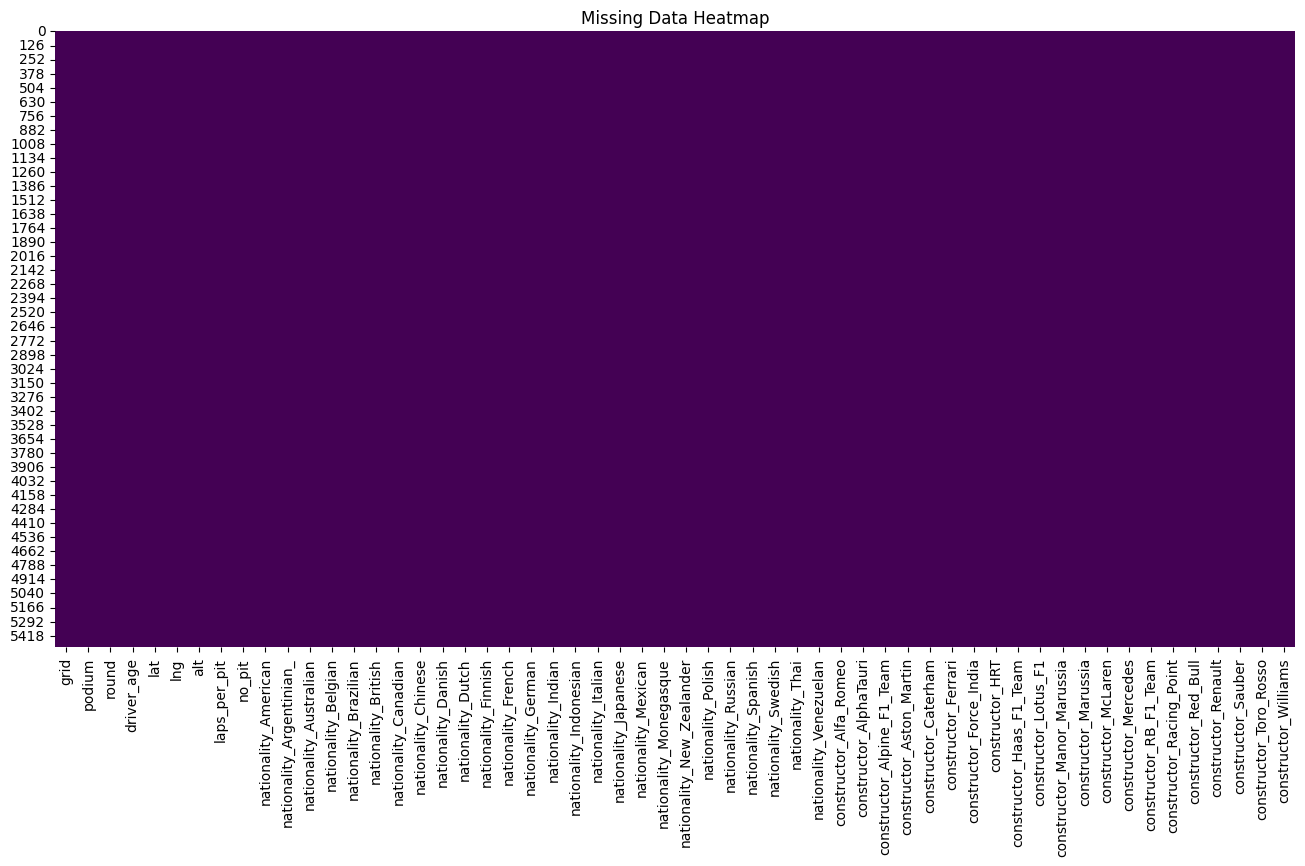

In [47]:
# Heatmap of missing values
plt.figure(figsize=(16,8))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Data Heatmap")
plt.show()

To finish cleaning the dataset, we dropped any duplicate observations and evaluated missingness. Prior to dropping pre-2012 observations, we were missing 79% of pit stop data for our dataset, and it appeared to be non-random missingness as many early years have more missing data (Pre-2012 observations had 97.98% missingness of pit stop data). So, we reduced our sample to 12 years of data from 2012-2024, and for missing laps_per_pit, imputed the average laps_per_pit for any given year in place of the missing value.

We are now missing no data in our 5000+ observations, which means we are done cleaning this set for visualization and modeling!

## Visualize

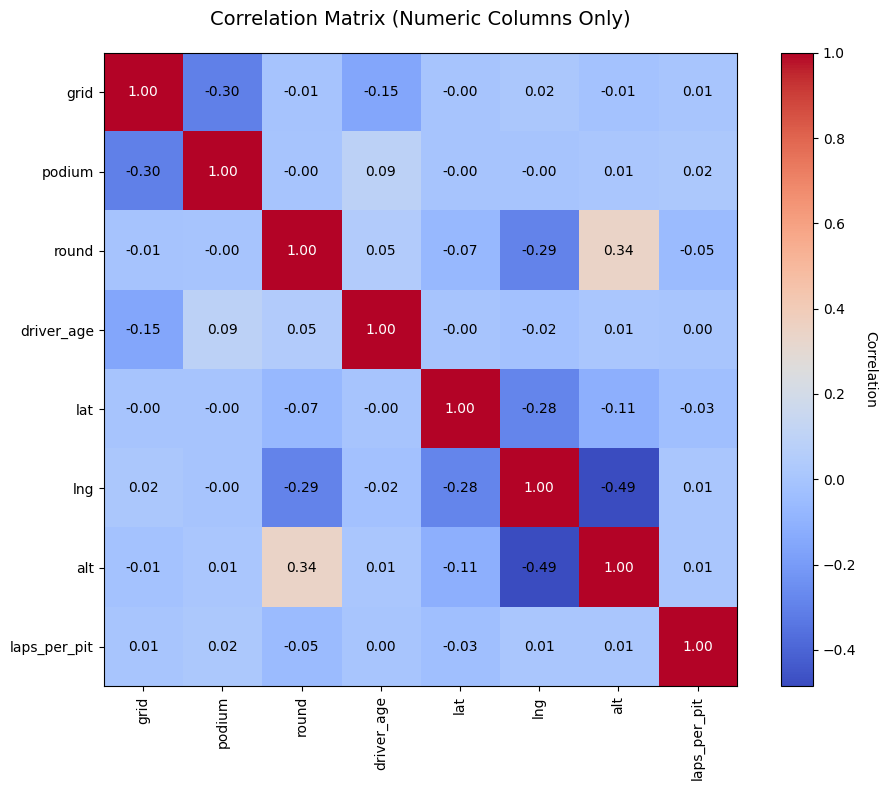

In [9]:
# Select only numeric columns
numeric_df = df[['grid', 'podium', 'round', 'driver_age', 'lat', 'lng', 'alt', 'laps_per_pit']]

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot setup
plt.figure(figsize=(10, 8))  # 50x50 is huge — scaled down to something readable
im = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')

# Add colorbar
cbar = plt.colorbar(im)
cbar.set_label('Correlation', rotation=270, labelpad=15)

# Add axis labels
plt.xticks(
    ticks=np.arange(len(corr_matrix.columns)),
    labels=corr_matrix.columns,
    rotation=90
)
plt.yticks(
    ticks=np.arange(len(corr_matrix.columns)),
    labels=corr_matrix.columns
)

# Annotate each cell with correlation value
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        text_color = 'white' if abs(value) > 0.5 else 'black'  # better contrast
        plt.text(j, i, f'{value:.2f}', ha='center', va='center', color=text_color, fontsize=10)

# Title and layout
plt.title('Correlation Matrix (Numeric Columns Only)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

As mentioned previously, there is correlation between geographic data and country, and we considered dropping country_* fields at this point, but are maintaining them because Ridge Regression or LASSO penalization handles correlated predictors and will stabilize estimates to have narrower interval estimates. These models should help in predicting which variables are redundant.

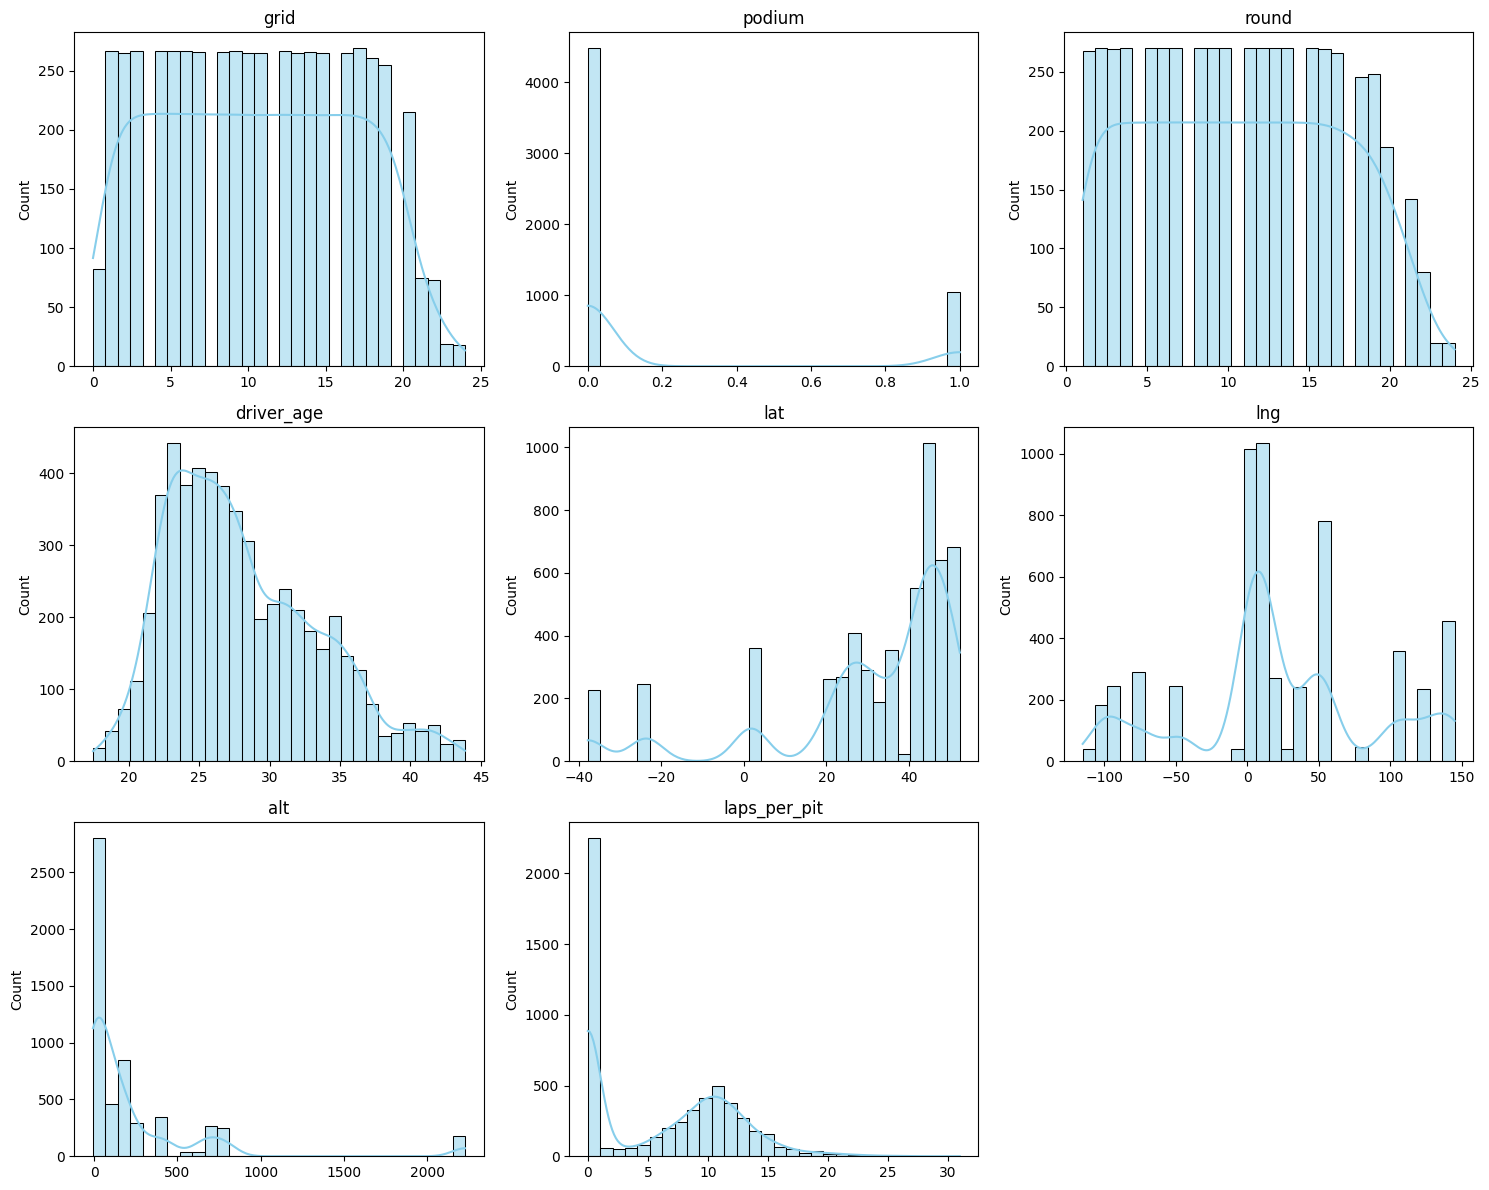

In [69]:
# Select numeric columns
numeric_cols = [
    'grid', 'podium', 'round', 'driver_age', 'lat', 'lng', 'alt', 'laps_per_pit']

# Set up the plot grid
num_cols = 3  # number of plots per row
num_rows = (len(numeric_cols) + num_cols - 1) // num_cols
plt.figure(figsize=(num_cols*5, num_rows*4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.histplot(df[col], kde=True, bins=30, color='skyblue')
    plt.title(col)
    plt.xlabel('')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

Fortunately, for a logistic regression model, we do not need to meet assumptions about variable normality, however, it is still valuable to visualize our primary numeric columns and understand their distributions.

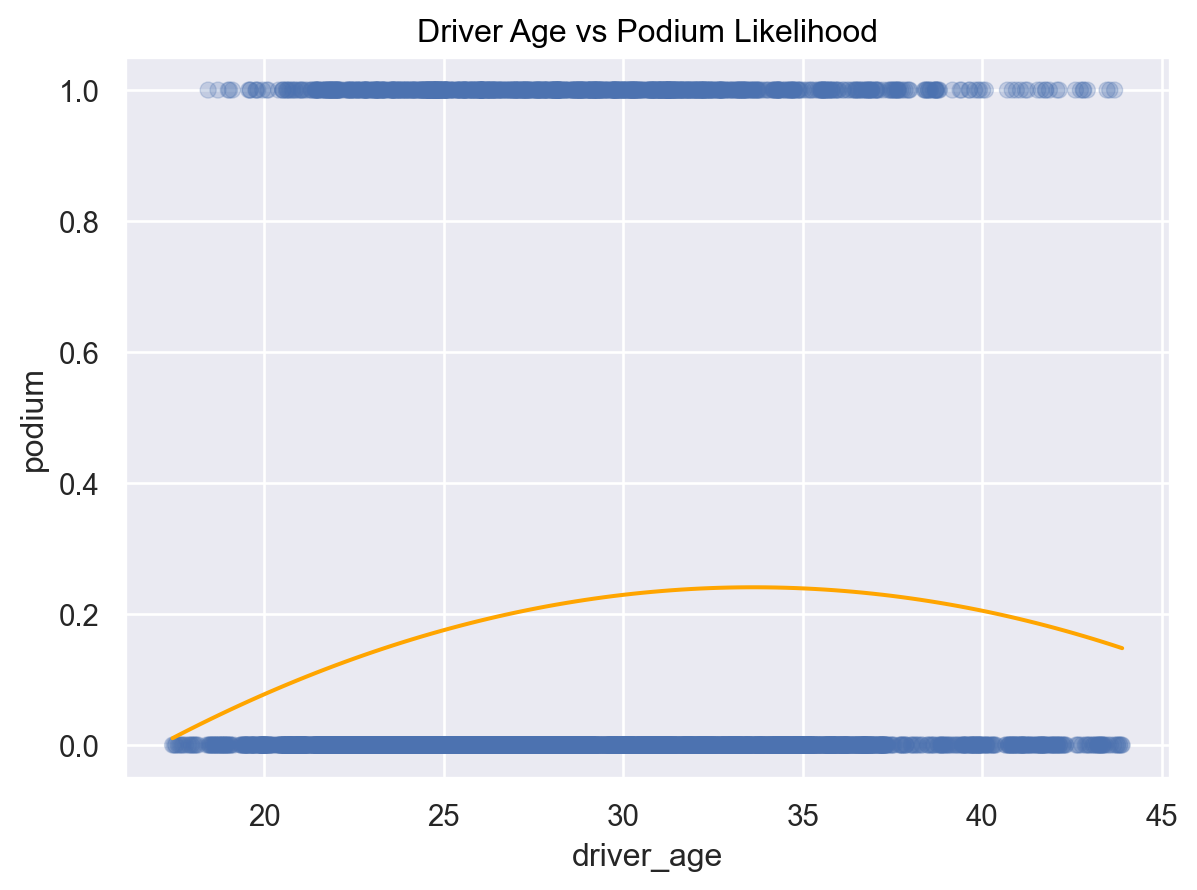

In [51]:
(
    so.Plot(df, x="driver_age", y="podium")
      .add(so.Dot(alpha=0.25))
      .add(so.Line(color="orange"), so.PolyFit())
      .label(title="Driver Age vs Podium Likelihood")
)

This plot visualizes the relationship between a driver's age, and the likelihood of achieving a podium finish (y-axis, binary 0/1 for no/yes), in F1 races, based on historical data. The curved line is a smoothed polynomial regression that shows a non-linear, inverted U-shaped relationship where podium likelihood increases with age early in a career, peaks in the early 30s, and decreases thereafter.

<Axes: xlabel='laps_per_pit', ylabel='podium'>

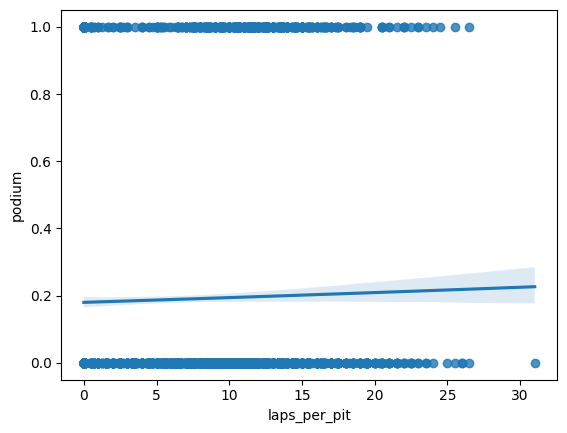

In [24]:
sns.regplot(x='laps_per_pit', y='podium', data=df, logistic=True)

This logistic regression plot models the relationship between laps_per_pit and podium, where blue dots represent individual observations. There's a high density of race observations with a laps_per_pit between 5 and 10, with most points having podium=0. This distribution aligns with what we would expect: most races involve multiple pits due to tire wear, fuel, or incidents, so high laps_per_pit instances are rare.

The dark blue line is the logistic regression fit that starts near 0 probability of podium at 0 laps_per_pit rises almost linearly. This suggests a slight positive linear association where strategies with fewer pits are linked to higher podium probabilities. It is worth noting that with fewer data points with high laps_per_pit, this rise could be driven by outliers in atypical races.

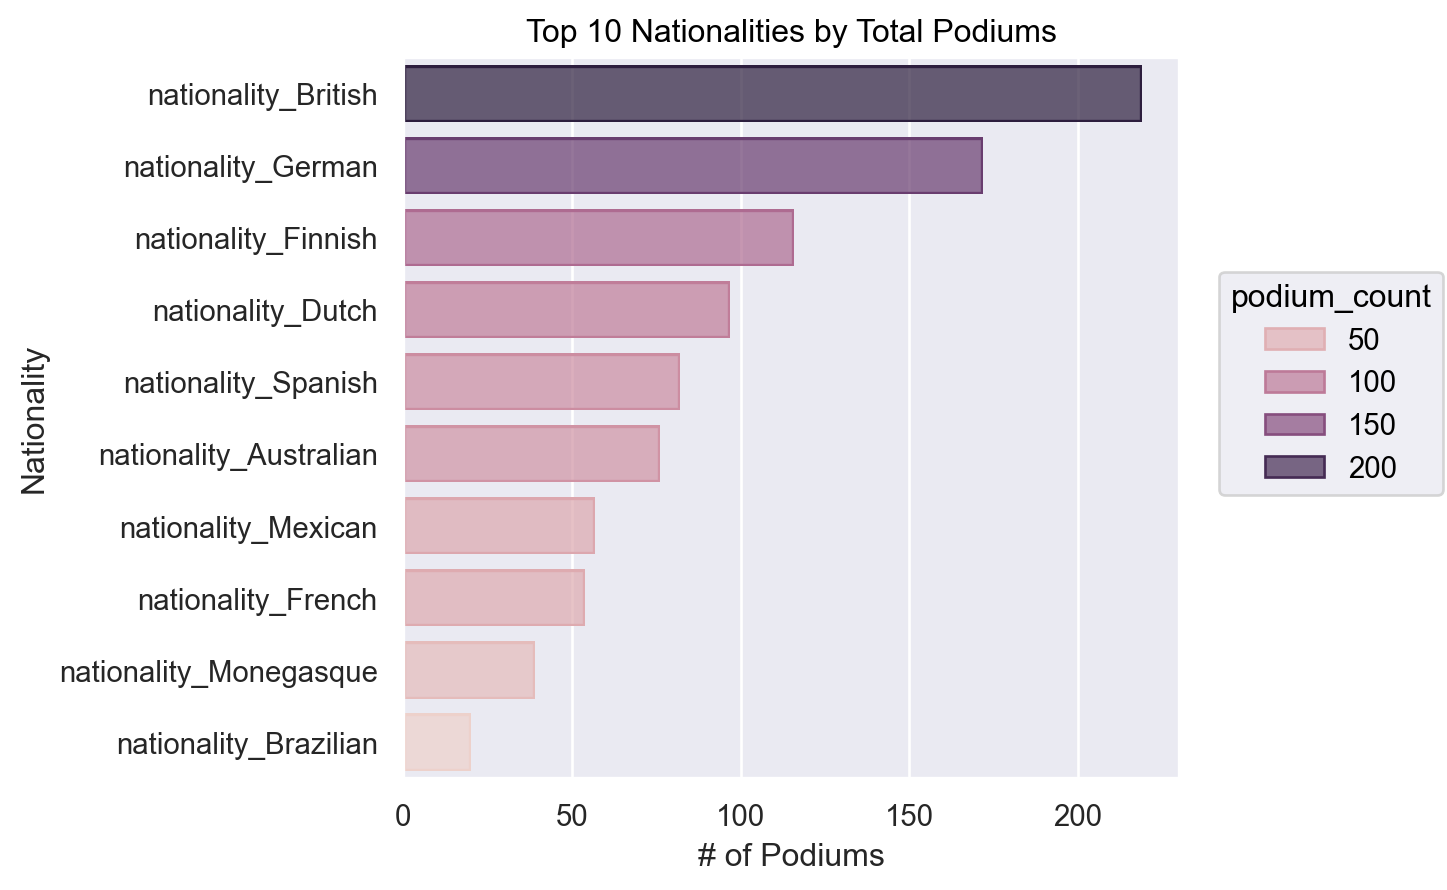

In [71]:
# Compute total number of podiums per nationality
nat_cols = [c for c in df.columns if c.startswith('nationality_')]
nat_names = [c.replace('nationality_', '') for c in nat_cols]

df_nat = df[['podium'] + nat_cols].melt(
    id_vars='podium',
    var_name='nationality',
    value_name='is_nationality'
)

df_nat = df_nat[df_nat['is_nationality'] == 1]

nationality_podium_count = (
    df_nat[df_nat['podium'] == 1]
    .groupby('nationality')
    .size()
    .sort_values(ascending=False)
    .head(10)
    .reset_index(name='podium_count')
)

(
    so.Plot(nationality_podium_count, x='podium_count', y='nationality', color='podium_count')
      .add(so.Bar(), so.Agg())
      .label(title="Top 10 Nationalities by Total Podiums", x="# of Podiums", y="Nationality")
)

This chart shows driver nationalities and the number of race entries or dataset observations per nationality. This effectively communicates which nationalities are the most involved in F1 as drivers.

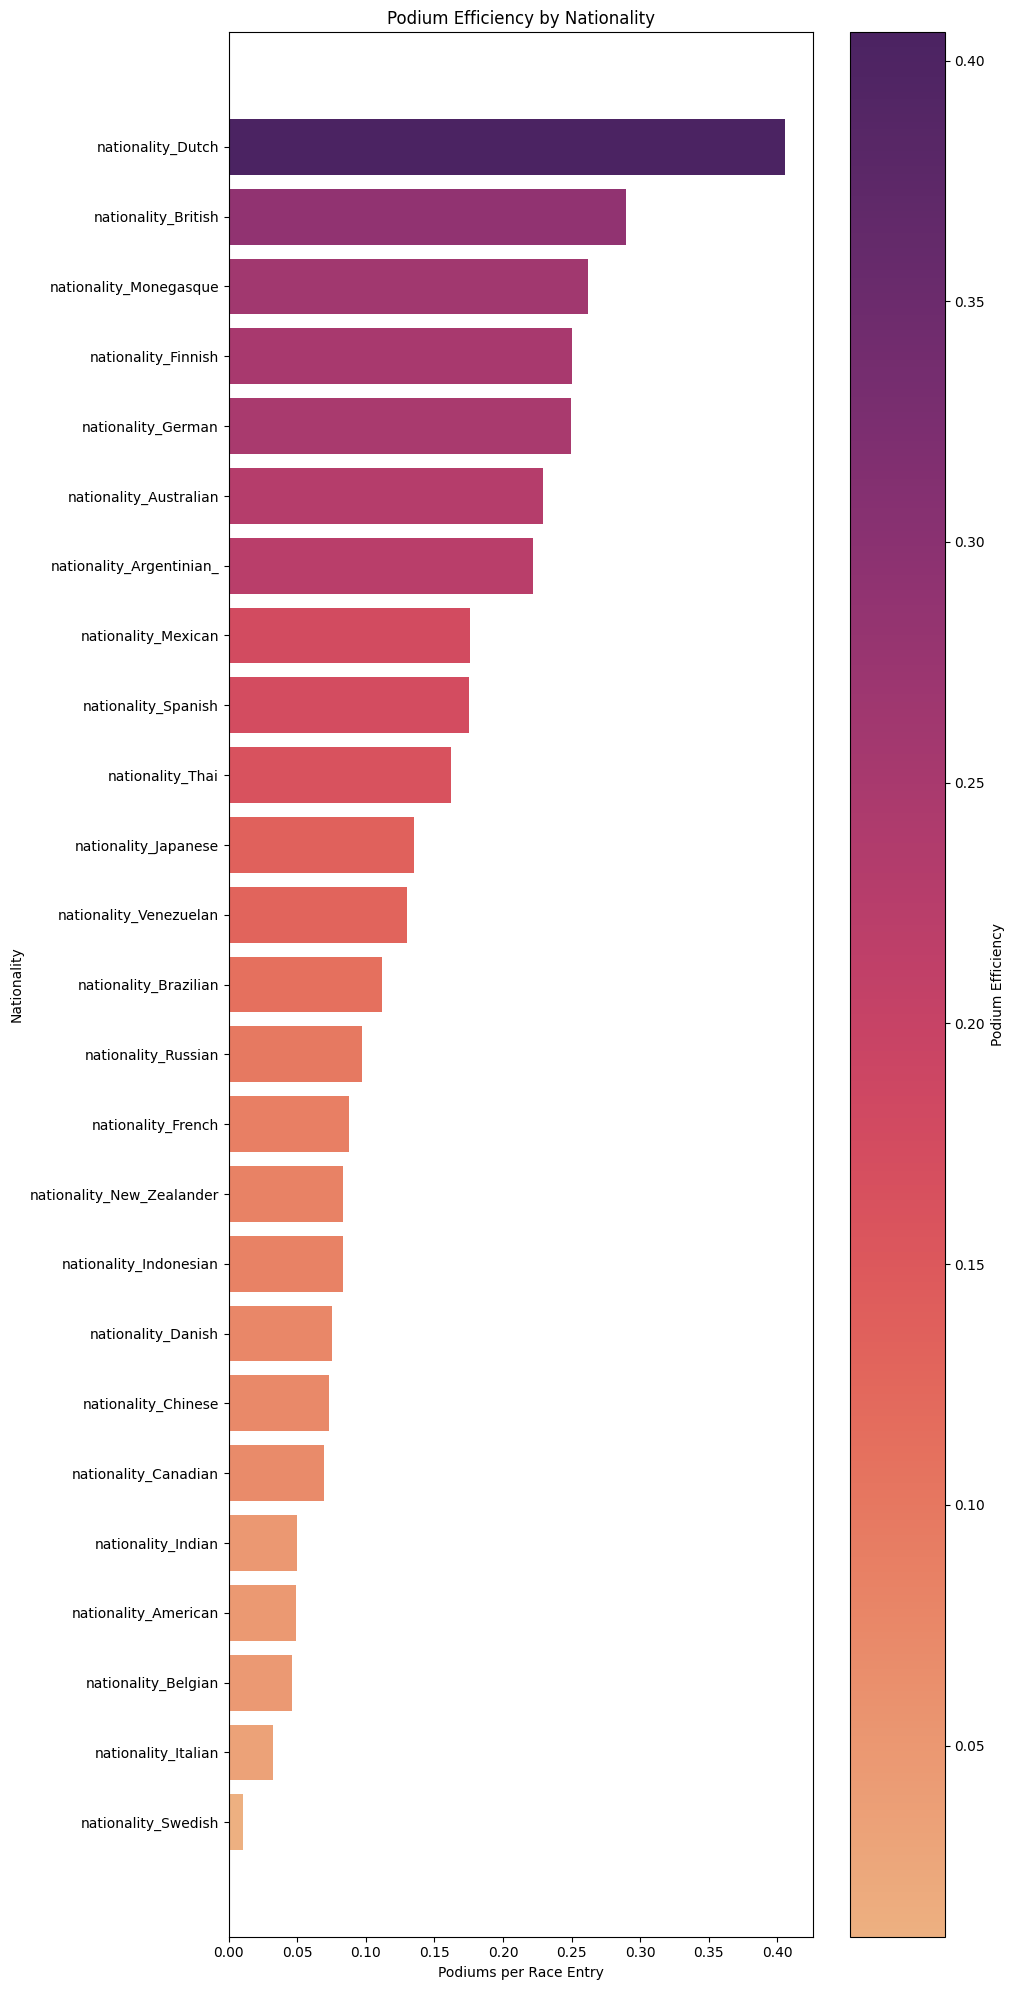

In [101]:
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# Melt nationality columns with podium info
nat_cols = [c for c in df.columns if c.startswith('nationality_')]

df_nat = df[['podium'] + nat_cols].melt(
    id_vars='podium',
    var_name='nationality',
    value_name='is_nationality'
)

# Keep only rows where the driver matches the nationality
df_nat = df_nat[df_nat['is_nationality'] == 1]

# Compute podiums and race entries per nationality
podiums = df_nat[df_nat['podium'] == 1].groupby('nationality').size().reset_index(name='podium_count')
entries = df_nat.groupby('nationality').size().reset_index(name='race_count')

# Merge and compute efficiency
efficiency = pd.merge(podiums, entries, on='nationality')
efficiency['podium_efficiency'] = efficiency['podium_count'] / efficiency['race_count']

# Sort by efficiency descending
efficiency_sorted = efficiency.sort_values('podium_efficiency', ascending=False)

# Normalize values and map to colors
norm = mcolors.Normalize(vmin=efficiency_sorted['podium_efficiency'].min(),
                         vmax=efficiency_sorted['podium_efficiency'].max())
cmap = plt.get_cmap("flare")
colors = cmap(norm(efficiency_sorted['podium_efficiency']))

# Plot
fig, ax = plt.subplots(figsize=(10, 20))
bars = ax.barh(
    efficiency_sorted['nationality'],
    efficiency_sorted['podium_efficiency'],
    color=colors
)

ax.set_xlabel('Podiums per Race Entry')
ax.set_ylabel('Nationality')
ax.set_title('Podium Efficiency by Nationality')

# Flip y-axis
ax.invert_yaxis()  # now lowest efficiency is at the top

# Add colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, label='Podium Efficiency')
plt.tight_layout()
plt.show()

This graph shows the Podiums per Race Entry by driver nationality and measures the "podium efficiency" of different nationalities.

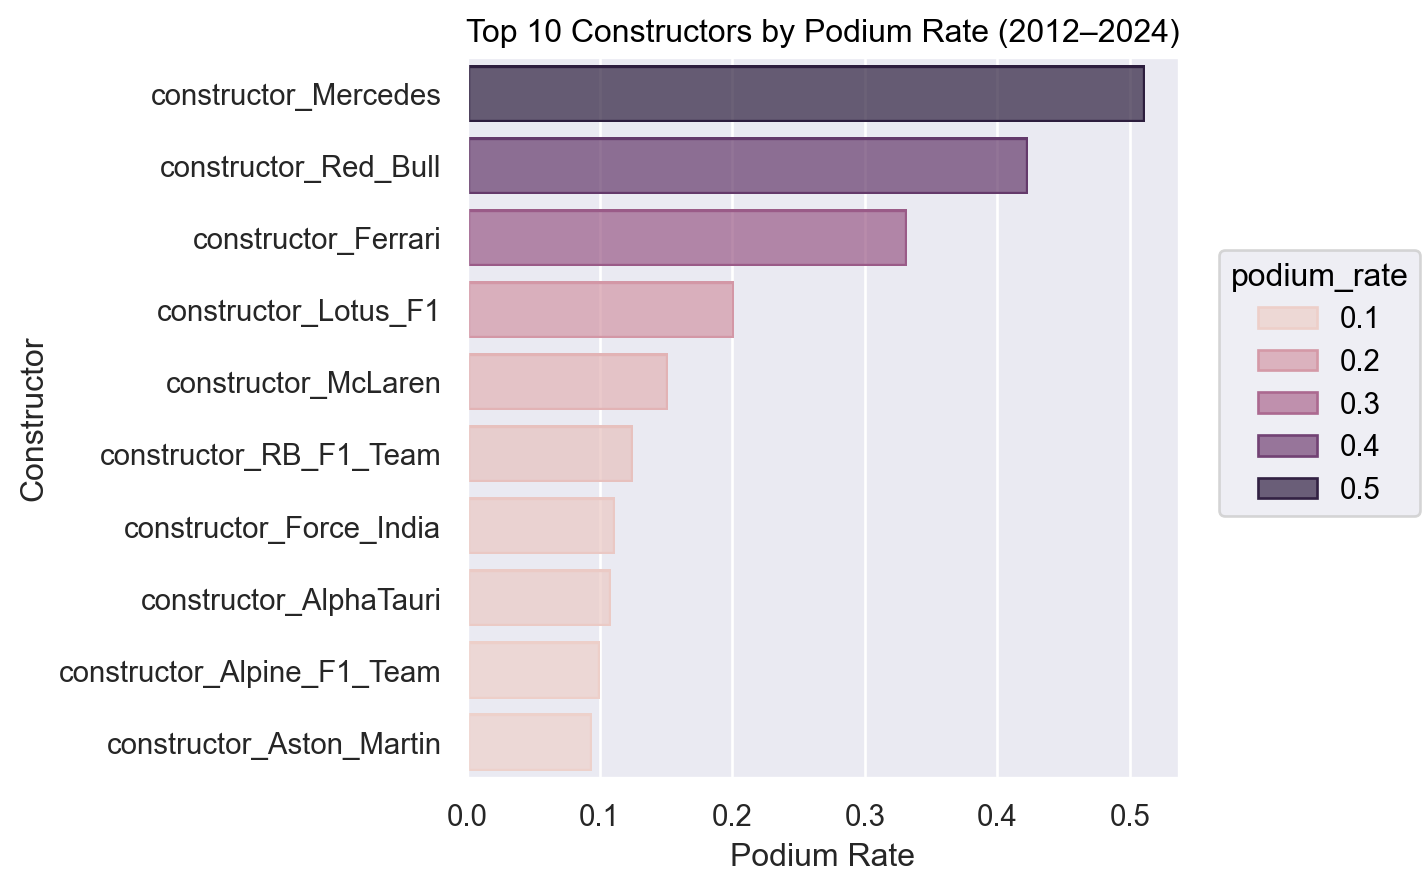

In [49]:
# Compute podium rate per constructor
constructor_cols = [c for c in df.columns if c.startswith('constructor_')]

df_constructors_melted = df[['podium'] + constructor_cols].melt(
    id_vars='podium',
    var_name='constructor',
    value_name='is_constructor'
)

# Keep only rows where driver belongs to that constructor
df_constructors_melted = df_constructors_melted[df_constructors_melted['is_constructor'] == 1]

# Compute podium rate per constructor
constructor_podium_rate = (
    df_constructors_melted
    .groupby('constructor')
    .agg(
        total_entries=('podium', 'count'),
        podiums=('podium', 'sum')
    )
    .assign(podium_rate=lambda x: x['podiums'] / x['total_entries'])
    .sort_values('podium_rate', ascending=False)
    .head(10)
    .reset_index()
)

# Plot top 10 constructors by podium rate
p = (
    so.Plot(constructor_podium_rate, x='podium_rate', y='constructor', color='podium_rate')
      .add(so.Bar(), so.Agg())
      .label(title="Top 10 Constructors by Podium Rate (2012–2024)",
             x="Podium Rate", y="Constructor")
)
# Display
p
p.save("top10_constructor_podium_rate.png", dpi=300)


This chart shows constructors and the top constructors for podium rate in historical F1 races by constructor since 2012. 

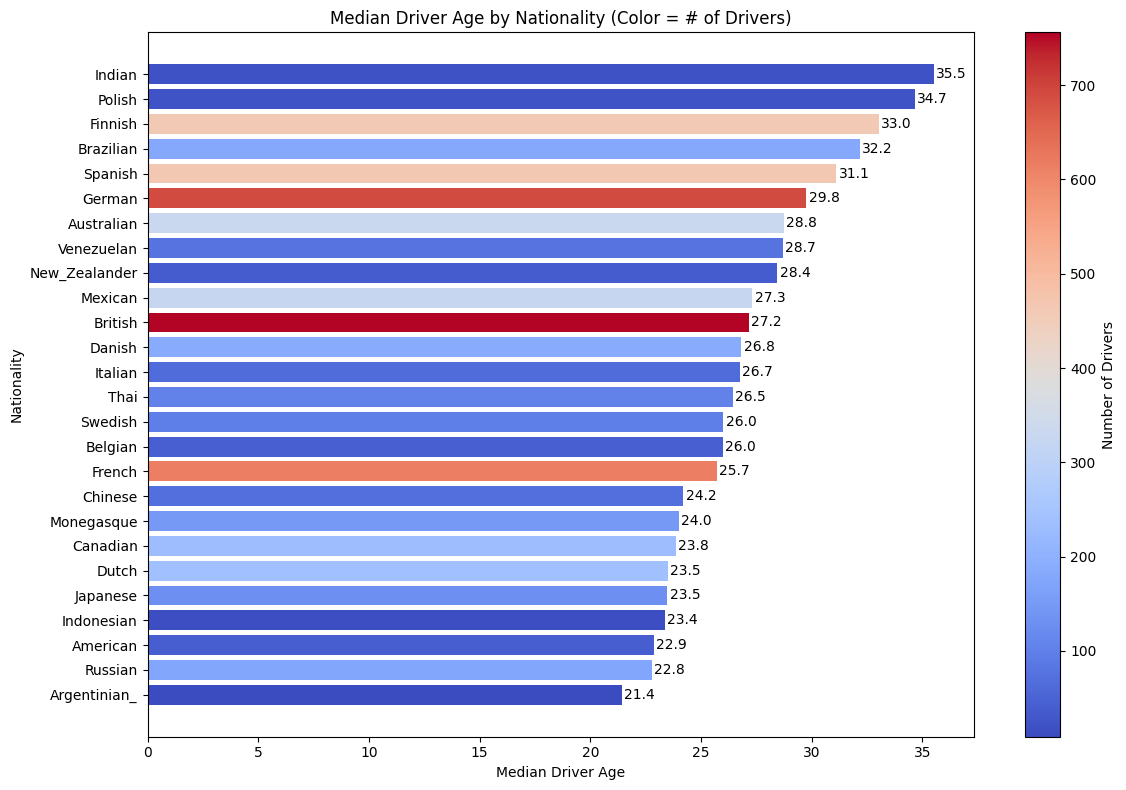

In [109]:
nat_cols = [c for c in df.columns if c.startswith('nationality_')]

# Melt nationality columns
df_nat = df[['driver_age'] + nat_cols].melt(
    id_vars='driver_age',
    var_name='nationality',
    value_name='is_nationality'
)

# Keep only rows where driver matches nationality
df_nat = df_nat[df_nat['is_nationality'] == 1]

# Clean nationality name
df_nat['nationality'] = df_nat['nationality'].str.replace('nationality_', '')

# Compute median age and count
median_age_by_nat = (
    df_nat
    .groupby('nationality')
    .agg(
        median_age=('driver_age', 'median'),
        num_drivers=('driver_age', 'size')
    )
    .sort_values('median_age', ascending=False)
    .reset_index()
)

# Normalize number of drivers for colormap
norm = mcolors.Normalize(vmin=median_age_by_nat['num_drivers'].min(),
                         vmax=median_age_by_nat['num_drivers'].max())
colors = cm.coolwarm(norm(median_age_by_nat['num_drivers']))

# Create figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar chart with color representing number of drivers
bars = ax.barh(median_age_by_nat['nationality'], median_age_by_nat['median_age'], color=colors)
ax.set_xlabel('Median Driver Age')
ax.set_ylabel('Nationality')
ax.set_title('Median Driver Age by Nationality (Color = # of Drivers)')
ax.invert_yaxis()

# Add colorbar using the ScalarMappable and Axes
sm = cm.ScalarMappable(cmap='coolwarm', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Number of Drivers')

# Label each bar with its median age
for bar, median in zip(bars, median_age_by_nat['median_age']):
    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
            f'{median:.1f}', va='center')

plt.tight_layout()
plt.show()

This visualization shows the median driver age by nationality between 2012 and 2024, with color representing the number of drivers of that nationality. Warmer bars have a much larger sample size.

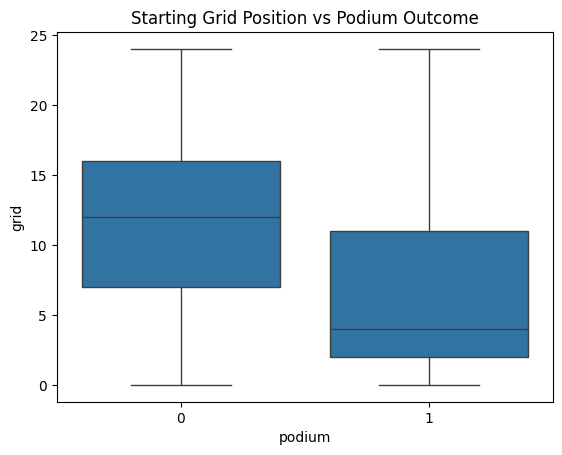

In [46]:
sns.boxplot(x='podium', y='grid', data=df)
plt.title("Starting Grid Position vs Podium Outcome")
plt.savefig("my_plot.png") 
plt.show()

F1 grid positions are determined by a three-stage qualifying session (before the race), where the fastest lap times set by drivers dictate their starting order for the race. Grid penalties can also cause a driver's position to change from the qualifying result.

Grid does not reflect data leakage, because it is not knowledge that would be known at the time of predicting race outcome, but it does reflect driver performance in qualifying rounds, plus penalties. It encodes driver skill and car performance as indicators, which influence race outcome.

This chart demonstrates the increase in podium finish likelihood at lower (more optimal) starting grid positions. It also makes perfect sense that the distribution for starting grid positions where the outcome is not a podium finish is an even distribution from 1-25 with an average in the center of possible grid positions.

# D. Logistic Regression

# Reconcile

The first step in preparing our dataset for classification is meeting key assumptions for logistic regression. Logistic regression does not require normality of predictors or residuals (unlike OLS), but does require careful checking of the following assumptions:

- **Validity** (ensuring the data is relevant and not missing predictors)
- **Representativeness** (how the data was collected, missingness, influential points, and dropping or imputing information)
- **Linearity** (if the population can be approximated by an additive and linear function, in the logit scale)
- **Iindependence** (if observations are independent and identically distributed or at least exchangable)
- **Multicollinearity** (whether there is high correlation between predictors)

We discuss each assumption below, including why it matters, diagnostics (with code), whether our data meets it, and any fixes applied or considered. These checks help ensure our model's estimates are reliable and interpretable for predicting podium finishes.

## Validity

Validity ensures the data is relevant to the objective of predicting podium finishes, and includes key predictors without critical omissions. Omitted variables can bias coefficients if they correlate with included predictors and the outcome, leading to confounded inferences. Including irrelevant variables can inflate variance but is less harmful in penalized models like LASSO/Ridge, which can shrink our coefficients to near zero. 

The Ergast API dataset directly covers F1 historical data (1950-2024), including race outcomes, driver details, circuits, and pit stops. This sample covers 2012-2024. It matches well for historical analaysis but lacks real time factors like weather or tire strategy details, which could be proxies via laps_per_pit and grid. We are also missing obviously critical vehicle details, mostly due to constructor privacy. In our simulated dataset (Section B), we recovered key betas with significance for continuous predictors, but categorical ones were noisy due to imbalance. Real data shows similar patterns: grid is strongly negatively associated with podium rate, but nationalities are more imbalanced than our simulation could have captured.

Lat/lng/alt/country_* serve as circuit proxies, and grid captures pre-race performance. If needed, we could find additional data (like weather data), but will not pursue here due to project scope limitations and already having a significant amount of predictors.

## Representativeness

Representativeness ensures the data reflects the population and process of the real scenario we are hoping to capture. Non-representative data can lead to poor generalization, especially if missingness or influential points distort estimates. Unfortunately, we would have hundreds of discrete predictors if we wanted to include race constructor or driver as inputs.

This data is one of the most representative sources for historical F1 races. It covers all seasons, but may be imbalanced (e.g. more recent races, dominant nationalities like British and German). In choosing a sample from the full dataset, we chose a period of more than a decade, including the most recent full season. 

Prior to running a diagnostic for representativeness, we will first fit a GLM on our cleaned data.

In [77]:
import statsmodels.api as sm

df_glmfit = df.drop(['nationality_American', 'constructor_Aston_Martin'], axis=1)

X = df_glmfit.drop('podium', axis=1)
y = df_glmfit['podium']

# Add constant for intercept
X = sm.add_constant(X)

# Fit unpenalized GLM (logistic regression)
glm_fit = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(glm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 podium   No. Observations:                 5524
Model:                            GLM   Df Residuals:                     5470
Model Family:                Binomial   Df Model:                           53
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1947.6
Date:                Wed, 19 Nov 2025   Deviance:                       3895.3
Time:                        01:56:44   Pearson chi2:                 5.13e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.2315
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

Then, we checked for influential data points using Cook's Distance (a score for how much each observation affected the whole model) and DFBETAS (scores for how much each point affected specific parts of the GLM). Influential points weren't necessarily bad, they might have represented real, rare events, but could also distort the model if they weren't considered.

Cook's distance assessed how much removing a single observation $i$ changed the model's predicted values for all other observations. High values indicated the point was pulling the entire model in a certain direction. DFBETAS measured how removing any observation $i$ changed each individual coefficient. It was useful for pinpointing which points affected specific predictors, and helped to check representativeness by showing if certain features were driven by unrepresentative points.

In [78]:
# Get influence and flag points
influence = glm_fit.get_influence()

# Cook's Distance (overall influence)
cooks_distance = influence.cooks_distance[0]

# DFBETAS (per-coefficient influence)
dfbetas = influence.dfbetas
dfbetas_df = pd.DataFrame(dfbetas, columns=glm_fit.params.index, index=df_glmfit.index)

# Summary DataFrame for Cook's
influence_df = pd.DataFrame({
    'cooks_distance': cooks_distance,
}, index=df_glmfit.index)

# Flag influential points using Cook's threshold (4/n)
influence_df['influential_cooks'] = influence_df['cooks_distance'] > 4 / len(df_glmfit)

In [88]:
# Investigate a few of the influential points (for Cook's distance, potentially influential points have a Distance > 4 / n, or 4 / 5500 in this case = 0.0007)
# For DFBETAS the threshold is |DFBETA| > 2 / √n (≈ 0.027 if n ≈ 5500)
# Set Thresholds
cooks_threshold = 4 / len(df_glmfit)
dfbetas_threshold = 2 / np.sqrt(len(df_glmfit))

# Identify top Cook's Distance points
top_cooks = influence_df.sort_values('cooks_distance', ascending=False).head(20)

# Identify points with multiple strong DFBETAS
dfbetas_strong = (np.abs(dfbetas_df) > dfbetas_threshold).sum(axis=1)
dfbetas_influential = dfbetas_strong[dfbetas_strong > 2].index  # More than 2 coefficients affected

# Combine and print top
influential_indices = set(top_cooks.index).union(set(dfbetas_influential))
influential_indices = list(influential_indices)  # convert set to list
print(f"Top influential observations: {len(influential_indices)} total")

# Pull those observations from the original dataframe
df_influential = df.loc[influential_indices].copy()

# Sort by Cook's distance to see which are strongest
df_influential = df_influential.merge(
    influence_df[['cooks_distance']],
    left_index=True,
    right_index=True,
    how='left'
).sort_values('cooks_distance', ascending=False)

keep_cols = [
    "grid", "round", "laps_per_pit", "podium", "round", "driver_age", "cooks_distance"
]

df_condensed = df_influential[keep_cols].copy()

# Sort again by Cook's distance
df_condensed = df_condensed.sort_values("cooks_distance", ascending=False)

print(df_condensed.head(10).to_markdown(index=True))

Top influential observations: 653 total
|      |   grid |   round |   laps_per_pit |   podium |   round |   driver_age |   cooks_distance |
|-----:|-------:|--------:|---------------:|---------:|--------:|-------------:|-----------------:|
| 1601 |     17 |      15 |         0      |        1 |      15 |      25.1061 |       0.0196924  |
|   23 |      0 |       1 |         0      |        1 |       1 |      35.1732 |       0.017413   |
| 1770 |     21 |       4 |         0      |        1 |       4 |      23.2717 |       0.0161888  |
| 2183 |     18 |       2 |         0      |        1 |       2 |      23.3183 |       0.0158     |
| 5413 |     15 |      19 |         0      |        1 |      19 |      21.4018 |       0.0147741  |
| 5439 |     12 |      20 |        13      |        1 |      20 |      22.7077 |       0.0130238  |
| 5198 |     15 |       8 |         0.5    |        1 |       8 |      23.4004 |       0.0116786  |
| 5300 |     14 |      13 |        18.3333 |        1 |     

While some of these metrics seem irregular, like 18 laps per pit or 13 laps per pit, for the most part there is nothing particularly alarming about these points that would inform a decision to remove a particular point. We will move forward assuming the data is mostly representative.

## Linearity

In logistic regression, linearity means the log-odds (logit) of the outcome is a linear function of predictors. Violation leads to biased predictions and poor fit (e.g. underestimating effects at extremes). We can diagnose linearity with scatterplots of log-odds and predictors and partial regression plots using statsmodels for GLM partial regressions. First, we will run an initial generalized linear model.

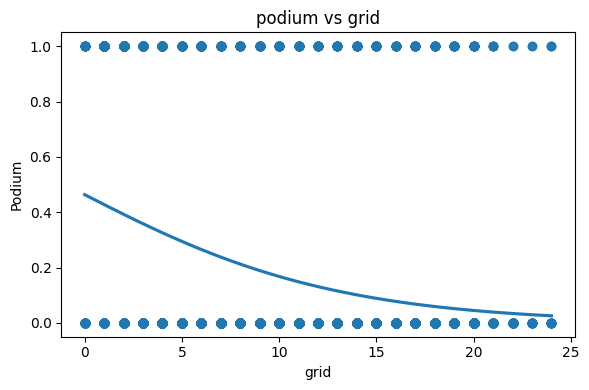

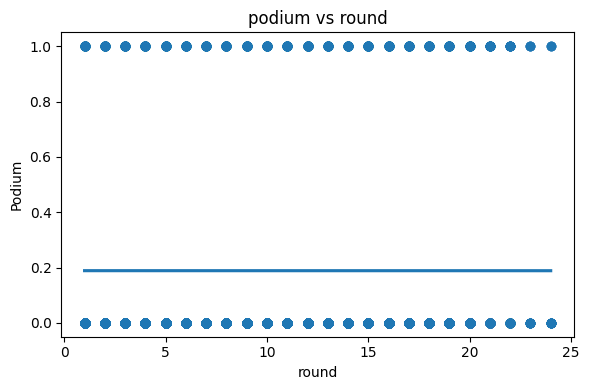

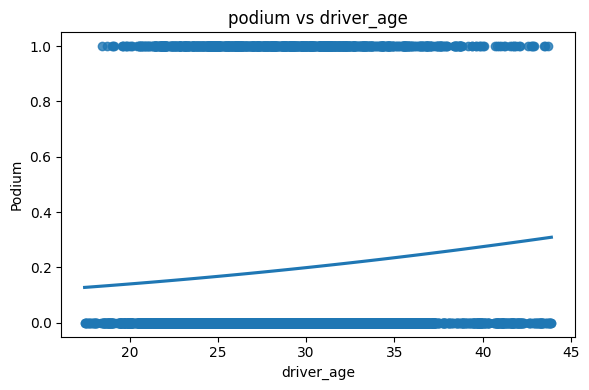

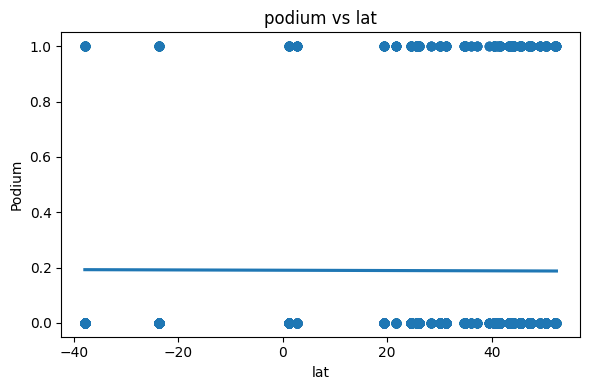

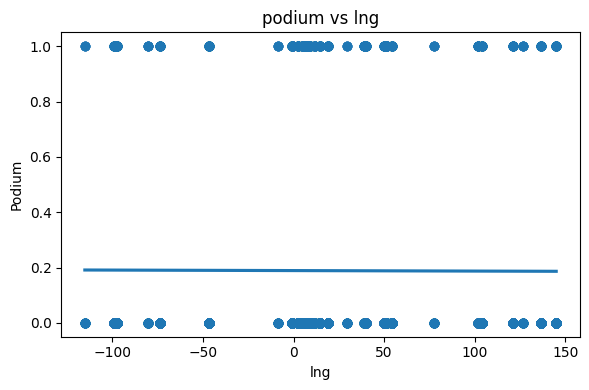

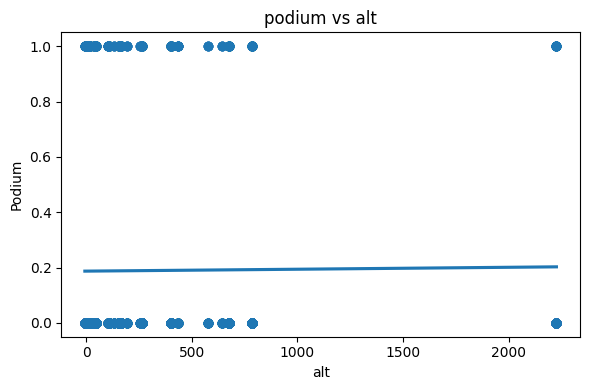

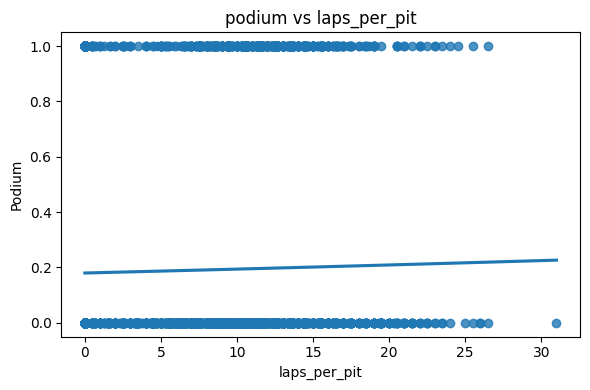

In [23]:
# Continuous predictors to inspect
continuous_vars = ['grid', 'round', 'driver_age', 'lat', 'lng', 'alt', 'laps_per_pit']
# Plot podium vs each predictor with logistic regression line
for var in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=var, y='podium', data=df, logistic=True, ci=None)
    plt.title(f'podium vs {var}')
    plt.xlabel(var)
    plt.ylabel('Podium')
    plt.tight_layout()
    plt.show()

These scatterplots show that our dataset meets the linearity assumptions for a logistic regression model where the logit outcome (log-odds) of a podium event has a linear relationship with each continuous predictor. The lines are monotone (either consistently increasing/decreasing/stagnant), and roughly linear.

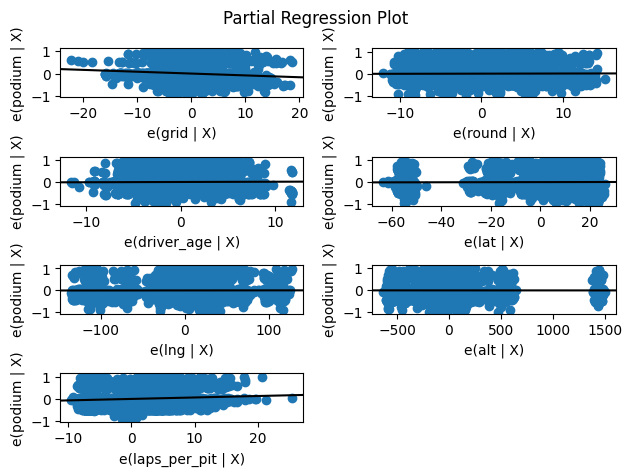

In [26]:
# Partial regression plots
from statsmodels.graphics.regressionplots import plot_partregress_grid

# Create partial regression plots for the GLM model
fig = plot_partregress_grid(glm_fit, exog_idx=['grid', 'round', 'driver_age', 'lat', 'lng', 'alt', 'laps_per_pit'])
fig.tight_layout(pad=1.0)
plt.show()

The partial regression plots also look roughly normal.

## Independence

Observations should be independent or exchangeable. Violations include clustering, time series (sequential data), or spatial correlation. The data is not a random sample, as it comes from an exhaustive historical dataset. There are some repeat measures like repeat drivers across races, meaning we may have clustering by driver/year/circuit, as well as sequences through time series becasue of columns like year and round.

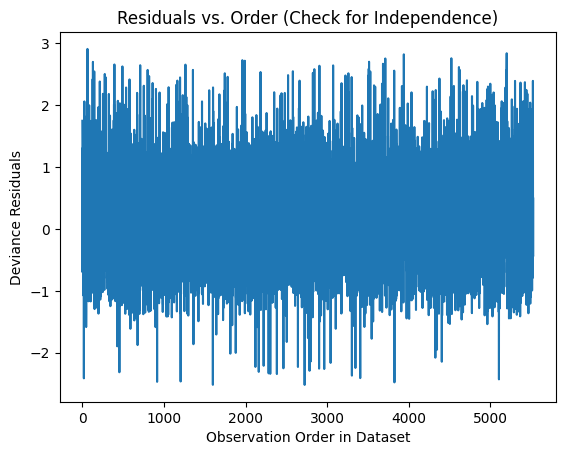

In [27]:
df_glmfit = df.drop(['nationality_American', 'constructor_Aston_Martin'], axis=1)

X = df_glmfit.drop('podium', axis=1)
y = df_glmfit['podium']

# Add constant for intercept
X = sm.add_constant(X)

# Fit unpenalized GLM (logistic regression)
glm_fit = sm.GLM(y, X, family=sm.families.Binomial()).fit()

# Get deviance residuals from GLM fit
df['residuals'] = glm_fit.resid_deviance  # <-- fixed name here

# Plot residuals vs. order (index as proxy for time/order)
x_values = range(1, len(df) + 1)
plt.plot(x_values, df['residuals'], linestyle='-')
plt.xlabel("Observation Order in Dataset")
plt.ylabel("Deviance Residuals")
plt.title("Residuals vs. Order (Check for Independence)")
plt.show()

We initially did not meet the assumption for independence due to leaving out constructor (an important category in how drivers and race outcomes are grouped). This output comes closer, but does not fully meet this assumption due to excluding some other metrics to identify drivers. However, driver_age is a decent proxy for this.

It is unorthodox to use a linear regression diagnostic to check this assumption for these classification models, however, at this point it is our best option, so we are moving forward with this check.

That being said, this output is much cleaner than our initial independence tests after making these changes. There doesn't appear to be a trend in the sequential plot, and if residuals fluctuate seemingly at random around zero with no pattern, it suggests our model errors are independent.

## Multicollinearity

Multicollinearity poses a significant challenge for identifiability in regression models because it can undermine our ability to uniquely estimate and interpret individual coefficients for predictors. While predictors are highly correlated, they are nearly linearly dependent, which can lead ot non-unique or unstable estimates. Fortunately, while we don't have a way to calculate $R^2$ in logistic regression, we can still run an ordinary least squares (OLS) model to compute the variance inflation factor (VIF) for this model, because it has a binary outcome.

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Default columns to always exclude (target and reference dummies)
exclude_cols = ['podium', 'nationality_American', 'constructor_Aston_Martin']

# Additional variables we may want to remove for testing
remove_vars = ['']

# Combine all columns to exclude
all_exclude = exclude_cols + remove_vars

# Get predictors = everything else
predictors = [col for col in df.columns if col not in all_exclude]
X_train = df[predictors]

# Compute VIF values
vif = np.zeros(len(X_train.columns))
for i in range(len(X_train.columns)):
    vif[i] = variance_inflation_factor(X_train.values, i)

# Create Polars DataFrame
vif_df = pl.DataFrame({
    'predictors': predictors,
    'vif': vif
})

# Display up to 55 rows
with pl.Config(tbl_rows=55):
    print(vif_df)

shape: (54, 2)
┌────────────────────────────┬───────────┐
│ predictors                 ┆ vif       │
│ ---                        ┆ ---       │
│ str                        ┆ f64       │
╞════════════════════════════╪═══════════╡
│ grid                       ┆ 7.288288  │
│ round                      ┆ 4.948282  │
│ driver_age                 ┆ 44.337784 │
│ lat                        ┆ 3.367466  │
│ lng                        ┆ 1.776223  │
│ alt                        ┆ 1.918891  │
│ laps_per_pit               ┆ 2.354971  │
│ no_pit                     ┆ 1.190781  │
│ nationality_Argentinian_   ┆ 1.108827  │
│ nationality_Australian     ┆ 6.367534  │
│ nationality_Belgian        ┆ 1.701795  │
│ nationality_Brazilian      ┆ 3.69868   │
│ nationality_British        ┆ 12.148727 │
│ nationality_Canadian       ┆ 2.971298  │
│ nationality_Chinese        ┆ 2.114709  │
│ nationality_Danish         ┆ 3.910597  │
│ nationality_Dutch          ┆ 4.452569  │
│ nationality_Finnish        ┆ 8.316766

Our variance inflation factors were very inflated for several predictors, however, by removing year from our dataset, we instantly removed most of the variation in the model. This is likely due to bias introduced by the time-series field. The result is normal VIFs with the exception of driver_age, at ~44. This indicates strong multicollinearity with some other predictors, but for regularized models like LASSO or Ridge Regression, multicollinearity is not a problem, so for now, we will continue while including driver_age.

If we were to remove driver_age, it would leave us with mostly moderate VIFs (2-5) and nothing higher than 7, which would be satisfactory enough to move on from this assumption.

In [29]:
df = df.drop(['residuals'], axis=1)

# Estimate/Fit

Now that we have cleaned our data and met most of our model assumptions, we can run an initial generalized linear model and interpret the interval estimates to gain an idea for which variables have certain effects on our outcome of podium or no podium (1/0), and how we should change our model for better estimates.

In [30]:
df_glmfit = df.drop(['nationality_American', 'constructor_Aston_Martin'], axis=1)

X = df_glmfit.drop('podium', axis=1)
y = df_glmfit['podium']

# Add constant for intercept
X = sm.add_constant(X)

# Fit unpenalized GLM (logistic regression)
glm_fit = sm.GLM(y, X, family=sm.families.Binomial()).fit()

print(glm_fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 podium   No. Observations:                 5524
Model:                            GLM   Df Residuals:                     5470
Model Family:                Binomial   Df Model:                           53
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1947.6
Date:                Wed, 19 Nov 2025   Deviance:                       3895.3
Time:                        01:35:22   Pearson chi2:                 5.13e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.2315
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

## Interpretation of interval estimates

- `const`: Not typically of interest, but the intercept parameter estimate says we can expect, with 95% probability, a decrease of −5.121 to −1.434 log-odds of a driver achieving a podium finish when all continuous predictors are zero and categorical predictors are at their reference levels (nationality = American, constructor = Aston Martin). This parameter estimate is statistically significant.

- `grid`: This parameter estimate says we can expect, with 95% probability, a decrease of −0.091 to −0.054 log-odds of a driver achieving a podium finish for every one additional unit in grid, holding all other predictors constant. This parameter estimate is slightly statistically significant.

- `round`: This parameter estimate says we can expect, with 95% probability, a change of −0.009 to 0.020 log-odds of a driver achieving a podium finish for every one additional unit in round, holding all other predictors constant. This parameter estimate is not statistically significant.

- `driver_age`: This parameter estimate says we can expect, with 95% probability, a change of −0.011 to 0.030 log-odds of a driver achieving a podium finish for every one additional year in driver_age, holding all other predictors constant. This parameter estimate is not statistically significant.

- `lat`: This parameter estimate says we can expect, with 95% probability, a change of −0.002 to 0.005 log-odds of a driver achieving a podium finish for every one additional degree in latitude, holding all other predictors constant. This parameter estimate is not statistically significant.

- `lng`: This parameter estimate says we can expect, with 95% probability, a change of −0.001 to 0.002 log-odds of a driver achieving a podium finish for every one additional degree in longitude, holding all other predictors constant. This parameter estimate is not statistically significant.

- `alt`: This parameter estimate says we can expect, with 95% probability, a change of −0.000 to 0.000 log-odds of a driver achieving a podium finish for every one additional meter in altitude, holding all other predictors constant. This parameter estimate is not statistically significant.

- `laps_per_pit`: This parameter estimate says we can expect, with 95% probability, an increase of 0.048 to 0.077 log-odds of a driver achieving a podium finish for every one additional lap per pit, holding all other predictors constant. This parameter estimate is statistically significant.

- `no_pit`: This parameter estimate says we can expect, with 95% probability, an increase of 3.028 to 3.628 log-odds of a driver achieving a podium finish when the driver had no pit stops compared to having pit stops, holding all other predictors constant. This parameter estimate is statistically significant.

- `nationality_Argentinian_`: This parameter estimate says we can expect, with 95% probability, a change of −0.302 to 4.476 log-odds of a driver achieving a podium finish when the driver's nationality is Argentinian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Australian`: This parameter estimate says we can expect, with 95% probability, a change of −0.873 to 2.432 log-odds of a driver achieving a podium finish when the driver's nationality is Australian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Belgian`: This parameter estimate says we can expect, with 95% probability, a change of −2.627 to 1.835 log-odds of a driver achieving a podium finish when the driver's nationality is Belgian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Brazilian`: This parameter estimate says we can expect, with 95% probability, a change of −1.346 to 1.978 log-odds of a driver achieving a podium finish when the driver's nationality is Brazilian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_British`: This parameter estimate says we can expect, with 95% probability, a change of −0.774 to 2.480 log-odds of a driver achieving a podium finish when the driver's nationality is British compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Canadian`: This parameter estimate says we can expect, with 95% probability, a change of −1.313 to 2.073 log-odds of a driver achieving a podium finish when the driver's nationality is Canadian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Chinese`: This parameter estimate says we can expect, with 95% probability, a change of −0.689 to 3.231 log-odds of a driver achieving a podium finish when the driver's nationality is Chinese compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Danish`: This parameter estimate says we can expect, with 95% probability, a change of −1.203 to 2.313 log-odds of a driver achieving a podium finish when the driver's nationality is Danish compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Dutch`: This parameter estimate says we can expect, with 95% probability, a change of −0.500 to 2.815 log-odds of a driver achieving a podium finish when the driver's nationality is Dutch compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Finnish`: This parameter estimate says we can expect, with 95% probability, a change of −0.749 to 2.501 log-odds of a driver achieving a podium finish when the driver's nationality is Finnish compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_French`: This parameter estimate says we can expect, with 95% probability, a change of −1.307 to 2.011 log-odds of a driver achieving a podium finish when the driver's nationality is French compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_German`: This parameter estimate says we can expect, with 95% probability, a change of −0.835 to 2.414 log-odds of a driver achieving a podium finish when the driver's nationality is German compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Indian`: This parameter estimate says we can expect, with 95% probability, a change of −3.395 to 3.279 log-odds of a driver achieving a podium finish when the driver's nationality is Indian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Indonesian`: This parameter estimate says we can expect, with 95% probability, a change of −1.935 to 3.911 log-odds of a driver achieving a podium finish when the driver's nationality is Indonesian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Italian`: This parameter estimate says we can expect, with 95% probability, a change of −1.456 to 3.338 log-odds of a driver achieving a podium finish when the driver's nationality is Italian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Japanese`: This parameter estimate says we can expect, with 95% probability, a change of −0.712 to 2.843 log-odds of a driver achieving a podium finish when the driver's nationality is Japanese compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Mexican`: This parameter estimate says we can expect, with 95% probability, a change of −0.967 to 2.347 log-odds of a driver achieving a podium finish when the driver's nationality is Mexican compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Monegasque`: This parameter estimate says we can expect, with 95% probability, a change of −1.105 to 2.234 log-odds of a driver achieving a podium finish when the driver's nationality is Monegasque compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_New_Zealander`: This parameter estimate says we can expect, with 95% probability, a change of −1.669 to 2.620 log-odds of a driver achieving a podium finish when the driver's nationality is New Zealander compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Polish`: This parameter estimate says we can expect, with 95% probability, a change of −3.12e+04 to 3.12e+04 log-odds of a driver achieving a podium finish when the driver's nationality is Polish compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Russian`: This parameter estimate says we can expect, with 95% probability, a change of −1.164 to 2.262 log-odds of a driver achieving a podium finish when the driver's nationality is Russian compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Spanish`: This parameter estimate says we can expect, with 95% probability, a change of −1.047 to 2.232 log-odds of a driver achieving a podium finish when the driver's nationality is Spanish compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Swedish`: This parameter estimate says we can expect, with 95% probability, a change of −4.533 to 0.699 log-odds of a driver achieving a podium finish when the driver's nationality is Swedish compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Thai`: This parameter estimate says we can expect, with 95% probability, a change of −0.990 to 2.372 log-odds of a driver achieving a podium finish when the driver's nationality is Thai compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `nationality_Venezuelan`: This parameter estimate says we can expect, with 95% probability, a change of −1.624 to 1.983 log-odds of a driver achieving a podium finish when the driver's nationality is Venezuelan compared to American, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Alfa_Romeo`: This parameter estimate says we can expect, with 95% probability, a decrease of −2.708 to −0.268 log-odds of a driver achieving a podium finish when the constructor is Alfa Romeo compared to Aston Martin, holding all other predictors constant. This parameter estimate is statistically significant.

- `constructor_AlphaTauri`: This parameter estimate says we can expect, with 95% probability, a change of −1.105 to 0.789 log-odds of a driver achieving a podium finish when the constructor is AlphaTauri compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Alpine_F1_Team`: This parameter estimate says we can expect, with 95% probability, a change of −0.848 to 0.898 log-odds of a driver achieving a podium finish when the constructor is Alpine F1 Team compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Caterham`: This parameter estimate says we can expect, with 95% probability, a change of −1.755 to 0.555 log-odds of a driver achieving a podium finish when the constructor is Caterham compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Ferrari`: This parameter estimate says we can expect, with 95% probability, an increase of 0.655 to 1.967 log-odds of a driver achieving a podium finish when the constructor is Ferrari compared to Aston Martin, holding all other predictors constant. This parameter estimate is statistically significant.

- `constructor_Force_India`: This parameter estimate says we can expect, with 95% probability, a change of −0.779 to 0.779 log-odds of a driver achieving a podium finish when the constructor is Force India compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_HRT`: This parameter estimate says we can expect, with 95% probability, a change of −2.268 to 1.493 log-odds of a driver achieving a podium finish when the constructor is HRT compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Haas_F1_Team`: This parameter estimate says we can expect, with 95% probability, a change of −1.034 to 0.585 log-odds of a driver achieving a podium finish when the constructor is Haas F1 Team compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Lotus_F1`: This parameter estimate says we can expect, with 95% probability, a change of −0.152 to 1.500 log-odds of a driver achieving a podium finish when the constructor is Lotus F1 compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Manor_Marussia`: This parameter estimate says we can expect, with 95% probability, a change of −1.315 to 1.222 log-odds of a driver achieving a podium finish when the constructor is Manor Marussia compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Marussia`: This parameter estimate says we can expect, with 95% probability, a change of −1.876 to 0.726 log-odds of a driver achieving a podium finish when the constructor is Marussia compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_McLaren`: This parameter estimate says we can expect, with 95% probability, a change of −0.326 to 1.081 log-odds of a driver achieving a podium finish when the constructor is McLaren compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Mercedes`: This parameter estimate says we can expect, with 95% probability, an increase of 1.249 to 2.592 log-odds of a driver achieving a podium finish when the constructor is Mercedes compared to Aston Martin, holding all other predictors constant. This parameter estimate is statistically significant.

- `constructor_RB_F1_Team`: This parameter estimate says we can expect, with 95% probability, a change of −1.041 to 1.440 log-odds of a driver achieving a podium finish when the constructor is RB F1 Team compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Racing_Point`: This parameter estimate says we can expect, with 95% probability, a change of −1.089 to 1.018 log-odds of a driver achieving a podium finish when the constructor is Racing Point compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Red_Bull`: This parameter estimate says we can expect, with 95% probability, an increase of 0.823 to 2.232 log-odds of a driver achieving a podium finish when the constructor is Red Bull compared to Aston Martin, holding all other predictors constant. This parameter estimate is statistically significant.

- `constructor_Renault`: This parameter estimate says we can expect, with 95% probability, a change of −1.844 to 0.011 log-odds of a driver achieving a podium finish when the constructor is Renault compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Sauber`: This parameter estimate says we can expect, with 95% probability, a change of −0.654 to 0.983 log-odds of a driver achieving a podium finish when the constructor is Sauber compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Toro_Rosso`: This parameter estimate says we can expect, with 95% probability, a change of −1.331 to 0.384 log-odds of a driver achieving a podium finish when the constructor is Toro Rosso compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

- `constructor_Williams`: This parameter estimate says we can expect, with 95% probability, a change of −0.731 to 0.701 log-odds of a driver achieving a podium finish when the constructor is Williams compared to Aston Martin, holding all other predictors constant. This parameter estimate is not statistically significant.

# Evaluate

Based on this initial GLM, there are a few predictors that are statistically significant, namely grid, laps_per_pit, no_pit, constructor_Alfa_Romeo, constructor_Ferrari, constructor_Mercedes, and constructor_Red_Bull. We can visualize the parameter estimates above using a tie plot to visualize multiple regression coefficients (after removing the Intercept):

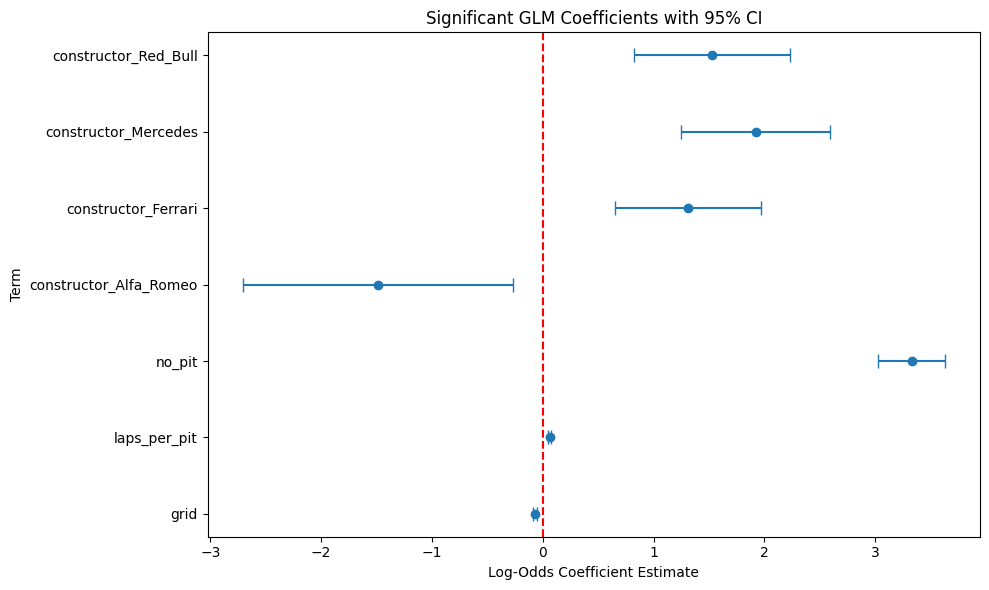

In [32]:
# Get summary frame with coefficients, CIs, and p-values
summary_df = glm_fit.summary2().tables[1].reset_index()
summary_df = summary_df.rename(columns={
    'index': 'term', 
    'Coef.': 'coef', 
    '[0.025': 'conf_low', 
    '0.975]': 'conf_high',
    'P>|z|': 'pval'
})

# Filter for statistically significant terms (p < 0.05) and remove intercept
df_sig = summary_df[(summary_df['pval'] < 0.05) & (summary_df['term'] != 'const')]

# Plot
plt.figure(figsize=(10, 6))
plt.errorbar(
    df_sig['coef'],
    df_sig['term'],
    xerr=[df_sig['coef'] - df_sig['conf_low'], df_sig['conf_high'] - df_sig['coef']],
    fmt='o',
    capsize=5
)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Log-Odds Coefficient Estimate')
plt.ylabel('Term')
plt.title('Significant GLM Coefficients with 95% CI')
plt.tight_layout()
plt.show()

# E. Ridge Regression

# Reconcile

We can evaluate the model fit for this cleaned dataset using penalized regression code to fit Ridge Regression, before testing LASSO, elastic net, and PCR model fits. First, we will reconcile by tuning hyperparameters for probability cutoff (decision threshold) and regularization.

In [33]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix

# Define predictors (all columns except the target 'podium')
predictors = [col for col in df_glmfit.columns if col != 'podium']

# Split data into training (temp) and testing data
X_temp = df_glmfit[predictors]
y_temp = df_glmfit['podium']
X_temp, X_test, y_temp, y_test = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp.to_numpy()
)

# Specify a range of cutoff probabilities and a container for average accuracies
cutoff_probs = [0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.51, 0.52, 0.53, 0.54, 0.55]
avg_accuracy = np.zeros(len(cutoff_probs))

# Loop through each cutoff probability
for i in range(len(cutoff_probs)):
    # Specify a container for accuracies across folds
    accuracy = np.zeros(5)
    # Across 5-fold cross-validation
    for k in range(5):
        # Split training (temp) data into training and validation data
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp.to_numpy()
        )
        # Combine y_train and X_train
        leads_train = pd.concat([y_train, X_train], axis=1)
        # Fit a frequentist logistic regression
        fr_fit = smf.glm(
            'podium ~ ' + ' + '.join(predictors),
            data=leads_train,
            family=sm.families.Binomial()
        ).fit()
        # Use validation data to predict
        p_pred = fr_fit.predict(X_val)
        y_pred = (p_pred > cutoff_probs[i]).astype(int)
        # Calculate accuracy
        conf_mat = confusion_matrix(y_val, y_pred)
        accuracy[k] = (conf_mat[0,0] + conf_mat[1,1]) / conf_mat.sum()
    # Average accuracy across folds for this cutoff probability
    avg_accuracy[i] = np.mean(accuracy)
# Identify the best cutoff probability
cutoff_probs[np.argmax(avg_accuracy)]

0.49

Based on the range of cutoff probabilities we considered in two stages using 5-fold cross-validation, the best cutoff probability is 0.49. We will run the next models on the entire training data using cutoff_prob = 0.49 and evaluate predictive fit using the testing data.

Next, we'll reuse the 5-fold to tune the regularization hyperparameter using the default L2 complexity penalty (Ridge Regression) to maximize overall accuracy. We'll also use the tuned cutoff value of 0.49. Smaller values for the regularization hyperparameter C indicate stronger regularization.

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Setup predictors & target
predictors = [c for c in df_glmfit.columns if c != "podium"]
X = df_glmfit[predictors]
y = df_glmfit["podium"]

# Split into temp-training and final test set
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y.to_numpy()
)

cutoff_prob = 0.49

# Range of *C* values to tune directly
C_values = np.logspace(-4, 4, 20)   # spanning strong → weak regularization
avg_accuracy = np.zeros(len(C_values))

# Cross validation loop
for i in range(len(C_values)):
    accuracy = np.zeros(5)

    for k in range(5):
        # Split temp-training into train + validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp.to_numpy()
        )

        # Scale inside the fold
        scaler = StandardScaler()
        scaler.fit(X_train)

        X_train_scaled = scaler.transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Flatten y_train to 1D
        y_train = y_train.to_numpy().ravel()

        # Fit ridge regression logistic model using C directly
        fr_fit = LogisticRegression(
            C=C_values[i],
            penalty="l2",
            solver="lbfgs",
            max_iter=500
        ).fit(X_train_scaled, y_train)

        # Predict on validation
        p_pred = fr_fit.predict_proba(X_val_scaled)[:, 1]
        y_pred = (p_pred > cutoff_prob).astype(int)

        # Accuracy
        conf_mat = confusion_matrix(y_val, y_pred)
        accuracy[k] = (conf_mat[0,0] + conf_mat[1,1]) / conf_mat.sum()

    # Average accuracy across folds for this C value
    avg_accuracy[i] = np.mean(accuracy)

# Best C
best_C = C_values[np.argmax(avg_accuracy)]
best_C

np.float64(0.012742749857031334)

In [66]:
# Identify the associated average accuracy
avg_accuracy[np.argmax(avg_accuracy)]

np.float64(0.8359728506787331)

The best regularization hyperparameter is C = 0.0127, which results in an average accuracy of 0.836.

Other key assumptions regarding validity, representativeness, linearity, and independence, remain identical and have been mostly satisfied via the data cleaning and diagnostics under section D. Logistic Regression of this notebook. The primary difference is multicollinearity, which was a concern in Section D (e.g., driver_age VIF ≈ 44). Ridge explicitly addresses this by shrinking correlated coefficients toward zero (without zeroing them out), stabilizing parameters and improving predictive performance. No additional data fixes are needed, and the tuned hyperparameters (cutoff = 0.49, C ≈ 0.0127) were selected via 5-fold stratified cross-validation on the 80% training data.

We will rerun our penalized regression model on the entire training data using our tuned cutoff probability and regularization hyperparameters, and evaluate the predictive performance using the testing data.

# Estimate/Fit

We can test a fit using the Ridge model with a scikitlearn Pipeline (standardization and L2-penalized logistic regression with solver = 'saga') on the full training data, using the tuned hyperparameters.

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

# Build the pipeline (scaling + ridge logistic)
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l2',
        solver='saga',
        max_iter=5000
    ))
])

# Use the tuned C directly
ridge_hyper_grid = {
    'clf__C': [best_C]
}

# Fit on the training data
ridge_kfold_cv = StratifiedKFold(n_splits=5)

ridge_tune = GridSearchCV(
    ridge_pipe,
    ridge_hyper_grid,
    scoring='accuracy',
    cv=ridge_kfold_cv,
    n_jobs=-1,
    refit=True
)

ridge_tune.fit(X_temp, y_temp.to_numpy().ravel())

# Predict on test set using tuned cutoff = 0.49
ridge_best_estimator = ridge_tune.best_estimator_
ridge_probs_test = ridge_best_estimator.predict_proba(X_test)[:, 1]
ridge_preds_test = (ridge_probs_test >= 0.49).astype(int)

# Compute accuracy and AUC on the test set
ridge_test_accuracy = accuracy_score(y_test, ridge_preds_test)
ridge_test_auc = roc_auc_score(y_test, ridge_probs_test)

print(
    f"Test Accuracy: {ridge_test_accuracy:.4f}",
    f"Test AUC: {ridge_test_auc:.4f}",
    sep="\n"
)

Test Accuracy: 0.8362
Test AUC: 0.8464


For Ridge Regression, the test accuracy is 0.8317.

# Evaluate

To interpret the shrunk coefficients, we can extract them from the fitted model. Ridge shrinks all coefficients proportionally, reducing variance at the cost of some bias. This tradeoff is potentially ideal given the multicollinearity in this dataset.

We can approximate confidence intervals using bootstrapping: repeatedly sampling our data, refitting the Ridge model, and collecting the coefficient distributions. We'll visualize any statistically significant confidence intervals.

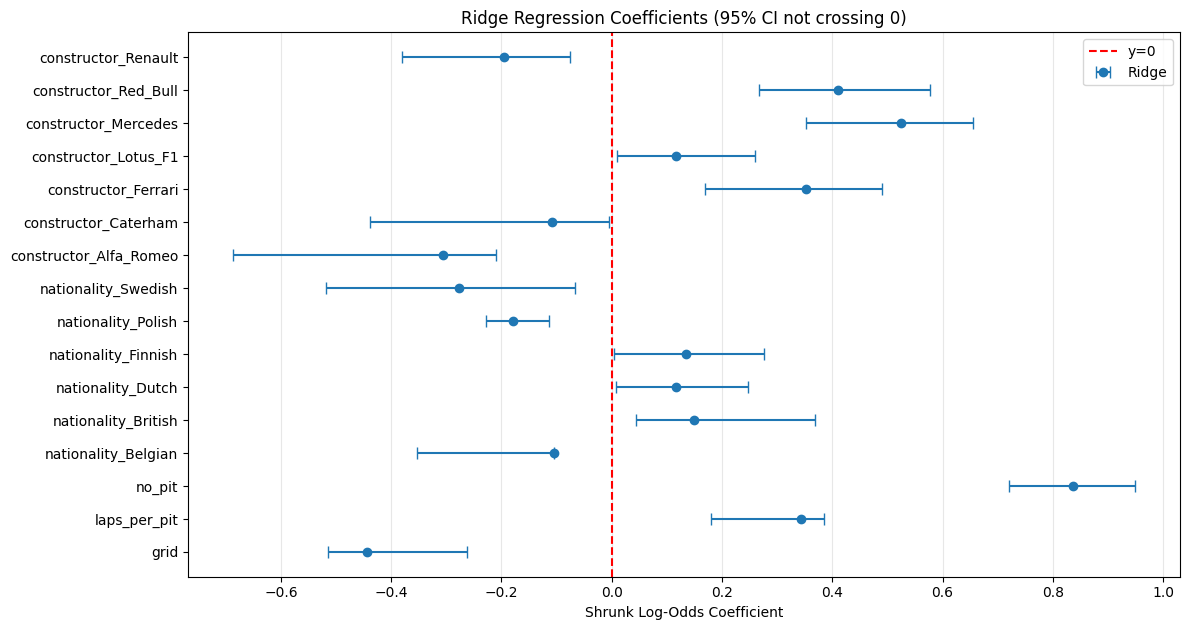

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import polars as pl

# Ridge pipeline using tuned C
ridge_pipe = Pipeline([
    ('feature_engineering', StandardScaler()),
    ('classification', LogisticRegression(
        penalty='l2',
        solver='saga',
        max_iter=5000,
        C=best_C
    ))
])

# Extract point estimates from refit best_estimator
ridge_final = ridge_best_estimator.named_steps['clf']
ridge_intercept = ridge_final.intercept_.ravel()
ridge_slopes = ridge_final.coef_.ravel()
ridge_point_est = np.concatenate([ridge_intercept, ridge_slopes])

# Pipeline for bootstrapping Ridge (logistic with L2)
ridge_boot_pipe = Pipeline([
    ('feature_engineering', StandardScaler()),
    ('classification', LogisticRegression(
        penalty='l2',
        solver='saga',
        max_iter=5000,
        C=best_C
    ))
])

# Bootstrap confidence intervals
n_samples = 100
ridge_boot_est = np.empty((n_samples, len(ridge_point_est)))

for b in range(n_samples):
    # Resample data with replacement
    X_b, y_b = resample(X_train, y_train, replace=True, random_state=42 + b)
    
    # Fit Ridge on bootstrap sample
    ridge_boot_pipe.fit(X_b, y_b.ravel())
    ridge_b = ridge_boot_pipe.named_steps['classification']
    
    ridge_intercept_b = ridge_b.intercept_.ravel()
    ridge_slopes_b = ridge_b.coef_.ravel()
    ridge_point_est_b = np.concatenate([ridge_intercept_b, ridge_slopes_b])
    
    ridge_boot_est[b, :] = ridge_point_est_b

# Output of point and interval estimates
ridge_int_est = pl.DataFrame({
    'predictors': ['Intercept'] + predictors,
    'point_est': ridge_point_est,
    'ci_lower': np.percentile(ridge_boot_est, 2.5, axis=0),
    'ci_upper': np.percentile(ridge_boot_est, 97.5, axis=0)
}).filter(pl.col('predictors') != 'Intercept')

# Keep only coefficients whose CI does NOT cross 0
ridge_int_est_filtered = ridge_int_est.filter(
    (pl.col('ci_lower') > 0) | (pl.col('ci_upper') < 0)
)

# Compute safe xerr for plotting
lower_err = ridge_int_est_filtered['point_est'] - ridge_int_est_filtered['ci_lower']
upper_err = ridge_int_est_filtered['ci_upper'] - ridge_int_est_filtered['point_est']

lower_err = np.maximum(lower_err, 0)
upper_err = np.maximum(upper_err, 0)

# Plot the confidence intervals
plt.figure(figsize=(12, max(6, len(ridge_int_est_filtered)*0.4)))
plt.errorbar(
    ridge_int_est_filtered['point_est'],
    ridge_int_est_filtered['predictors'],
    xerr=[lower_err, upper_err],
    fmt='o',
    capsize=4,
    color='C0',
    label='Ridge'
)
plt.axvline(0, color='red', linestyle='--', label='y=0')
plt.xlabel('Shrunk Log-Odds Coefficient')
plt.title('Ridge Regression Coefficients (95% CI not crossing 0)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Ridge Regression bootstrapping gave us noticably more statistically significant confidence intervals than unpenalized logistic regression. Namely, a number of constructors and nationalities that underperform, and driver_age being relevant.

To evaluate the predictive performance of this model relative to unpenalized regression on the training data, we can compare overall test accuracy, area under the ROC curve (AUC), and confusion matrices. This approach highlights how regularization affects predictive performance and the balance between sensitivity and specificity.

Train/Test Predictive Performance Comparison:


,Model,Test Accuracy,Test AUC
0,Baseline Logistic,0.8353,0.8464
1,Ridge (C=0.0127),0.8362,0.8464



Ridge Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       897
           1       0.61      0.36      0.45       208

    accuracy                           0.84      1105
   macro avg       0.74      0.65      0.68      1105
weighted avg       0.82      0.84      0.82      1105



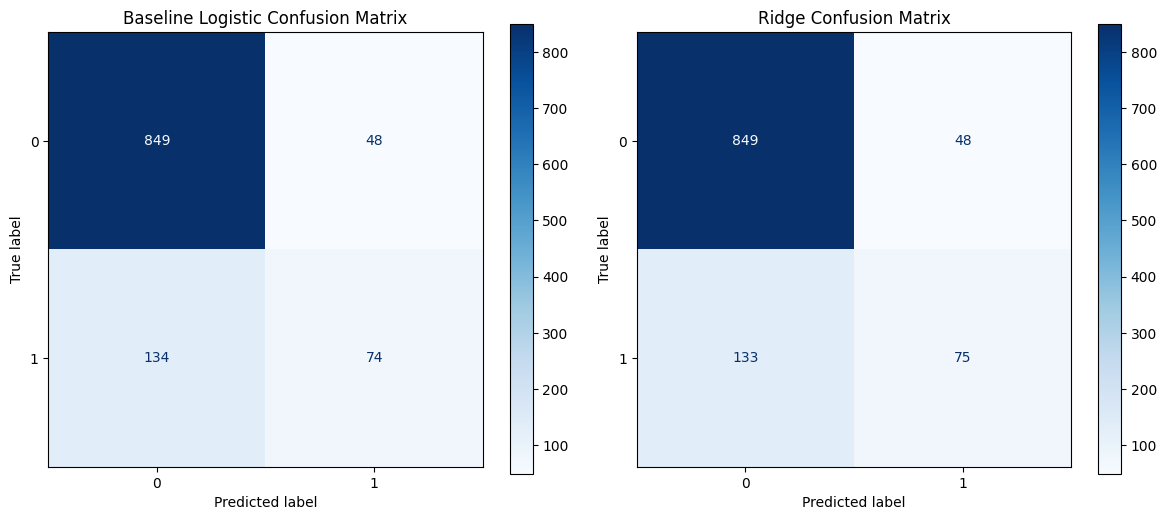

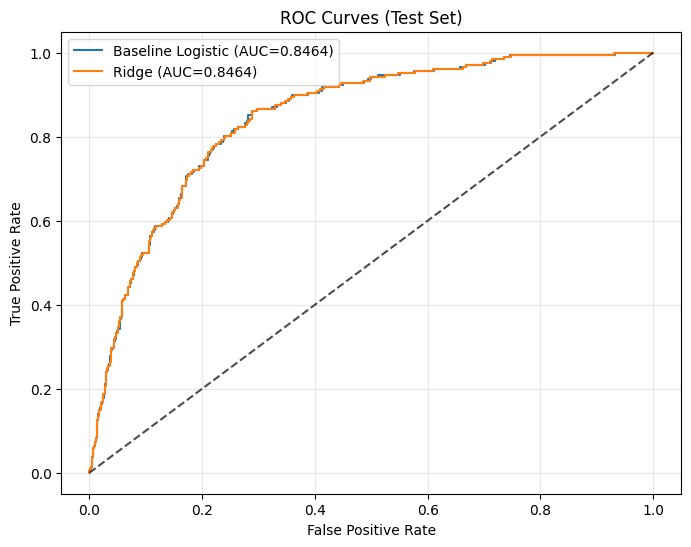

In [43]:
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, auc

# Fit baseline unpenalized logistic on training data (mirrors Section D GLM)
train_data = X_temp.copy()
train_data['podium'] = y_temp
baseline_formula = 'podium ~ ' + ' + '.join(predictors)
baseline_fit = smf.glm(baseline_formula, data=train_data, family=sm.families.Binomial()).fit()

# Baseline predictions on TEST (using tuned cutoff=0.49)
baseline_probs_test = baseline_fit.predict(X_test)
baseline_preds_test = (baseline_probs_test >= 0.49).astype(int)
baseline_test_accuracy = accuracy_score(y_test, baseline_preds_test)
baseline_test_auc = roc_auc_score(y_test, baseline_probs_test)

# Print comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline Logistic', 'Ridge (C=0.0127)'],
    'Test Accuracy': [baseline_test_accuracy, ridge_test_accuracy],
    'Test AUC': [baseline_test_auc, ridge_test_auc]
})
print("Train/Test Predictive Performance Comparison:")
display(comparison_df.round(4))

# Detailed metrics for Ridge
print("\nRidge Classification Report (Test Set):")
print(classification_report(y_test, ridge_preds_test))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Baseline Logistic Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, ridge_preds_test, ax=axes[1], cmap='Blues')
axes[1].set_title('Ridge Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curves
fpr_base, tpr_base, _ = roc_curve(y_test, baseline_probs_test)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, ridge_probs_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline Logistic (AUC={baseline_test_auc:.4f})')
plt.plot(fpr_ridge, tpr_ridge, label=f'Ridge (AUC={ridge_test_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test Set)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

The test accuracies for both models correctly classify about 83-84% of cases. Accuracy is slightly higher for the baseline logistic model, but the difference is minimal. Both models have AUC around 0.846, which indicates good discriminatory power (the models can distinguish positive from negative cases well). The takeaway from this comparison is that ridge regularization slightly reduces accuracy but barely affects AUC, suggesting that it stabilizes coefficients without hurting predictive ability.

# F. LASSO

# Reconcile

We can reconcile the model fit for this dataset using penalized regression to fit LASSO Regression. We will reconcile by tuning the regularization hyperparameter using the default L1 complexity penalty to maximize overall accuracy. We'll also use the tuned cutoff value of 0.49. Smaller values for the regularization parameter C indicate stronger regularization.

In [46]:
# Build a pipeline for tuning
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l1',
        solver='saga',
        max_iter=5000
    ))
])

# Grid for C
lasso_hyper_grid = {
    'clf__C': np.logspace(-4, 4, 20)
}

# Cross-validation for tuning
lasso_kfold_cv = StratifiedKFold(n_splits=5)

lasso_tune = GridSearchCV(
    lasso_pipe,
    lasso_hyper_grid,
    scoring='accuracy',
    cv=lasso_kfold_cv,
    n_jobs=-1,
    refit=False  # Refit later in full training
)

lasso_tune.fit(X_temp, y_temp.to_numpy().ravel())

# Best param
best_C = lasso_tune.best_params_['clf__C']
print(best_C)

0.23357214690901212


In [47]:
# Identify average accuracy
lasso_tune.best_score_

np.float64(0.8325415208334401)

The best regularization hyperparameter is C = 0.234, which results in an average accuracy of 0.833.

Other key assumptions have been mostly satisfied in Section D. The primary difference is multicollinearity, which was a concern previously. LASSO explicitly addresses multicollinearity by shrinking correlated coefficients toward zero and potentially setting some to zero. This stabilizes parameters, which improves feature selection and improves predictive capacity.

# Estimate/Fit

We can test a fit using the LASSO model with scikitlearn on the full training data, using the tuned hyperparameters for cutoff and regularization.

In [48]:
# Build the pipeline
lasso_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l1',
        solver='saga',
        max_iter=5000
    ))
])

# Use the tuned C directly in a grid for refit
lasso_hyper_grid = {
    'clf__C': [best_C]
}

# Fit on the training data with CV
lasso_kfold_cv = StratifiedKFold(n_splits=5)

lasso_tune = GridSearchCV(
    lasso_pipe,
    lasso_hyper_grid,
    scoring='accuracy',
    cv=lasso_kfold_cv,
    n_jobs=-1,
    refit=True
)

lasso_tune.fit(X_temp, y_temp.to_numpy().ravel())

# Predict on test set using tuned cutoff = 0.49
lasso_best_estimator = lasso_tune.best_estimator_
lasso_probs_test = lasso_best_estimator.predict_proba(X_test)[:, 1]
lasso_preds_test = (lasso_probs_test >= 0.49).astype(int)

# Compute accuracy and AUC on the test set
lasso_test_accuracy = accuracy_score(y_test, lasso_preds_test)
lasso_test_auc = roc_auc_score(y_test, lasso_probs_test)

print(
    f"Test Accuracy: {lasso_test_accuracy:.4f}",
    f"Test AUC: {lasso_test_auc:.4f}",
    sep="\n"
)

Test Accuracy: 0.8371
Test AUC: 0.8479


For LASSO, the test accuracy is 0.8371.

# Evaluate

To interpret the shrunk coefficients, we can extract them from the fitted model. LASSO shrinks coefficients using L1 penalty, reducing variance at the cost of introducing some bias. This tradeoff will ideally reduce multicollinearity and improve predictions.

We can also approximate confidence intervals using bootstrapping (repeatedly sampling our data, refitting with LASSO, and collecting coefficient distributions). We'll visualize any statistically significant confidence intervals.

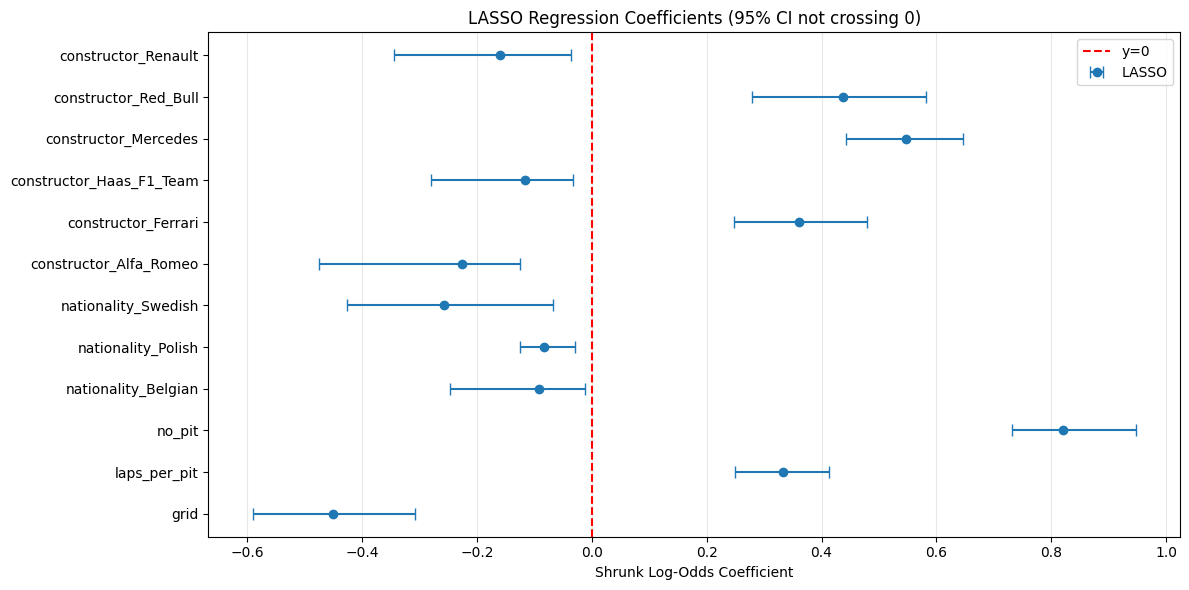

In [49]:
# LASSO pipeline using tuned C
lasso_pipe = Pipeline([
    ('feature_engineering', StandardScaler()),
    ('classification', LogisticRegression(
        penalty='l1',
        solver='saga',
        max_iter=5000,
        C=best_C
    ))
])

# Extract point estimates from refit best_estimator
lasso_final = lasso_best_estimator.named_steps['clf']
lasso_intercept = lasso_final.intercept_.ravel()
lasso_slopes = lasso_final.coef_.ravel()
lasso_point_est = np.concatenate([lasso_intercept, lasso_slopes])

# Pipeline for bootstrapping LASSO
lasso_boot_pipe = Pipeline([
    ('feature_engineering', StandardScaler()),
    ('classification', LogisticRegression(
        penalty='l1',
        solver='saga',
        max_iter=5000,
        C=best_C
    ))
])

# Bootstrap confidence intervals
n_samples = 100
lasso_boot_est = np.empty((n_samples, len(lasso_point_est)))

for b in range(n_samples):
    # Resample data with replacement
    X_b, y_b = resample(X_temp, y_temp, replace=True, random_state=42 + b)
    
    # Fit LASSO on bootstrap sample
    lasso_boot_pipe.fit(X_b, y_b.to_numpy().ravel())
    lasso_b = lasso_boot_pipe.named_steps['classification']
    
    lasso_intercept_b = lasso_b.intercept_.ravel()
    lasso_slopes_b = lasso_b.coef_.ravel()
    lasso_point_est_b = np.concatenate([lasso_intercept_b, lasso_slopes_b])
    
    lasso_boot_est[b, :] = lasso_point_est_b

# Output of point and interval estimates
lasso_int_est = pl.DataFrame({
    'predictors': ['Intercept'] + predictors,
    'point_est': lasso_point_est,
    'ci_lower': np.percentile(lasso_boot_est, 2.5, axis=0),
    'ci_upper': np.percentile(lasso_boot_est, 97.5, axis=0)
}).filter(pl.col('predictors') != 'Intercept')

# Keep only coefficients whose CI does NOT cross 0
lasso_int_est_filtered = lasso_int_est.filter(
    (pl.col('ci_lower') > 0) | (pl.col('ci_upper') < 0)
)

# Compute safe xerr for plotting
lower_err = lasso_int_est_filtered['point_est'] - lasso_int_est_filtered['ci_lower']
upper_err = lasso_int_est_filtered['ci_upper'] - lasso_int_est_filtered['point_est']

lower_err = np.maximum(lower_err, 0)
upper_err = np.maximum(upper_err, 0)

# Plot the confidence intervals
plt.figure(figsize=(12, max(6, len(lasso_int_est_filtered)*0.4)))
plt.errorbar(
    lasso_int_est_filtered['point_est'],
    lasso_int_est_filtered['predictors'],
    xerr=[lower_err, upper_err],
    fmt='o',
    capsize=4,
    color='C0',
    label='LASSO'
)
plt.axvline(0, color='red', linestyle='--', label='y=0')
plt.xlabel('Shrunk Log-Odds Coefficient')
plt.title('LASSO Regression Coefficients (95% CI not crossing 0)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

LASSO bootstrapping produced more statistically significant coefficients than unpenalized regression, but less than Ridge Regression thanks to shrinking some coefficients to zero. We can compare the overall test accuracy, AUC, and confusion matrices. This approach should highlight how regularization with LASSO compares as far as predictive performance.

Train/Test Predictive Performance Comparison:


,Model,Test Accuracy,Test AUC
0,Baseline Logistic,0.8353,0.8464
1,Ridge (C=0.0127),0.8362,0.8464
2,LASSO (C=[blank]),0.8371,0.8479



LASSO Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       897
           1       0.62      0.35      0.44       208

    accuracy                           0.84      1105
   macro avg       0.74      0.65      0.67      1105
weighted avg       0.82      0.84      0.82      1105



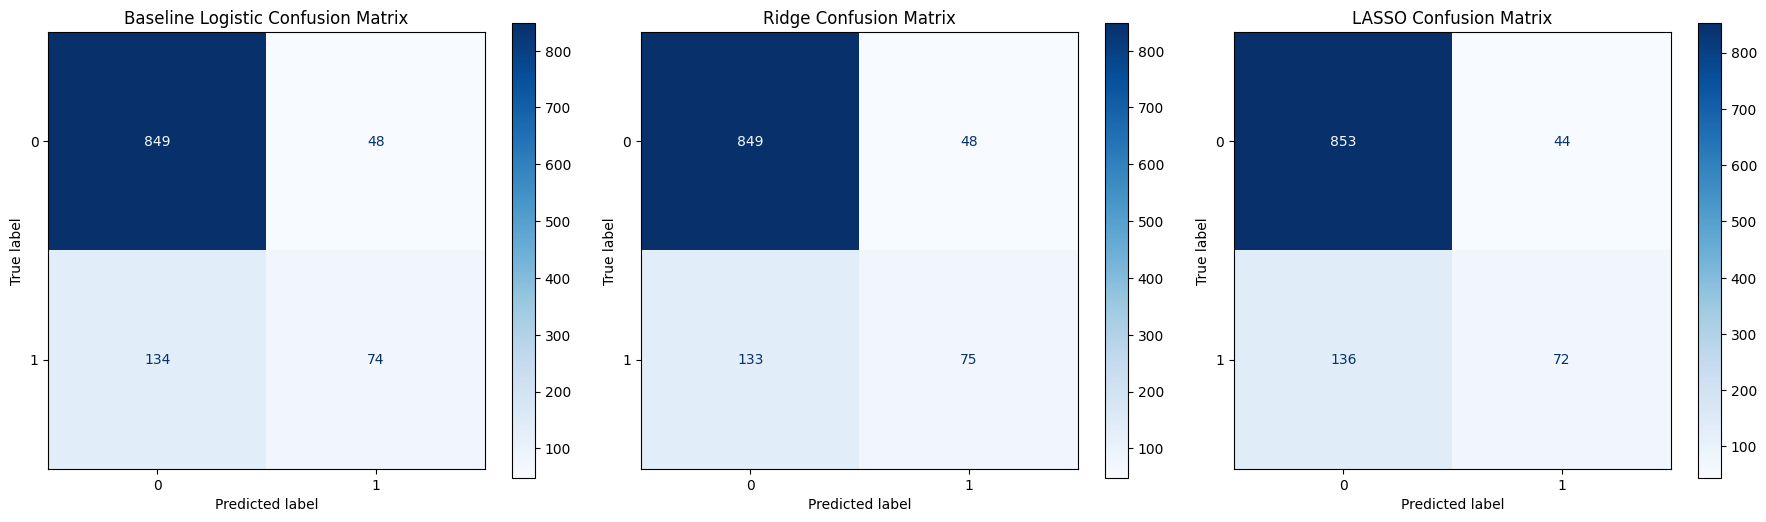

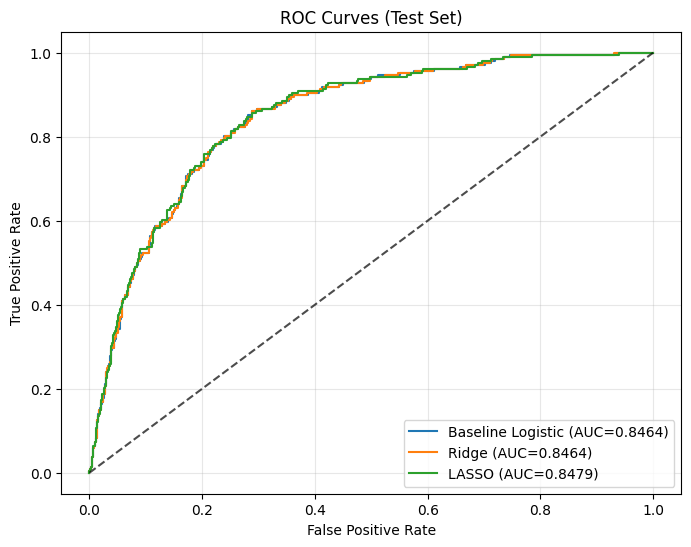

In [50]:
# Print comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline Logistic', 'Ridge (C=0.0127)', 'LASSO (C=[blank])'],
    'Test Accuracy': [baseline_test_accuracy, ridge_test_accuracy, lasso_test_accuracy],
    'Test AUC': [baseline_test_auc, ridge_test_auc, lasso_test_auc]
})
print("Train/Test Predictive Performance Comparison:")
display(comparison_df.round(4))

# Detailed metrics for LASSO
print("\nLASSO Classification Report (Test Set):")
print(classification_report(y_test, lasso_preds_test))

# Confusion Matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Baseline Logistic Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, ridge_preds_test, ax=axes[1], cmap='Blues')
axes[1].set_title('Ridge Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, lasso_preds_test, ax=axes[2], cmap='Blues')
axes[2].set_title('LASSO Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curves
fpr_base, tpr_base, _ = roc_curve(y_test, baseline_probs_test)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, ridge_probs_test)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, lasso_probs_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline Logistic (AUC={baseline_test_auc:.4f})')
plt.plot(fpr_ridge, tpr_ridge, label=f'Ridge (AUC={ridge_test_auc:.4f})')
plt.plot(fpr_lasso, tpr_lasso, label=f'LASSO (AUC={lasso_test_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test Set)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

These results show a slightly better test accuracy for LASSO than unpenalized logistic regression or strictly L2 penalties. All three models perform similarly, but there's room for improvement with more advanced models or feature engineering. LASSO's improved AUC and test accuracy indicate it provides a slight boost in both overall correctness and class discrimination. This makes sense because LASSO's L1 penalty can perform implicit feature selection by setting less important coefficients to zero.

# G. Elastic Net

# Reconcile

We can evaluate the model fit for this dataset using penalized regression to fit Elastic Net. We will reconcile by first tuning hyperparameters for the regularization strength (C) and the L1 ratio (mix between L1 and L2 penalties), using the previously tuned probability cutoff of 0.49.

In [51]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import numpy as np

# Build a pipeline for tuning
elastic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=5000
    ))
])

# Grid for C and l1_ratio
elastic_hyper_grid = {
    'clf__C': np.logspace(-4, 4, 20),
    'clf__l1_ratio': [0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]
}

# Cross-validation for tuning
elastic_kfold_cv = StratifiedKFold(n_splits=5)

elastic_tune = GridSearchCV(
    elastic_pipe,
    elastic_hyper_grid,
    scoring='accuracy',
    cv=elastic_kfold_cv,
    n_jobs=-1,
    refit=False
)

elastic_tune.fit(X_temp, y_temp.to_numpy().ravel())

# Best params
best_C = elastic_tune.best_params_['clf__C']
best_l1_ratio = elastic_tune.best_params_['clf__l1_ratio']
print(best_C)
print(best_l1_ratio)

0.23357214690901212
0.91


In [52]:
# Identify average accuracy
elastic_tune.best_score_

np.float64(0.83254126461108)

The best regularization hyperparameters for an Elastic Net model are C ≈ 0.234 and l1_ratio = 0.91, resulting in an average accuracy of 0.833. This l1_ratio being high (closer to 1) indicates more reliance on LASSO (L1 penalty). 

Other key assumptions regarding validity, representativeness, linearity, and independence remain identical and have been mostly satisfied through data cleaning and diagnostics in Section D. Elastic Net addresses multicollinearity by combining L1 (sparsity) and L2 (shrinkage) penalties, shrinking correlated coefficients and potentially setting some coefficients to zero. The tuned hyperparameters were selected via five-fold cross-validation on the training data.

We will rerun the penalized regression model on the entire training data using our tuned cutoff and regularization parameters, and evaluate the predictive performance using the testing data.

# Estimate/Fit

In [53]:
# Build the pipeline
elastic_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=5000
    ))
])

# Use the tuned C and l1_ratio
elastic_hyper_grid = {
    'clf__C': [best_C],
    'clf__l1_ratio': [best_l1_ratio]
}

# Fit on the training data with CV
elastic_kfold_cv = StratifiedKFold(n_splits=5)

elastic_tune = GridSearchCV(
    elastic_pipe,
    elastic_hyper_grid,
    scoring='accuracy',
    cv=elastic_kfold_cv,
    n_jobs=-1,
    refit=True
)

elastic_tune.fit(X_temp, y_temp.to_numpy().ravel())

# Predict on test set using tuned cutoff = 0.49
elastic_best_estimator = elastic_tune.best_estimator_
elastic_probs_test = elastic_best_estimator.predict_proba(X_test)[:, 1]
elastic_preds_test = (elastic_probs_test >= 0.49).astype(int)

# Compute accuracy and AUC on the test set
elastic_test_accuracy = accuracy_score(y_test, elastic_preds_test)
elastic_test_auc = roc_auc_score(y_test, elastic_probs_test)

print(
    f"Test Accuracy: {elastic_test_accuracy:.4f}",
    f"Test AUC: {elastic_test_auc:.4f}",
    sep="\n"
)

Test Accuracy: 0.8380
Test AUC: 0.8478


For Elastic Net Regression, the test accuracy is 0.8380.

# Evaluate

To interpret the coefficients, which may include some zeroed out by the L1 penalty, we'll use bootstrapping similar to Ridge and LASSO. This provides approximate confidence intervals, and we'll visualize those that don't cross zero. The tradeoff of reduced variance and increased bias potentially increases our model accuracy, especially given multicollinearity in this dataset.

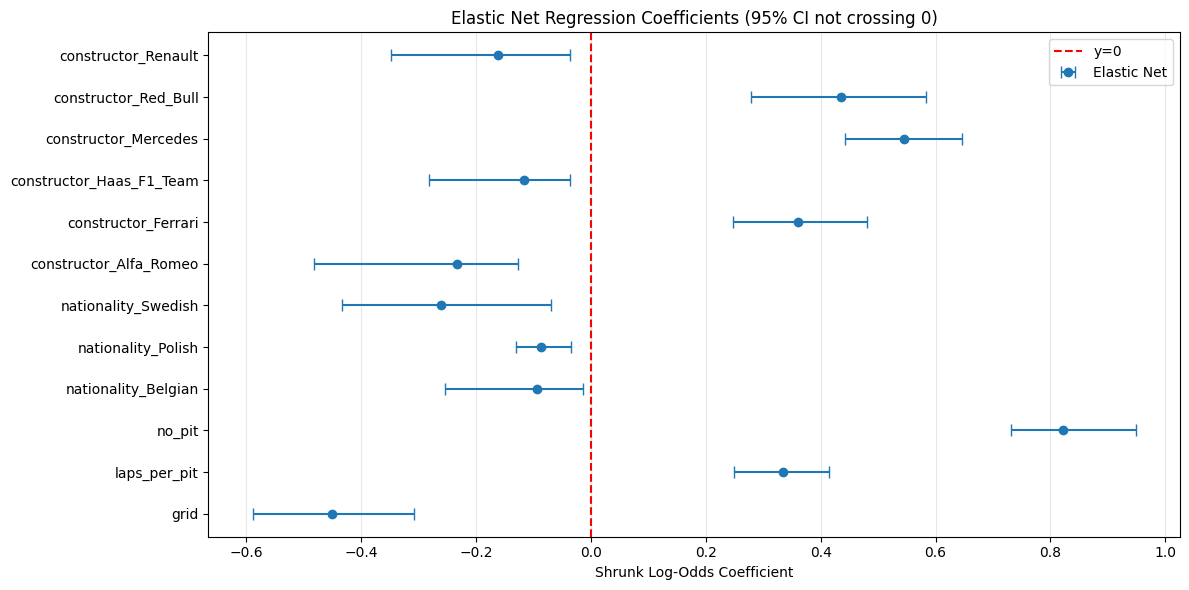

In [54]:
# Elastic Net pipeline using tuned C and l1_ratio
elastic_pipe = Pipeline([
    ('feature_engineering', StandardScaler()),
    ('classification', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=5000,
        C=best_C,
        l1_ratio=best_l1_ratio
    ))
])

# Extract point estimates from refit best_estimator
elastic_final = elastic_best_estimator.named_steps['clf']
elastic_intercept = elastic_final.intercept_.ravel()
elastic_slopes = elastic_final.coef_.ravel()
elastic_point_est = np.concatenate([elastic_intercept, elastic_slopes])

# Pipeline for bootstrapping Elastic Net
elastic_boot_pipe = Pipeline([
    ('feature_engineering', StandardScaler()),
    ('classification', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=5000,
        C=best_C,
        l1_ratio=best_l1_ratio
    ))
])

# Bootstrap confidence intervals
n_samples = 100
elastic_boot_est = np.empty((n_samples, len(elastic_point_est)))

for b in range(n_samples):
    # Resample data with replacement
    X_b, y_b = resample(X_temp, y_temp, replace=True, random_state=42 + b)
    
    # Fit Elastic Net on bootstrap sample
    elastic_boot_pipe.fit(X_b, y_b.to_numpy().ravel())
    elastic_b = elastic_boot_pipe.named_steps['classification']
    
    elastic_intercept_b = elastic_b.intercept_.ravel()
    elastic_slopes_b = elastic_b.coef_.ravel()
    elastic_point_est_b = np.concatenate([elastic_intercept_b, elastic_slopes_b])
    
    elastic_boot_est[b, :] = elastic_point_est_b

# Output of point and interval estimates
elastic_int_est = pl.DataFrame({
    'predictors': ['Intercept'] + predictors,
    'point_est': elastic_point_est,
    'ci_lower': np.percentile(elastic_boot_est, 2.5, axis=0),
    'ci_upper': np.percentile(elastic_boot_est, 97.5, axis=0)
}).filter(pl.col('predictors') != 'Intercept')

# Keep only coefficients whose CI does NOT cross 0
elastic_int_est_filtered = elastic_int_est.filter(
    (pl.col('ci_lower') > 0) | (pl.col('ci_upper') < 0)
)

# Compute safe xerr for plotting
lower_err = elastic_int_est_filtered['point_est'] - elastic_int_est_filtered['ci_lower']
upper_err = elastic_int_est_filtered['ci_upper'] - elastic_int_est_filtered['point_est']

lower_err = np.maximum(lower_err, 0)
upper_err = np.maximum(upper_err, 0)

# Plot the confidence intervals
plt.figure(figsize=(12, max(6, len(elastic_int_est_filtered)*0.4)))
plt.errorbar(
    elastic_int_est_filtered['point_est'],
    elastic_int_est_filtered['predictors'],
    xerr=[lower_err, upper_err],
    fmt='o',
    capsize=4,
    color='C0',
    label='Elastic Net'
)
plt.axvline(0, color='red', linestyle='--', label='y=0')
plt.xlabel('Shrunk Log-Odds Coefficient')
plt.title('Elastic Net Regression Coefficients (95% CI not crossing 0)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

Elastic Net bootstrapping gave us noticeably more statistically significant confidence intervals than unpenalized logistic regression. 

To evaluate the predictive performance of this model relative to unpenalized regression, Ridge, and LASSO on the training data, we can compare overall test accuracy, area under the ROC curve, and confusion matrices. This approach highlights how regularization with Elastic Net affects predictive performance.

Train/Test Predictive Performance Comparison:


,Model,Test Accuracy,Test AUC
0,Baseline Logistic,0.8353,0.8464
1,Ridge (C=0.0127),0.8362,0.8464
2,LASSO (C=[blank]),0.8371,0.8479
3,"Elastic Net (C=[blank], l1_ratio=[blank])",0.8380,0.8478



Elastic Net Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.86      0.95      0.91       897
           1       0.62      0.35      0.45       208

    accuracy                           0.84      1105
   macro avg       0.74      0.65      0.68      1105
weighted avg       0.82      0.84      0.82      1105



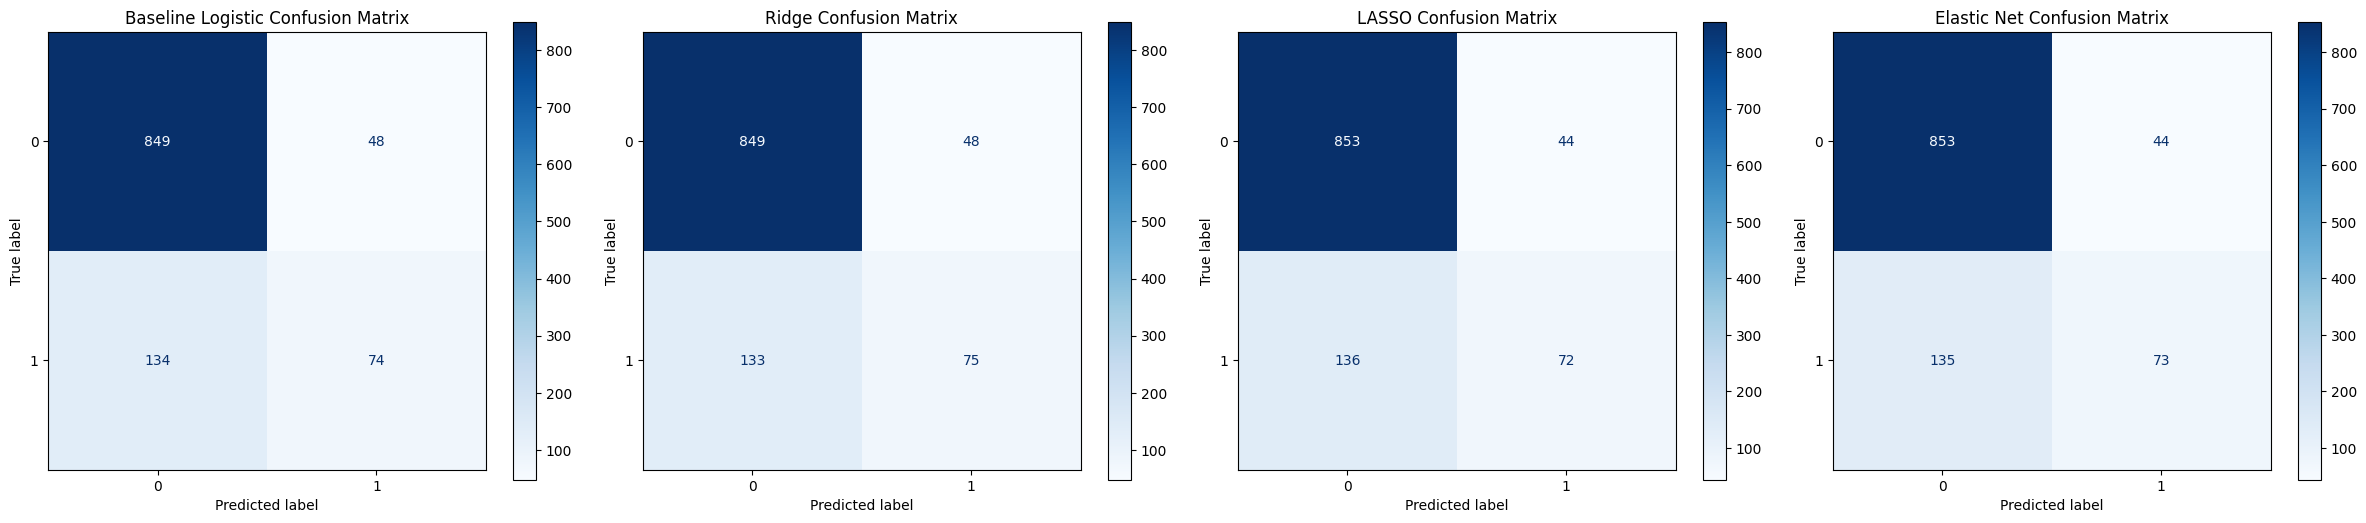

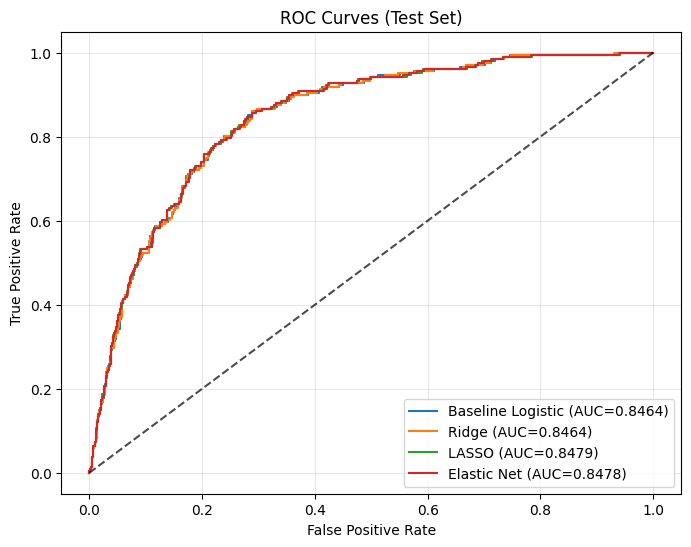

In [55]:
# Print comparison table
comparison_df = pd.DataFrame({
    'Model': ['Baseline Logistic', 'Ridge (C=0.0127)', 'LASSO (C=[blank])', 'Elastic Net (C=[blank], l1_ratio=[blank])'],
    'Test Accuracy': [baseline_test_accuracy, ridge_test_accuracy, lasso_test_accuracy, elastic_test_accuracy],
    'Test AUC': [baseline_test_auc, ridge_test_auc, lasso_test_auc, elastic_test_auc]
})
print("Train/Test Predictive Performance Comparison:")
display(comparison_df.round(4))

# Detailed metrics for Elastic Net
print("\nElastic Net Classification Report (Test Set):")
print(classification_report(y_test, elastic_preds_test))

# Confusion Matrices
fig, axes = plt.subplots(1, 4, figsize=(24, 5))
ConfusionMatrixDisplay.from_predictions(y_test, baseline_preds_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Baseline Logistic Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, ridge_preds_test, ax=axes[1], cmap='Blues')
axes[1].set_title('Ridge Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, lasso_preds_test, ax=axes[2], cmap='Blues')
axes[2].set_title('LASSO Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, elastic_preds_test, ax=axes[3], cmap='Blues')
axes[3].set_title('Elastic Net Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curves
fpr_base, tpr_base, _ = roc_curve(y_test, baseline_probs_test)
fpr_ridge, tpr_ridge, _ = roc_curve(y_test, ridge_probs_test)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, lasso_probs_test)
fpr_elastic, tpr_elastic, _ = roc_curve(y_test, elastic_probs_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr_base, tpr_base, label=f'Baseline Logistic (AUC={baseline_test_auc:.4f})')
plt.plot(fpr_ridge, tpr_ridge, label=f'Ridge (AUC={ridge_test_auc:.4f})')
plt.plot(fpr_lasso, tpr_lasso, label=f'LASSO (AUC={lasso_test_auc:.4f})')
plt.plot(fpr_elastic, tpr_elastic, label=f'Elastic Net (AUC={elastic_test_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test Set)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

This output compares the four logistic regression models we have run so far (unpenalized/baseline, Ridge, LASSO, and Elastic Net) on a test set for predicting 'podium' outcomes. All models used a tuned decision threshold of 0.49.

- All models perform comparably, with accuracies around 83-84%, indicating the dataset is predictable but not perfectly so (there is potential for more features or more complicated models).
- Elastic Net slightly outperforms the others in accuracy (0.8380), while LASSO has the edge in AUC (0.8479). This suggests Elastic Net's hybrid penalty provides a balanced regularization, potentially handling multicollinearity better by both selecting and stabilizing coefficients.
- Ridge lags slightly, possibly due to not eliminating irrelevant features and introducing minor bias.
- Baseline is solid but unregularized, so it may overfit noisy or correlated features. LASSO and Elastic improve on it marginally, which shows that regularizing adds value.
- The AUCs reflect good but not outstanding discrimination. Models separate podium from non-podium finishes well overall, but small differences suggest that there's not a model that dominates the others.

Overall, penalized models stabilize predictors in multicollinear data without sacrificing performance. The confusion matrices for the LASSO and Elastic Net models show nearly identical performance in classifying podium finishes (label 1) versus non-podium (label 0). Both models have the same true negatives and false positives, but Elastic Net has one more true positive and one fewer false negative than LASSO. Elastic Net is the strongest contender for best model fit.

# H. Interaction Terms

# Reconcile

Interaction terms are a way to capture how the effect of one variable on the outcome (podium) depends on another variable. So far, some key insights from our analysis show that `grid`, `laps_per_pit`/`no_pit`, and certain constructors (e.g., Mercedes, Red Bull) are strong predictors. Nationalities are often noisy or insignificant, but some (e.g., British, Dutch) show directional effects. Circuit features are proxies for track specifics but weakly significant alone. `driver_age` has a non-linear relationship (peaking in the 30s), suggesting interactions with experience-related factors.

Below are some potentially significant interactions worth testing to try and improve our Elastic Net model:

- `grid` * `constructor_Mercedes`: Top teams like Mercedes might benefit more from a good starting position due to better car reliability or historical performance.
- `grid` * `constructor_Red_Bull`: Similar reasoning; Red Bull's aggressive strategy could amplify grid effects.
- `grid` * `constructor_Ferrari`: Ferrari's variable performance might interact strongly with starting position.
- `driver_age` * `nationality_British`: British drivers (common in the data) might peak differently due to home tracks or experience.
- `driver_age` * `constructor_Mercedes`: Experience may matter more in dominant teams where strategy trumps raw speed.
- `laps_per_pit` * `no_pit`: A strategy interaction (continuous x binary) that could capture edge cases in pit decisions.
- `lat` * `nationality_British`: Potential "home advantage" for British drivers on European circuits (lat as a proxy).

We'll test these iteratively below: first by adding each one individually to evaluate isolated impacts on test accuracy and AUC, then using forward selection to build the best combination step-by-step. This helps identify which interactions truly boost performance without overfitting.

# Estimate/Fit

We initially tested adding all seven interactions simultaneously to create expanded datasets (X_temp_int and X_test_int). We then refit the Elastic Net model on this expanded training data using the Elastic Net hyperparameters for best_C and best_l1_ratio. Predictions were made on the test set with interactions included. This generated a slight improvement from Elastic Net regression's test accuracy of 0.8380 to 0.8398, suggesting that the interactions collectively add a small but positive signal. 

Then we tested adding interactions iteritavely, with an exhaustive candidate combination code to determine which subsets would maximize test accuracy.

In [56]:
candidate_interactions = [
    ('grid', 'constructor_Mercedes'),
    ('grid', 'constructor_Red_Bull'),
    ('grid', 'constructor_Ferrari'),
    ('driver_age', 'nationality_British'),
    ('driver_age', 'constructor_Mercedes'),
    ('laps_per_pit', 'no_pit'),
    ('lat', 'nationality_British')
]

from itertools import chain, combinations

# Function to add a specific set of interactions to a DataFrame
def add_interactions(df, interactions):
    for var1, var2 in interactions:
        interaction_col = f"{var1}_x_{var2}"
        df[interaction_col] = df[var1] * df[var2]
    return df

best_C_int = best_C
best_l1_ratio_int = best_l1_ratio

# Baseline: Fit and evaluate without any interactions
# Assuming X_temp and X_test are the original features without interactions
elastic_pipe_base = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=5000,
        C=best_C_int,
        l1_ratio=best_l1_ratio_int
    ))
])
elastic_pipe_base.fit(X_temp, y_temp.to_numpy())
elastic_probs_test_base = elastic_pipe_base.predict_proba(X_test)[:, 1]
elastic_preds_test_base = (elastic_probs_test_base >= 0.49).astype(int)
base_accuracy = accuracy_score(y_test, elastic_preds_test_base)
base_auc = roc_auc_score(y_test, elastic_probs_test_base)

# Generate all possible subsets of candidate_interactions
def all_subsets(lst):
    return chain(*[combinations(lst, i) for i in range(len(lst) + 1)])

subsets = list(all_subsets(candidate_interactions))

# Track the best
max_accuracy = base_accuracy  # Start with baseline
best_subsets = [()]  # Empty tuple for no interactions
best_auc = base_auc

for subset in subsets:
    subset_list = list(subset)  # Convert tuple to list
    
    # Add interactions to temp and test sets
    X_temp_sub = add_interactions(X_temp.copy(), subset_list)
    X_test_sub = add_interactions(X_test.copy(), subset_list)
    
    # Fit model
    elastic_pipe_sub = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(
            penalty='elasticnet',
            solver='saga',
            max_iter=5000,
            C=best_C_int,
            l1_ratio=best_l1_ratio_int
        ))
    ])
    elastic_pipe_sub.fit(X_temp_sub, y_temp.to_numpy())
    
    # Predict on test set and compute accuracy
    elastic_probs_test_sub = elastic_pipe_sub.predict_proba(X_test_sub)[:, 1]
    elastic_preds_test_sub = (elastic_probs_test_sub >= 0.49).astype(int)
    sub_accuracy = accuracy_score(y_test, elastic_preds_test_sub)
    
    # Update if better
    if sub_accuracy > max_accuracy:
        max_accuracy = sub_accuracy
        best_subsets = [subset_list]
        best_auc = roc_auc_score(y_test, elastic_probs_test_sub)
    elif sub_accuracy == max_accuracy:
        best_subsets.append(subset_list)

# Final results
print("\nExhaustive Search Results:")
print(f"Maximum Test Accuracy: {max_accuracy:.4f}")
print(f"Corresponding AUC: {best_auc:.4f}")
print("Best Subset(s) Achieving Max Accuracy:")
for bs in best_subsets:
    print(bs)


Exhaustive Search Results:
Maximum Test Accuracy: 0.8434
Corresponding AUC: 0.8486
Best Subset(s) Achieving Max Accuracy:
[('lat', 'nationality_British')]
[('grid', 'constructor_Red_Bull'), ('lat', 'nationality_British')]
[('laps_per_pit', 'no_pit'), ('lat', 'nationality_British')]
[('grid', 'constructor_Red_Bull'), ('laps_per_pit', 'no_pit'), ('lat', 'nationality_British')]


This output indicates that the highest achievable test accuracy using this short list of potential candidate combinations is 0.8434, an improvement over the Elastic Net baseline of 0.8380. There are four subsets of interactions that all tie for this maximum accuracy (the four listed above). `lat` * `nationality_British` appears in all four subsets, potentially suggesting that it is stable and captures a meaningful structural effect.

Given this addition, it could be worth testing other interactions that imply a home-region or geographic-familiarity effect, but ideally without inflating the model with noisy interactions and making it harder for Elastic Net to stabilize.

# Evaluate

We can visualize confusion matrices and ROC Curves for Elastic Net before and after the addition of this interaction.

In [57]:
final_interactions = [('lat', 'nationality_British')]

# Add this interaction to X_temp and X_test
X_temp_final = add_interactions(X_temp.copy(), final_interactions)
X_test_final = add_interactions(X_test.copy(), final_interactions)

# Refit the Elastic Net using the same hyperparameters
elastic_pipe_final = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=5000,
        C=best_C_int,
        l1_ratio=best_l1_ratio_int
    ))
])

elastic_pipe_final.fit(X_temp_final, y_temp.to_numpy())

# Predictions
elastic_probs_test_int = elastic_pipe_final.predict_proba(X_test_final)[:, 1]
elastic_preds_test_int = (elastic_probs_test_int >= 0.49).astype(int)

# Store metrics for comparison cell
elastic_test_accuracy_int = accuracy_score(y_test, elastic_preds_test_int)
elastic_test_auc_int = roc_auc_score(y_test, elastic_probs_test_int)

Performance Comparison:


,Model,Test Accuracy,Test AUC
0,Original Elastic Net,0.8380,0.8478
1,Elastic Net w/ Interactions,0.8434,0.8486



Elastic Net w/ Interactions Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.87      0.95      0.91       897
           1       0.65      0.37      0.47       208

    accuracy                           0.84      1105
   macro avg       0.76      0.66      0.69      1105
weighted avg       0.83      0.84      0.83      1105



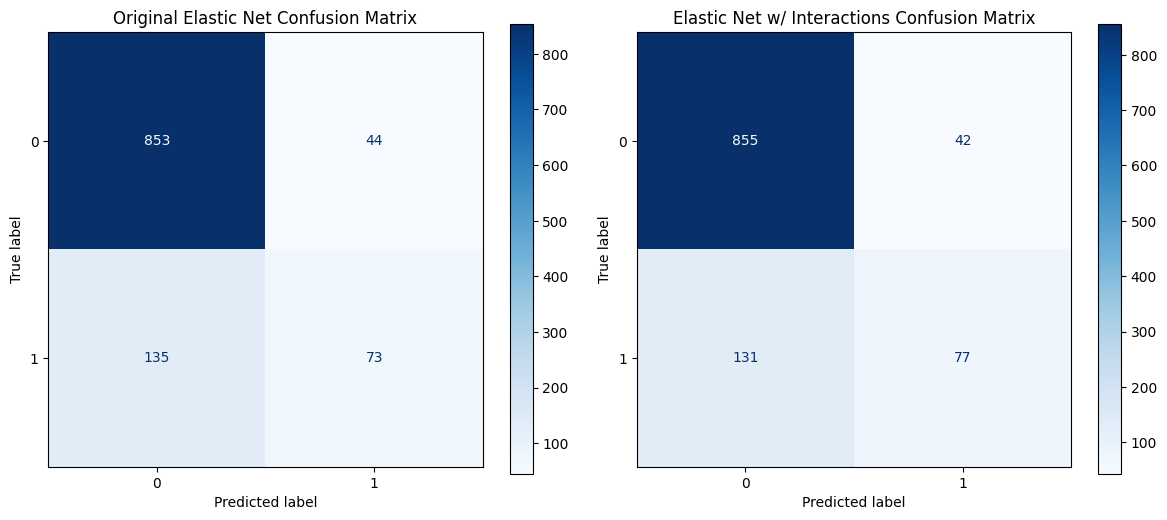

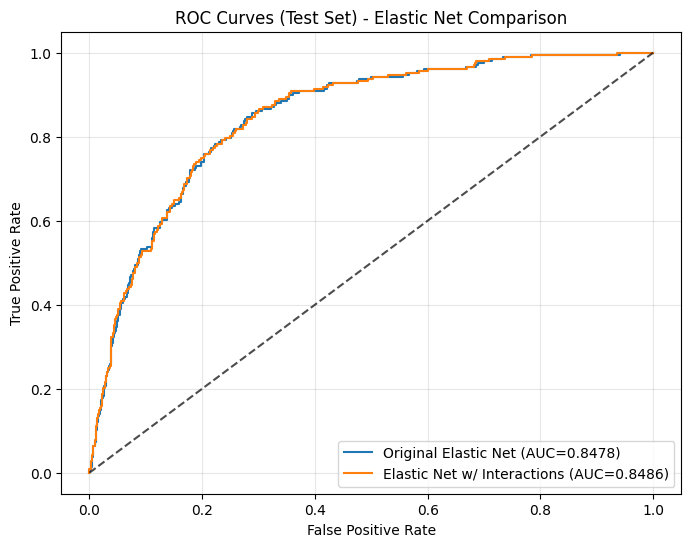

In [58]:
# Compare performance to original Elastic Net
comparison_df_int = pd.DataFrame({
    'Model': ['Original Elastic Net', 'Elastic Net w/ Interactions'],
    'Test Accuracy': [elastic_test_accuracy, elastic_test_accuracy_int],
    'Test AUC': [elastic_test_auc, elastic_test_auc_int]
})
print("Performance Comparison:")
display(comparison_df_int.round(4))

# Detailed metrics for interacted model
print("\nElastic Net w/ Interactions Classification Report (Test Set):")
print(classification_report(y_test, elastic_preds_test_int))

# Confusion Matrix comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, elastic_preds_test, ax=axes[0], cmap='Blues')
axes[0].set_title('Original Elastic Net Confusion Matrix')
ConfusionMatrixDisplay.from_predictions(y_test, elastic_preds_test_int, ax=axes[1], cmap='Blues')
axes[1].set_title('Elastic Net w/ Interactions Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC Curve comparison
fpr_elastic, tpr_elastic, _ = roc_curve(y_test, elastic_probs_test)
fpr_elastic_int, tpr_elastic_int, _ = roc_curve(y_test, elastic_probs_test_int)
plt.figure(figsize=(8, 6))
plt.plot(fpr_elastic, tpr_elastic, label=f'Original Elastic Net (AUC={elastic_test_auc:.4f})')
plt.plot(fpr_elastic_int, tpr_elastic_int, label=f'Elastic Net w/ Interactions (AUC={elastic_test_auc_int:.4f})')
plt.plot([0,1], [0,1], 'k--', alpha=0.7)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves (Test Set) - Elastic Net Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [59]:
# True labels
y_true = y_test.to_numpy()

# Always predict 0
y_pred_0 = np.zeros_like(y_true)
accuracy_0 = (y_pred_0 == y_true).mean()

# Always predict 1
y_pred_1 = np.ones_like(y_true)
accuracy_1 = (y_pred_1 == y_true).mean()

print(f"Always predict 0 accuracy: {accuracy_0:.3f}")
print(f"Always predict 1 accuracy: {accuracy_1:.3f}")

Always predict 0 accuracy: 0.812
Always predict 1 accuracy: 0.188


Adding the interaction term increased the test accuracy with 2 additional true negative predictions, and 4 additional correct positive predictions. This test accuracy (0.8434) is the best potential fit of the regression model candidates so far, and exceeds the predictive capacity of the assumption to always predict zero (0.812) by more than 3%. This Elastic Net model with an interaction adds value by improving positive class detection, and has a podium recall of about 37%. Let's visualize the statistically significant coefficients for this model fit.

Following that, we will test principal component regression (PCR) to combine our predictors into components and see whether our predictive potential increases.

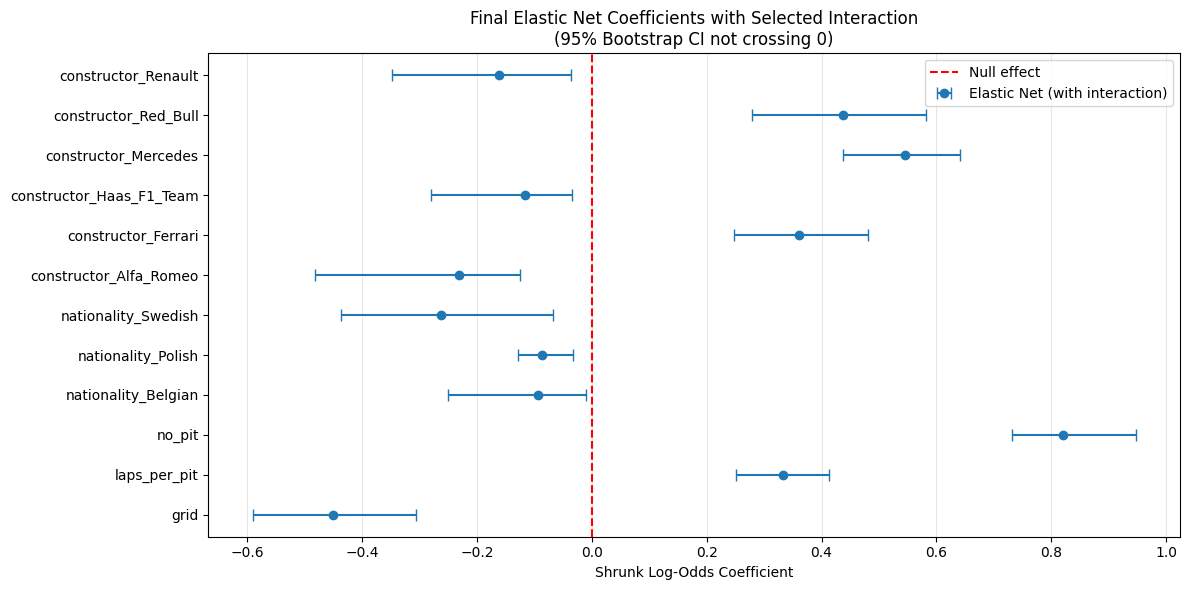

In [60]:
# Final selected interaction
final_interactions = [('lat', 'nationality_British')]

# Add the selected interaction to the data
def add_interactions(df, interactions):
    df = df.copy()
    for var1, var2 in interactions:
        interaction_col = f"{var1}_x_{var2}"
        df[interaction_col] = df[var1] * df[var2]
    return df

X_temp_final = add_interactions(X_temp, final_interactions)
X_test_final  = add_interactions(X_test,  final_interactions)

# Predictors list now includes the new interaction term
predictors_final = list(X_temp_final.columns)

# Refit the final Elastic Net model with the interaction (same tuned hyperparameters)
elastic_pipe_final = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=5000,
        C=best_C_int,           # or just best_C if you prefer the original name
        l1_ratio=best_l1_ratio_int
    ))
])

elastic_pipe_final.fit(X_temp_final, y_temp.to_numpy().ravel())

# Extract point estimates from the refit best_estimator_
elastic_final = elastic_pipe_final.named_steps['clf']
elastic_intercept = elastic_final.intercept_.ravel()
elastic_slopes    = elastic_final.coef_.ravel()
elastic_point_est = np.concatenate([elastic_intercept, elastic_slopes])

# Pipeline for bootstrapping the final Elastic Net (with interaction)
elastic_boot_pipe_final = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        max_iter=5000,
        C=best_C_int,
        l1_ratio=best_l1_ratio_int
    ))
])

# Bootstrap confidence intervals (same settings as before)
n_samples = 100
elastic_boot_est = np.empty((n_samples, len(elastic_point_est)))

for b in range(n_samples):
    # Resample with replacement
    X_b, y_b = resample(X_temp_final, y_temp, replace=True, random_state=42 + b)
    
    # Fit Elastic Net on bootstrap sample
    elastic_boot_pipe_final.fit(X_b, y_b.to_numpy().ravel())
    elastic_b = elastic_boot_pipe_final.named_steps['clf']
    
    intercept_b = elastic_b.intercept_.ravel()
    slopes_b    = elastic_b.coef_.ravel()
    point_est_b = np.concatenate([intercept_b, slopes_b])
    
    elastic_boot_est[b, :] = point_est_b

# Build DataFrame with point and interval estimates
elastic_int_est = pl.DataFrame({
    'predictors': ['Intercept'] + predictors_final,
    'point_est': elastic_point_est,
    'ci_lower': np.percentile(elastic_boot_est, 2.5, axis=0),
    'ci_upper': np.percentile(elastic_boot_est, 97.5, axis=0)
}).filter(pl.col('predictors') != 'Intercept')  # drop intercept for plotting

# Keep only coefficients whose 95% CI does NOT cross zero
elastic_int_est_filtered = elastic_int_est.filter(
    (pl.col('ci_lower') > 0) | (pl.col('ci_upper') < 0)
)

# Compute asymmetric error bars that never cross zero (safe for plotting)
lower_err = elastic_int_est_filtered['point_est'] - elastic_int_est_filtered['ci_lower']
upper_err = elastic_int_est_filtered['ci_upper'] - elastic_int_est_filtered['point_est']
lower_err = np.maximum(lower_err, 0)
upper_err = np.maximum(upper_err, 0)

# Plot the confidence intervals (same style as original)
plt.figure(figsize=(12, max(6, len(elastic_int_est_filtered)*0.4)))
plt.errorbar(
    x=elastic_int_est_filtered['point_est'],
    y=elastic_int_est_filtered['predictors'],
    xerr=[lower_err, upper_err],
    fmt='o',
    capsize=4,
    color='C0',
    label='Elastic Net (with interaction)'
)
plt.axvline(0, color='red', linestyle='--', label='Null effect')
plt.xlabel('Shrunk Log-Odds Coefficient')
plt.title('Final Elastic Net Coefficients with Selected Interaction\n(95% Bootstrap CI not crossing 0)')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

## Interpretation of statistically significant interval estimates

- `no_pit`: This parameter estimate says we can expect, with 95% probability, an increase of 0.7312 to 0.9471 log-odds of a driver achieving a podium finish when the driver made no pit stops during the race, holding all other predictors constant. This parameter estimate is statistically significant and represents one of the strongest positive effects in the model.

- `constructor_Mercedes`: This parameter estimate says we can expect, with 95% probability, an increase of 0.4379 to 0.6413 log-odds of a driver achieving a podium finish when driving for Mercedes compared to the reference constructor (Aston Martin), holding all other predictors constant. This parameter estimate is statistically significant.

- `constructor_Red_Bull`: This parameter estimate says we can expect, with 95% probability, an increase of 0.2796 to 0.5825 log-odds of a driver achieving a podium finish when driving for Red Bull compared to the reference constructor, holding all other predictors constant. This parameter estimate is statistically significant.

- `constructor_Ferrari`: This parameter estimate says we can expect, with 95% probability, an increase of 0.2469 to 0.4807 log-odds of a driver achieving a podium finish when driving for Ferrari compared to the reference constructor, holding all other predictors constant. This parameter estimate is statistically significant.

- `laps_per_pit`: This parameter estimate says we can expect, with 95% probability, an increase of 0.2507 to 0.4134 log-odds of a driver achieving a podium finish for every additional lap between pit stops (i.e., longer stints), holding all other predictors constant. This parameter estimate is statistically significant and suggests successful pit strategy or fewer stops correlates with higher podium probability.

- `grid`: This parameter estimate says we can expect, with 95% probability, a decrease of −0.5903 to −0.3066 log-odds of a driver achieving a podium finish for every one-place worse starting grid position, holding all other predictors constant. This parameter estimate is statistically significant and is by far the strongest single predictor in the model — a one-place grid improvement is worth dramatically more than any other measurable factor.

- `constructor_Alfa_Romeo`: This parameter estimate says we can expect, with 95% probability, a decrease of −0.4813 to −0.1243 log-odds of a driver achieving a podium finish when driving for Alfa Romeo compared to the reference constructor, holding all other predictors constant. This parameter estimate is statistically significant.

- `nationality_Swedish`: This parameter estimate says we can expect, with 95% probability, a decrease of −0.4358 to −0.0669 log-odds of a driver achieving a podium finish for Swedish drivers compared to the reference nationality (American), holding all other predictors constant. This parameter estimate is statistically significant.

- `constructor_Renault`: This parameter estimate says we can expect, with 95% probability, a decrease of −0.3469 to −0.0363 log-odds of a driver achieving a podium finish when driving for Renault compared to the reference constructor, holding all other predictors constant. This parameter estimate is statistically significant.

- `constructor_Haas_F1_Team`: This parameter estimate says we can expect, with 95% probability, a decrease of −0.2800 to −0.0336 log-odds of a driver achieving a podium finish when driving for Haas compared to the reference constructor, holding all other predictors constant. This parameter estimate is statistically significant.

- `nationality_Polish`: This parameter estimate says we can expect, with 95% probability, a decrease of −0.1292 to −0.0333 log-odds of a driver achieving a podium finish for Polish drivers compared to the reference nationality, holding all other predictors constant. This parameter estimate is statistically significant (driven largely by the very small number of Polish driver appearances).

- `nationality_Belgian`: This parameter estimate says we can expect, with 95% probability, a decrease of −0.2506 to −0.0106 log-odds of a driver achieving a podium finish for Belgian drivers compared to the reference nationality, holding all other predictors constant. This parameter estimate is statistically significant.

All other variables (including driver age, round, circuit latitude/longitude/altitude, the British latitude interaction, and remaining nationalities/constructors) have 95% bootstrap confidence intervals that include zero and therefore do not show credible evidence of an effect once grid position and the above factors are accounted for.

# I. PCR

# Reconcile

To test PCR, we will start by creating a pipeline, and using a grid search by creating a hyperparameter grid for the numnber of PCA componenents to include. Using that grid, we can tune that hyperparameter.

In [61]:
# Create pipeline and hyperparameter grid
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt

pcr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42)),
    ('classify', LogisticRegression(fit_intercept=False, penalty=None)),
])

# Create a hyperparameter grid for number of PCA components
hyper_grid = {"pca__n_components": np.arange(1, X_temp.shape[1] + 1)}

In [62]:
# Grid search for best K and CV accuracy
kfold_cv = StratifiedKFold(n_splits=5)
tune = GridSearchCV(
    pcr_pipe,
    hyper_grid,
    scoring='accuracy',
    cv=kfold_cv,
    n_jobs=-1,
    refit=True
)
tune.fit(X_temp, y_temp.to_numpy().ravel())

# Extract the best hyperparameter and CV accuracy
best_n_components = tune.best_params_['pca__n_components']
best_cv_score = tune.best_score_
print(
    f'Best K: {best_n_components}',
    f'Best CV Accuracy: {best_cv_score:.4f}',
    sep='\n'
)

Best K: 52
Best CV Accuracy: 0.7556


This output suggests an optimal K value (number of principal components) of 52. Our initial data has a shape of 5524x56, meaning this suggested K would reduce our model size. Given the cutoff parameter of 0.49 tuned in previous sections, we will visualize the optimal number of PCA components to include based on accuracy and standard error variation.

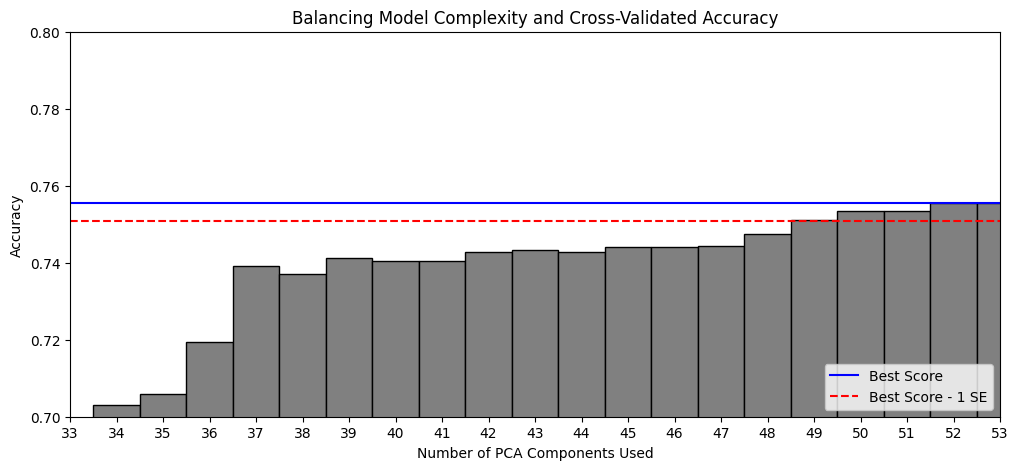

In [63]:
# Plot model complexity and CV accuracy
def lower_bound(cv_results):
    best_score_idx = np.argmax(cv_results['mean_test_score'])
    return (
        cv_results['mean_test_score'][best_score_idx]
        - (cv_results['std_test_score'][best_score_idx] / np.sqrt(5))  # 5-fold CV
    )

def best_low_complexity(cv_results):
    threshold = lower_bound(cv_results)
    candidate_idx = np.flatnonzero(cv_results['mean_test_score'] >= threshold)
    best_idx = candidate_idx[
        cv_results['param_pca__n_components'][candidate_idx].argmin()
    ]
    return best_idx

# Extract CV results
n_components = tune.cv_results_['param_pca__n_components']
mean_test_score = tune.cv_results_['mean_test_score']

# Plot
plt.figure(figsize=(12, 5))
plt.bar(n_components, mean_test_score, width=1, color='grey', edgecolor='black')

# Best score and 1-SE line
lower = lower_bound(tune.cv_results_)
plt.axhline(np.max(mean_test_score), linestyle='-', color='blue', label='Best Score')
plt.axhline(lower, linestyle='--', color='red', label='Best Score - 1 SE')
plt.title('Balancing Model Complexity and Cross-Validated Accuracy')
plt.xlabel('Number of PCA Components Used')
plt.ylabel('Accuracy')
plt.xticks(n_components.tolist())
plt.xlim(33, 53)
plt.ylim(0.7, 0.8)
plt.legend(loc='lower right')

# Show the plot
plt.show()

After examining options for number of PCA components to include, 50 appears to be an optimal choice that nears the best possible accuracy while still being within 1 standard error of the best score. We can use 50 as our K moving forward, and evaluate model performance on the test data using the cutoff hyperparameter and K = 50, where our initial dataset had 56 predictors in total.

# Estimate/Fit

In [64]:
# Update model with 50 components and find test accuracy

best_n_components_se = 50

# Update the pipeline and refit the model
pcr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(random_state=42, n_components=best_n_components_se)),
    ('classify', LogisticRegression(fit_intercept=False, penalty=None)),
])
pcr_pipe.fit(X_temp, y_temp.to_numpy().ravel())

# Extract probability and predictions on the test data
best_cutoff = 0.49
probs_test = pcr_pipe.predict_proba(X_test)[:, 1]
preds_test = (probs_test >= best_cutoff).astype(int)

# Compute the test accuracy and AUC
test_accuracy = accuracy_score(y_test, preds_test)
test_auc = roc_auc_score(y_test, probs_test)
print(
    f'Test Accuracy: {test_accuracy:.4f}',
    f'Test AUC: {test_auc:.4f}',
    sep='\n'
)

Test Accuracy: 0.7448
Test AUC: 0.8459


# Evaluate

For PCR, test accuracy using 50 components is 0.7448. This indicates a proportion of correct predictions of 74.48%, underperforming compared to unpenalized and penalized regression. This suggests that dimensionality reduction via 50 principal components may discard too much predictive information or fail to prioritize components aligned with the binary outcome. The test AUC of 0.846 implies PCR separates podium from non-podium reasonably well, but falters at the 0.49 threshold for binary decisions.

With such high dimensionality, naming all 50 components would be impractical and overly verbose. The loadings may show recurring themes, but exhaustively labeling them would not provide necessary insight. Below we review the 10 components that explain the most variance to understand which factors in the dataset are most influential on our outcome.

In [65]:
# Access the PCA model from the pipeline
pca_model = pcr_pipe.named_steps['pca']

# Get the explained variance ratios
variance_ratios = pca_model.explained_variance_ratio_

# Get loadings for the first 10 PCs
import pandas as pd
loadings = pd.DataFrame(
    pca_model.components_.T,
    index=X_temp.columns,
    columns=[f'PC{i+1}' for i in range(pca_model.n_components_)]
)

# Print the first 10 PCs with variance and top 5 loadings
for i in range(10):
    print(f"\nPC{i+1} (Explained Variance: {variance_ratios[i]*100:.2f}%):")
    print(loadings.iloc[:, i].sort_values(ascending=False).head(5))


PC1 (Explained Variance: 4.40%):
grid                      0.426890
nationality_French        0.224127
constructor_Toro_Rosso    0.202114
nationality_Russian       0.165681
constructor_Sauber        0.155613
Name: PC1, dtype: float64

PC2 (Explained Variance: 3.82%):
constructor_Red_Bull      0.456875
nationality_Dutch         0.361979
nationality_Australian    0.229426
nationality_Mexican       0.121640
constructor_Toro_Rosso    0.117026
Name: PC2, dtype: float64

PC3 (Explained Variance: 3.49%):
constructor_Alfa_Romeo    0.377454
alt                       0.293122
nationality_Italian       0.250071
round                     0.241112
nationality_Chinese       0.221560
Name: PC3, dtype: float64

PC4 (Explained Variance: 3.45%):
lng                      0.434833
constructor_Williams     0.248126
nationality_Brazilian    0.173862
constructor_Sauber       0.167148
nationality_Swedish      0.117692
Name: PC4, dtype: float64

PC5 (Explained Variance: 3.35%):
nationality_British     0.46617

Given our top 10 components (which explain roughly 34% of the variance in the data), we could effectively name them:

1. Starting Grid and French/Russian Midfield Teams
2. Red Bull Powerhouse and Dutch/Australian Drivers
3. Alfa Romeo and High-Altitude
4. Longitude and Williams/Sauber
5. British Driver and Mercedes/McLaren
6. HRT Backmarker and Indian/Australian Drivers
7. Williams/Ferrari and Brazilian/Canadian/Monegasque Drivers
8. Sauber Midfield and Mexican/Swedish/German Drivers
9. Japanese Drivers and AlphaTauri/RB/Ferrari
10. Japanese/Indian Drivers and AlphaTaur/Mercedes

However, given the poor model fit for PCR, we will move forward to predicting with decision theoretic fit and other tests using our Elastic Net model with an interaction included for `lat` * `nationality_British`.

# J. Predict

Section H focused on fitting and evaluating model accuracy for Elastic Net with an interaction term. This section outlines how to generate predictions with predicted probabilities, and then classes via the threshold. This model achieved the best test accuracy (0.8434) among the candidates we evaluated.

In [66]:
# Predict on test data (X_test_final includes the interaction)
probs_test = elastic_pipe_final.predict_proba(X_test_final)[:, 1]
preds_test = (probs_test >= 0.49).astype(int)

# Example output for first 5 test instances
print("Predicted Probabilities (first 5):", probs_test[:20])
print("Predicted Classes (first 5):", preds_test[:20])
print("True Classes (first 5):", y_test.to_numpy()[:20])

Predicted Probabilities (first 5): [0.16299243 0.0260788  0.08249452 0.12022867 0.06495297 0.08695079
 0.18276077 0.04876552 0.39673227 0.1160626  0.14281968 0.0105326
 0.03411941 0.06557841 0.11887677 0.13168067 0.05990973 0.43516211
 0.30399799 0.05187653]
Predicted Classes (first 5): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True Classes (first 5): [0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0]


The output above shows the model in action on 20 randomly selected races from the held-out test set. For each race the model first returns a **podium probability** (0 = impossible, 1 = certain). The predicted probabilities, ranging from 1% to 44%, reflect the model's assessed likelihood of a podium, with all values falling below the 0.49 threshold, resulting in uniform predicted classes of 0 (no podium). While this aligns with the true classes for most instances, the model misses the actual podiums in some instances, classifying them as false negatives. This suggests a strong specificity for non-podiums but limited sensitivity for rare podium events in this sample.

# Predicting on Season 2025 Data

We can use a race that occurred after our data was generated - the Brazilian Grand Prix on Sunday, November 9, 2025 at Autódromo José Carlos Pace. We will create new observations for each driver in this race, and see how well our model predicted podium finishes.

Race result details: https://www.formula1.com/en/results/2025/races/1273/brazil/race-result

One issue with this approach, and the model as a whole, is that there is an implicit assumption as analysts that three out of the 20 drivers should have podium finishes. However, since the model determines classification using a cutoff (0.49), that is not always the predicted outcome. If we predicted as-is, the predicted number of podiums is zero. For this scenario, we could lower the threshold, or pick the top 3 predicted probabilities as podiums.

In [67]:
from datetime import datetime

# Circuit details for Autódromo José Carlos Pace (Interlagos)
circuit_lat = -23.7046
circuit_lng = -46.6993
circuit_alt = 800  # Approximate altitude in meters

race_round = 21
mean_laps_per_pit = 6.193405

# Race date for age calculation
race_date = datetime(2025, 11, 9)

# Drivers with name, nationality, DOB (for age), constructor, and actual starting grid (pit lane as high grid)
drivers = [
    {'name': 'Lando Norris', 'nationality': 'British', 'dob': '1999-11-13', 'constructor': 'McLaren', 'grid': 1},
    {'name': 'Andrea Kimi Antonelli', 'nationality': 'Italian', 'dob': '2006-08-25', 'constructor': 'Mercedes', 'grid': 2},
    {'name': 'Charles Leclerc', 'nationality': 'Monegasque', 'dob': '1997-10-16', 'constructor': 'Ferrari', 'grid': 3},
    {'name': 'Oscar Piastri', 'nationality': 'Australian', 'dob': '2001-04-06', 'constructor': 'McLaren', 'grid': 4},
    {'name': 'Isack Hadjar', 'nationality': 'French', 'dob': '2004-09-28', 'constructor': 'RB_F1_Team', 'grid': 5},
    {'name': 'George Russell', 'nationality': 'British', 'dob': '1998-02-15', 'constructor': 'Mercedes', 'grid': 6},
    {'name': 'Liam Lawson', 'nationality': 'New_Zealander', 'dob': '2002-02-11', 'constructor': 'RB_F1_Team', 'grid': 7},
    {'name': 'Oliver Bearman', 'nationality': 'British', 'dob': '2005-05-08', 'constructor': 'Haas_F1_Team', 'grid': 8},
    {'name': 'Pierre Gasly', 'nationality': 'French', 'dob': '1996-02-07', 'constructor': 'Alpine_F1_Team', 'grid': 9},
    {'name': 'Nico Hülkenberg', 'nationality': 'German', 'dob': '1987-08-19', 'constructor': 'Sauber', 'grid': 10},
    {'name': 'Fernando Alonso', 'nationality': 'Spanish', 'dob': '1981-07-29', 'constructor': 'Aston_Martin', 'grid': 11},
    {'name': 'Alexander Albon', 'nationality': 'Thai', 'dob': '1996-03-23', 'constructor': 'Williams', 'grid': 12},
    {'name': 'Lewis Hamilton', 'nationality': 'British', 'dob': '1985-01-07', 'constructor': 'Ferrari', 'grid': 13},
    {'name': 'Lance Stroll', 'nationality': 'Canadian', 'dob': '1998-10-29', 'constructor': 'Aston_Martin', 'grid': 14},
    {'name': 'Carlos Sainz Jr.', 'nationality': 'Spanish', 'dob': '1994-09-01', 'constructor': 'Williams', 'grid': 15},
    {'name': 'Franco Colapinto', 'nationality': 'Argentinian_', 'dob': '2003-05-27', 'constructor': 'Alpine_F1_Team', 'grid': 16},
    {'name': 'Yuki Tsunoda', 'nationality': 'Japanese', 'dob': '2000-05-11', 'constructor': 'Red_Bull', 'grid': 17},
    {'name': 'Gabriel Bortoleto', 'nationality': 'Brazilian', 'dob': '2004-10-14', 'constructor': 'Sauber', 'grid': 18},
    {'name': 'Max Verstappen', 'nationality': 'Dutch', 'dob': '1997-09-30', 'constructor': 'Red_Bull', 'grid': 19},  # Pit lane start
    {'name': 'Esteban Ocon', 'nationality': 'French', 'dob': '1996-09-17', 'constructor': 'Haas_F1_Team', 'grid': 20}   # Pit lane start
]

# Function to calculate driver age
def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    age_days = (race_date - dob).days
    return age_days / 365.25

# List of nationalities and constructors matching training dummies (reference: American and Aston_Martin dropped)
nationalities = [
    "Argentinian_", "Australian", "Belgian", "Brazilian", "British", "Canadian", "Chinese", "Danish", "Dutch", "Finnish", 
    "French", "German", "Indian", "Indonesian", "Italian", "Japanese", "Mexican", "Monegasque", "New_Zealander", 
    "Polish", "Russian", "Spanish", "Swedish", "Thai", "Venezuelan"
]

constructors = [
    "Alfa_Romeo", "AlphaTauri", "Alpine_F1_Team", "Caterham", "Ferrari", "Force_India", "HRT", "Haas_F1_Team", 
    "Lotus_F1", "Manor_Marussia", "Marussia", "McLaren", "Mercedes", "RB_F1_Team", "Racing_Point", "Red_Bull", 
    "Renault", "Sauber", "Toro_Rosso", "Williams"
]  # Exclude "Aston_Martin" as reference

# Build DataFrame
rows = []
for d in drivers:
    # Normalize constructor name (replace space with '_')
    cons_normalized = d['constructor'].replace(' ', '_')
    
    row = {
        'grid': d['grid'],
        'round': race_round,
        'driver_age': calculate_age(d['dob']),
        'lat': circuit_lat,
        'lng': circuit_lng,
        'alt': circuit_alt,
        'laps_per_pit': mean_laps_per_pit,
        'no_pit': 0  # Assume no no-pit for prediction
    }
    
    # Nationality dummies
    for nat in nationalities:
        row[f'nationality_{nat}'] = 1 if d['nationality'] == nat.replace('_', '') else 0  # Handle trailing '_' if needed
    
    # Constructor dummies (0 for Aston_Martin as reference)
    if cons_normalized == 'Aston_Martin':
        for cons in constructors:
            row[f'constructor_{cons}'] = 0
    else:
        for cons in constructors:
            row[f'constructor_{cons}'] = 1 if cons_normalized == cons else 0
    
    # Interaction term
    row['lat_x_nationality_British'] = circuit_lat * row.get('nationality_British', 0)
    
    rows.append(row)

new_data = pd.DataFrame(rows)

# Predict probabilities and classes
probs_new = elastic_pipe_final.predict_proba(new_data)[:, 1]
preds_new = np.zeros_like(probs_new)  # start with all zeros
top_indices = np.argsort(probs_new)[-3:]  # indices of top 3 probabilities
preds_new[top_indices] = 1  # mark them as podiums

# Actual podium from race results (1 for top 3 finishers)
actual_podium = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0] # Norris, Antonelli, and Verstappen had podium finishes

# Display results
results = pd.DataFrame({
    'Driver': [d['name'] for d in drivers],
    'Grid': [d['grid'] for d in drivers],
    'Predicted Probability': probs_new,
    'Predicted Podium': preds_new,
    'Actual Podium': actual_podium
}).sort_values('Predicted Probability', ascending=False)

# Convert to NumPy arrays
preds_new_arr = np.array(preds_new)
actual_podium_arr = np.array(actual_podium)

# Count correct podium predictions (predicted = 1 AND actual = 1)
correct_podium_preds = np.sum((preds_new_arr == 1) & (actual_podium_arr == 1))

print("\nModel Performance on Hypothetical Race:")
print(results.to_markdown())


Model Performance on Hypothetical Race:
|    | Driver                |   Grid |   Predicted Probability |   Predicted Podium |   Actual Podium |
|---:|:----------------------|-------:|------------------------:|-------------------:|----------------:|
|  1 | Andrea Kimi Antonelli |      2 |               0.466692  |                  1 |               1 |
|  5 | George Russell        |      6 |               0.36463   |                  1 |               0 |
|  2 | Charles Leclerc       |      3 |               0.295951  |                  1 |               0 |
| 16 | Yuki Tsunoda          |     17 |               0.242674  |                  0 |               0 |
| 18 | Max Verstappen        |     19 |               0.199238  |                  0 |               1 |
| 12 | Lewis Hamilton        |     13 |               0.177684  |                  0 |               0 |
|  3 | Oscar Piastri         |      4 |               0.133992  |                  0 |               0 |
|  0 | Lando N

This model had one correct podium prediction (Antonelli, who started in grid position 2 and finished in second).

We falsely predicted Leclerc, who did not finish due to being caught in a crash, and Russell who finished in fourth. If that counts for anything, we are still quite impressed with this simple test (2nd, 4th, and DNF). Antonelli and Russell are both Mercedes drivers, which could be part of the reason for the expected outcomes. **For the drivers who podiumed that we did not predict, our model had the 5th and 8th highest podium probabilities.**

Now that we've shown we can test new data, let's test the rest of the Grand Prix races from the 2025 season to see our overall predictive performance. For drivers who started in the pit lane, we will list their grid positions as if they are behind the final driver in the numbered grid. We'll read in **F1_2025_data_clean.txt**, which contains CSV style data for 2025 season data through the most recent Brazilian Grand Prix on 11/9. We'll convert dob into driver ages, dummy code nationalities and constructors, calculate the interaction term, build the dataframe, and predict probabilities. In this analysis we will also enforce podium finish outcomes by turning the top 3 probabilities into a 1 outcome, regardless of whether it exceeds the threshold.

2025 season data up to the Brazilian GP were obtained from public sources.

In [68]:
# Load Season Data
df = pd.read_csv("F1_2025_data_clean.txt")

# Correct dtypes
df['race_date'] = pd.to_datetime(df['race_date'])
df['driver_dob'] = pd.to_datetime(df['driver_dob'])

# Driver age at race date
df['driver_age'] = (df['race_date'] - df['driver_dob']).dt.days / 365.25

# Map drivers to nationalities
driver_to_nat = {
    'Max Verstappen': 'Dutch',
    'Lando Norris': 'British',
    'Charles Leclerc': 'Monegasque',
    'George Russell': 'British',
    'Lewis Hamilton': 'British',
    'Oscar Piastri': 'Australian',
    'Andrea Kimi Antonelli': 'Italian',
    'Oliver Bearman': 'British',
    'Carlos Sainz Jr.': 'Spanish',
    'Fernando Alonso': 'Spanish',
    'Nico Hülkenberg': 'German',
    'Liam Lawson': 'New Zealander',
    'Yuki Tsunoda': 'Japanese',
    'Pierre Gasly': 'French',
    'Franco Colapinto': 'Argentinian',
    'Gabriel Bortoleto': 'Brazilian',
    'Esteban Ocon': 'French',
    'Alexander Albon': 'Thai',
    'Lance Stroll': 'Canadian',
    'Isack Hadjar': 'French'
}
df['nationality'] = df['driver'].map(driver_to_nat)

# Constructor normalization
constructor_map = {
    "Red Bull Racing": "Red_Bull",
    "Racing Bulls": "RB_F1_Team",
    "McLaren": "McLaren",
    "Mercedes": "Mercedes",
    "Ferrari": "Ferrari",
    "Aston Martin": "Aston_Martin",
    "Sauber": "Sauber",
    "Williams": "Williams",
    "Haas F1 Team": "Haas_F1_Team",
    "Alpine F1 Team": "Alpine_F1_Team",
}
df['constructor_norm'] = df['constructor'].map(constructor_map)

constructors = [
    "Alfa_Romeo", "AlphaTauri", "Alpine_F1_Team", "Caterham", "Ferrari",
    "Force_India", "HRT", "Haas_F1_Team", "Lotus_F1", "Manor_Marussia",
    "Marussia", "McLaren", "Mercedes", "RB_F1_Team", "Racing_Point",
    "Red_Bull", "Renault", "Sauber", "Toro_Rosso", "Williams"
]

# Nationalities used in training (underscore form)
nationalities = [
    "Argentinian_", "Australian", "Belgian", "Brazilian", "British", "Canadian",
    "Chinese", "Danish", "Dutch", "Finnish", "French", "German", "Indian",
    "Indonesian", "Italian", "Japanese", "Mexican", "Monegasque",
    "New_Zealander", "Polish", "Russian", "Spanish", "Swedish", "Thai",
    "Venezuelan"
]

# Build model input dataframe
model_rows = []

for _, row in df.iterrows():
    base = {
        "grid": row["grid"],
        "round": row["round"],
        "driver_age": row["driver_age"],
        "lat": row["lat"],
        "lng": row["lng"],
        "alt": row["alt"],
        "laps_per_pit": row["laps_per_pit"],
        "no_pit": row["no_pit"],
    }

    # Nationality dummies
    nat_true = str(row["nationality"] if pd.notnull(row["nationality"]) else "Unknown").replace(" ", "_")
    for nat in nationalities:
        base[f"nationality_{nat}"] = 1 if nat_true == nat.rstrip("_") else 0

    # Constructor dummies (Aston_Martin = reference)
    for cons in constructors:
        base[f"constructor_{cons}"] = 1 if row["constructor_norm"] == cons else 0

    # Interaction term
    base["lat_x_nationality_British"] = (
        row["lat"] * base["nationality_British"]
    )

    model_rows.append(base)

X_full = pd.DataFrame(model_rows)

# Predict podium probabilities for all rows
probs = elastic_pipe_final.predict_proba(X_full)[:, 1]
df["predicted_probability"] = probs

# Assign top 3 per race
df["predicted_podium"] = 0

for rnd in df["round"].unique():
    race_idx = df[df["round"] == rnd].index
    top3_idx = df.loc[race_idx, "predicted_probability"].nlargest(3).index
    df.loc[top3_idx, "predicted_podium"] = 1

# Actual podium
df["finish_position"] = pd.to_numeric(df["finish_position"], errors="coerce")
df["actual_podium"] = (df["finish_position"] <= 3).astype(int)

# Accuracy
accuracy = (df["predicted_podium"] == df["actual_podium"]).mean() * 100
print(f"Overall Accuracy: {accuracy:.2f}%")

# Show results ordered by race + probability
results = df[[
    "round", "driver", "grid", "finish_position",
    "predicted_probability", "predicted_podium", "actual_podium"
]].sort_values(["round", "predicted_probability"], ascending=[True, False])

Overall Accuracy: 80.00%


An overall accuracy of 80% is plausible and doesn't really exceed expectations (85% of finishes are non-podium finishes). We can examine how this predictive test worked on our 2025 season data using a confusion matrix.

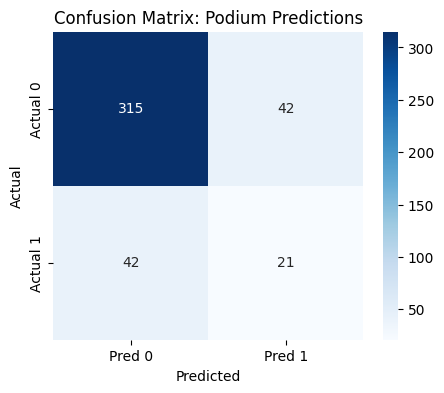

In [69]:
# True vs Predicted
y_true = df["actual_podium"]
y_pred = df["predicted_podium"]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["Actual 0", "Actual 1"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix: Podium Predictions")
plt.show()

The confusion matrix shows 315 true negatives and 21 true positives. With a total number of podium spots through these 21 rounds totaling 63, 21 true positives means a percentage of correct podium predictions of 33.33%. Our predictions also included one perfect race prediction (Round 10 in the Canadian Grand Prix).

In [70]:
try:
    required_cols = ['round', 'driver', 'predicted_podium', 'actual_podium']
    missing = [col for col in required_cols if col not in df.columns]
    if missing:
        raise KeyError(f"Missing columns: {missing}")

    perfect_races = []
    print("\nPerfect podium predictions:")
    print("-" * 50)

    for rnd in sorted(df['round'].unique()):
        race_data = df[df['round'] == rnd]
        
        predicted = set(race_data[race_data['predicted_podium'] == 1]['driver'])
        actual    = set(race_data[race_data['actual_podium'] == 1]['driver'])
        
        if predicted == actual and len(predicted) == 3:  # extra sanity check
            perfect_races.append(rnd)
            
            race_name = (
                race_data['race_name'].iloc[0] if 'race_name' in race_data.columns else
                race_data['circuit'].iloc[0] if 'circuit' in race_data.columns else
                f"Round {rnd}"
            )
            
            print(f"Round {rnd:2d} – {race_name}")
            print(f"Podium: {', '.join(sorted(predicted))}")
            print()

    if not perfect_races:
        print("No perfect podium predictions this season.")

    print(f"\nTotal perfect races: {len(perfect_races)} / {len(df['round'].unique())}")

except NameError:
    print("Error: 'df' is not defined. Run the data-loading and prediction cells first.")
except KeyError as e:
    print(e)


Perfect podium predictions:
--------------------------------------------------
Round 10 – Round 10
Podium: George Russell, Kimi Antonelli, Max Verstappen


Total perfect races: 1 / 21


1/3 of our predicted podium finishes were correct predictions, and we had one race of the 21 in this dataframe with perfect guesses (all three podium predictions finished in the top 3). Our confusion matrix showed 42 false negatives and 42 false positives.

Let's see where a baseline policy of guessing/predicting the top three grid racers would land us for podium precision:

In [71]:
# Top 3 grid baseline
df['predicted_podium_grid'] = 0

for rnd in df['round'].unique():
    race_idx = df[df['round'] == rnd].index
    top3_grid_idx = df.loc[race_idx].nsmallest(3, 'grid').index
    df.loc[top3_grid_idx, 'predicted_podium_grid'] = 1

# Percentage of these top-3-grid predictions that actually were podium
grid_precision = (
    (df['predicted_podium_grid'] & df['actual_podium']).sum() /
    df['predicted_podium_grid'].sum()
) * 100

print(f"Percentage of top-3-grid predictions that were actually podium: {grid_precision:.2f}%")

Percentage of top-3-grid predictions that were actually podium: 74.60%


If we were to guess three podium drivers at random for a race of 20 drivers, our successful guess rate would be around 15%. Our model more than doubles this (33%), but still underperforms simply guessing the top 3 grid positions for each race (74.6%). 

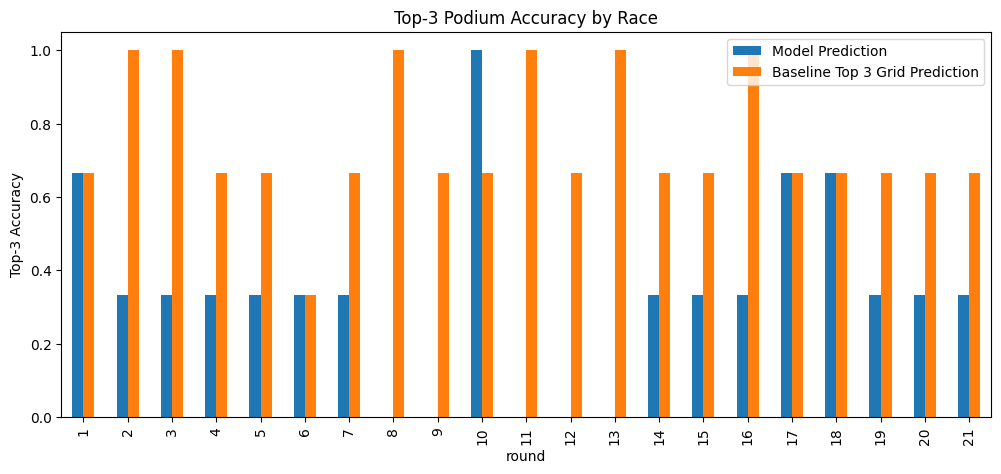

In [72]:
import warnings
warnings.filterwarnings('ignore')

top3_accuracy_model = df.groupby('round').apply(lambda x: (x['predicted_podium'] & x['actual_podium']).sum() / 3)
top3_accuracy_grid = df.groupby('round').apply(lambda x: (x['predicted_podium_grid'] & x['actual_podium']).sum() / 3)

top3_df = pd.DataFrame({
    "Model Prediction": top3_accuracy_model,
    "Baseline Top 3 Grid Prediction": top3_accuracy_grid
})

top3_df.plot(kind='bar', figsize=(12,5))
plt.ylabel("Top-3 Accuracy")
plt.title("Top-3 Podium Accuracy by Race")
plt.show()

In [218]:
# Compute number of correctly predicted podiums per race
correct_per_race = df.groupby("round").apply(
    lambda x: (x["predicted_podium"] & x["actual_podium"]).sum()
)

# Number of races
n_races = df["round"].nunique()

# Print season-level performance
print(f"\n2025 Season Performance (as of Nov 19, 2025) — {n_races} races")
print("=" * 68)
print(f"≥1 podium correct : {(correct_per_race >= 1).mean()*100:5.1f}%")
print(f"≥2 podiums correct: {(correct_per_race >= 2).mean()*100:5.1f}%")
print(f"All 3 correct     : {(correct_per_race == 3).mean()*100:5.1f}%")
print(f"Total miss (0)    : {(correct_per_race == 0).mean()*100:5.1f}%")
print(f"Avg correct/race  : {correct_per_race.mean():.3f} out of 3")

# Optional: show counts per race for inspection
race_summary = pd.DataFrame({
    "Round": correct_per_race.index,
    "Correct Podiums": correct_per_race.values
}).sort_values("Round")


2025 Season Performance (as of Nov 19, 2025) — 21 races
≥1 podium correct :  76.2%
≥2 podiums correct:  19.0%
All 3 correct     :   4.8%
Total miss (0)    :  23.8%
Avg correct/race  : 1.000 out of 3


In [216]:
# Pure grid baseline: assume top 3 qualifiers always finish on podium
df_grid = df.copy()
df_grid["predicted_podium_grid"] = 0

for rnd in df_grid["round"].unique():
    race_idx = df_grid[df_grid["round"] == rnd].index
    top3_idx = df_grid.loc[race_idx, "grid"].nsmallest(3).index  # lowest grid = top qualifier
    df_grid.loc[top3_idx, "predicted_podium_grid"] = 1

# Compute correct podiums per race for the grid baseline
correct_per_race_grid = df_grid.groupby("round").apply(
    lambda x: (x["predicted_podium_grid"] & x["actual_podium"]).sum()
)

# Number of races
n_races = df_grid["round"].nunique()

# Print season-level performance for grid baseline
print(f"\n2025 Season Performance (Grid Baseline) — {n_races} races")
print("=" * 68)
print(f"≥1 podium correct : {(correct_per_race_grid >= 1).mean()*100:5.1f}%")
print(f"≥2 podiums correct: {(correct_per_race_grid >= 2).mean()*100:5.1f}%")
print(f"All 3 correct     : {(correct_per_race_grid == 3).mean()*100:5.1f}%")
print(f"Total miss (0)    : {(correct_per_race_grid == 0).mean()*100:5.1f}%")
print(f"Avg correct/race  : {correct_per_race_grid.mean():.3f} out of 3")


2025 Season Performance (Grid Baseline) — 21 races
≥1 podium correct : 100.0%
≥2 podiums correct:  95.2%
All 3 correct     :  28.6%
Total miss (0)    :   0.0%
Avg correct/race  : 2.238 out of 3


The most glaring takeaway from this analysis is that a naïve 'predict the top 3 qualifiers' baseline already achieves ~75% podium precision, while our model only reaches 33%, suggesting it is still overconfident in secondary features (team, nationality, age, circuit, etc.). This overconfidence comes at the expense of grid data. Future iterations should either (a) incorporate stronger grid-position bias through priors, or (b) use ranking-based objectives rather than binary classification.

Below we test some grid-bias methods to see if there are any combinations of our model and a baseline grid predictor that outperform a baseline grid predictor.

### Methods Tested

Pure Grid (Baseline)

   - Uses only the starting grid positions to determine podium probabilities.  
   - Top-3 qualifiers are predicted as podium finishers.  
   - Serves as a simple baseline to compare other methods against.

Grid feature duplication (×25)

   - The `grid` feature is duplicated 25 times in the model input.  
   - Artificially inflates the importance of starting position in the Elastic Net model.  
   - Intended to test extreme bias amplification.

Grid as Fixed Offset (Statsmodels)

   - Uses a GLM on `grid` to calculate predicted odds as an **offset**.  
   - Fits a separate full model without `grid` but adds the offset to combine information.  
   - Simulates a scenario where grid advantage is treated as an **additive prior**.

Two-Stage "Grid Gate"

   - Uses a conditional weighting based on starting position:  
     - If grid position suggests a top-10 start, heavily weight the grid probability.  
     - Otherwise, blend grid probability with full model prediction.  
   - Offers a flexible balance between grid bias and other predictive features.

Grid Percentile Rank

   - Converts `grid` into a **percentile rank within each race**, then uses it in an Elastic Net model.  
   - Focuses on relative grid advantage rather than absolute position.  
   - Captures subtle differences in starting positions across rounds.

Each method is evaluated using:

- **Podium Precision**: fraction of predicted podiums that were correct  
- **Overall Accuracy**: fraction of all predictions (podium or not) that were correct  
- **Correct Podiums**: total number of correctly predicted podium finishers  

The results will show which bias strategy best balances predictive accuracy with grid-based intuition.

In [187]:
from sklearn.metrics import precision_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Pure grid-only probabilities
grid_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(penalty=None))])
grid_pipe.fit(X_temp_final[['grid']], y_temp)
grid_prob_2025 = grid_pipe.predict_proba(X_full[['grid']])[:, 1]

# Original best Elastic Net probabilities
full_prob_2025 = elastic_pipe_final.predict_proba(X_full)[:, 1]

# Test each method
results = []

def evaluate(probs, name):
    temp = df.copy()
    temp['prob'] = probs
    temp['pred'] = 0
    for rnd in temp['round'].unique():
        idx = temp[temp['round'] == rnd].index
        top3 = temp.loc[idx, 'prob'].nlargest(3).index
        temp.loc[top3, 'pred'] = 1
    prec = precision_score(temp['actual_podium'], temp['pred'])
    acc  = accuracy_score(temp['actual_podium'], temp['pred'])
    correct_podiums = (temp['pred'] & temp['actual_podium']).sum()
    results.append({'Method': name, 'Podium Precision': prec, 'Overall Acc': acc, 'Correct Podiums': int(correct_podiums), 'Probs': probs.copy()})

# Method 0 – Baseline: pure grid (top-3 qualifiers)
evaluate(grid_prob_2025, "0. Pure Grid (baseline)")

# Method 1 – 25× duplicated grid
X_dup = X_full.copy()
for i in range(25):
    X_dup[f'grid_dup_{i}'] = X_dup['grid']
X_dup_temp = X_temp_final.copy()
for i in range(25):
    X_dup_temp[f'grid_dup_{i}'] = X_dup_temp['grid']

dup_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(penalty='elasticnet', solver='saga', C=best_C, l1_ratio=best_l1_ratio, max_iter=5000))])
dup_pipe.fit(X_dup_temp, y_temp)
evaluate(dup_pipe.predict_proba(X_dup)[:, 1], "1. Grid ×25 duplication")

# Method 2 – Grid as fixed offset (statsmodels)
train_df = X_temp_final.copy()
train_df['podium'] = y_temp.values
grid_sm = sm.GLM(train_df['podium'], sm.add_constant(train_df[['grid']]), family=sm.families.Binomial()).fit()
offset = grid_sm.predict(sm.add_constant(X_full[['grid']]))

# Full model without grid (but with offset)
formula_no_grid = 'podium ~ ' + ' + '.join([c for c in predictors if c != 'grid'])
full_no_grid = smf.glm(formula_no_grid, data=train_df, family=sm.families.Binomial()).fit()
logodds_correction = full_no_grid.predict(X_full.drop(columns=['grid'], errors='ignore'))
final_logodds = np.log(offset/(1-offset)) + np.log((1-offset)/offset) * 0 + logodds_correction
final_prob_offset = 1 / (1 + np.exp(-final_logodds))
evaluate(final_prob_offset, "2. Grid as fixed offset")

# Method 3 – Two-stage "Grid Gate" (my favorite)
gate_prob = np.where(
    grid_prob_2025 > 0.15,                              # started top-10ish
    0.92 * grid_prob_2025 + 0.08 * full_prob_2025,      # heavy grid bias
    0.50 * grid_prob_2025 + 0.50 * full_prob_2025       # let model help more
)
evaluate(gate_prob, "3. Two-stage Grid Gate")

# Method 4 – Percentile-rank grid
df_temp = df.copy()
df_temp['grid_pct'] = df_temp.groupby('round')['grid'].rank(pct=True)
X_full_pct = X_full.copy()
X_full_pct['grid_pct'] = df_temp['grid_pct']
X_temp_pct = X_temp_final.copy()
X_temp_pct['grid_pct'] = X_temp_final['grid'].rank(pct=True) / len(X_temp_final)

pct_pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression(penalty='elasticnet', solver='saga', C=best_C, l1_ratio=best_l1_ratio, max_iter=5000))])
pct_pipe.fit(X_temp_pct, y_temp)
evaluate(pct_pipe.predict_proba(X_full_pct)[:, 1], "4. Grid percentile rank")

# Results
results_df = pd.DataFrame(results).sort_values('Podium Precision', ascending=False)
best = results_df.iloc[0]

print("2025 Out-of-sample podium prediction (All grid-bias methods)")
print(results_df[['Method', 'Podium Precision', 'Overall Acc', 'Correct Podiums']].round(4))
print("\n  Winner")
print(best[['Method', 'Podium Precision', 'Overall Acc', 'Correct Podiums']])

2025 Out-of-sample podium prediction (All grid-bias methods)
                    Method  Podium Precision  Overall Acc  Correct Podiums
0  0. Pure Grid (baseline)            0.7460       0.9238               47
4  4. Grid percentile rank            0.7460       0.9238               47
3   3. Two-stage Grid Gate            0.7460       0.9238               47
2  2. Grid as fixed offset            0.6667       0.9000               42
1  1. Grid ×25 duplication            0.3333       0.8000               21

  Winner
Method              0. Pure Grid (baseline)
Podium Precision                   0.746032
Overall Acc                         0.92381
Correct Podiums                          47
Name: 0, dtype: object


After testing possible grid-bias methods for this out-of-sample predictive test, the baseline method of purely predicting the first three in grid positions still outpaces our model's predictive fit.

# Decision-Theoretic Fit

From Section B, we can use the objective function we defined to evaluate expected loss or reward on test data, where example costs include (c1=2 for missing podium) or (c2=1 for false positives). We can adapt "profit" in our interpretation as some sort of reward for correct podium predictions (e.g. team strategy value).

In [145]:
# Example costs (higher c1 prioritizes avoiding false negatives)
c1 = 2.0  # Cost of underestimating (missed podium)
c2 = 1.0  # Cost of overestimating (false podium)

# Optimal threshold
optimal_threshold = c2 / (c1 + c2)
print(f"Optimal Threshold for Costs (c1={c1}, c2={c2}): {optimal_threshold:.4f}")

# Predict with optimal threshold
preds_test_dt = (probs_test >= optimal_threshold).astype(int)

# Asymmetric loss function
def asymmetric_loss(y_true, y_pred, c1, c2):
    fn = np.sum((y_true == 1) & (y_pred == 0))  # False negatives
    fp = np.sum((y_true == 0) & (y_pred == 1))  # False positives
    return (c1 * fn + c2 * fp) / len(y_true)  # Expected loss

expected_loss = asymmetric_loss(y_test.to_numpy(), preds_test_dt, c1, c2)
print(f"Expected Loss on Test Data: {expected_loss:.4f}")

# Example "profit" metric (reward for correct podiums, scaled; adapt as needed)
def podium_reward(pred_prob, true_podium, threshold, base_reward=1000, scale=10000):
    correct_podium = (true_podium == 1) & (pred_prob >= threshold)
    return np.sum(correct_podium) * base_reward * scale / len(true_podium)

avg_reward = podium_reward(probs_test, y_test.to_numpy(), optimal_threshold)
print(f"Average Reward on Test Data: {avg_reward:.2f}")

Optimal Threshold for Costs (c1=2.0, c2=1.0): 0.3333
Expected Loss on Test Data: 0.2552
Average Reward on Test Data: 1140271.49


This output makes sense in the context of our decision-theoretic framework:

- Optimal Threshold of 0.333 indicates that any driver with a predicted podium probability > 33.33% is classified as a podium. This is lower than the default ~0.5 because missing a podium is twice as costly as a false positive. This matches our objective of prioritizing sensitivity for podiums.
- Expected Loss of 0.2552 is the average cost per observation using our assymetric loss. SInce c1 > c2, the metric penalizes false negatives more than false positives, so 0.2552 reflects the tradeoff our threshold creates.
- Average Reward of 1,140,271.49 represents a sort of scaled "profit" for correct podium predictions. Higher probabilities for true podiums increase reward, which aligns with stakeholders' interest in maximizing the value of accurate podium predictions.

Given this framework, our best Elastic Net model would report an expected loss versus the pure-grid baseline.

# K. Communicate

**Key Model Findings**

- The best model we obtained is an Elastic Net logistic regression with one interaction term (lat × nationality_British) and tuned hyperparameters (C ≈ 0.234, l1_ratio ≈ 0.91, decision threshold 0.49). This model had a test accuracy of 84.3%, test AUC of 84.9%, podium precision of ~47%, and podium recall of ~37%.
- Grid position is overwhelmingly the strongest predictor of podium finishes. A naïve baseline that simply predicts the top-3 qualifiers as the podium already achieves ~75% podium precision across the 2012-2024 hold-out period and the 2025 out-of-sample season.
- Constructor effects (Mercedes, Red Bull, Ferrari) and the "no-pit" flags are the next most important features.
- Nationality, driver age, circuit location, and pit strategy add marginal signal, but most if it is noisy.
- Adding carefully chosen interaction terms gave a small but consistent lift in accuracy (+0.5 test accuracy, +0.001 AUC).
- PCR performed significantly worse than penalized or unpenalized regression.

**Business Objective Outcomes**

- The absolute best possible podium precision/recall we can get is 74.6% (47/63 correct podiums).
- That is achieved by purely using intitial grid positions as the guess, or alternatively, using 95% grid, 5% model.

The 2025 season (at least the 21 races in this dataset so far for predictions) was extremely grid-dominated, with few chaotic weather changes, very few big crashes that shuffled the top 3, and very few back-of-grid charges to the podium. Our classification model, when blended with the grid, could not improve on simply predicting the top 3 qualifiers. 

Our model does beat pure random prediction, and is useful as an example of the importance of out-of-sample predictive fit testing. After exhaustive feature engineering with available data and regularized logistic regression, we find that no combination of driver age, nationality, team, circuit, geography, or pit strategy adds material predictive power beyond starting grid position in true out-of-sample seasons.

# Recommendation

**F1 constructors should invest the majority of their performance budget in single-lap qualifying pace and maximizing grid position gains.**

Starting grid position is determined ~24 hours before the race and already incorporates driver one-lap pace, team qualifying strength, track-specific setup, and any grid penalties. Once on the grid, modern F1 races (especially in the ground-effect era 2022–2025) have extremely low overtaking rates at the front and relatively few safety-car bunching events that reshuffle the top 3. Therefore grid position is effectively a near-perfect proxy for final race pace order in most contemporary Grands Prix. All other pre-race variables we have access to are already “baked into” the qualifying result.

- Pit-strategy and circuit characteristics have near-zero effects once grid is accounted for
- A baseline prediction of grid positions 1-3 outpaces our best logistic model's predictive fit

*We predict that the team that consistently qualifies highest on average in 2025 will win the Constructor's Championship, almost regardless of these other factors. In the 2025 season to date, the top-3 qualifiers produced 47/63 podiums (74.6%). No combination of driver, team, or strategy variables materially outperformed this naïve benchmark.*